# PreProcessing


In [1]:
import os
import random
import shutil
import glob
import cv2
from glob import glob
import numpy as np
import pandas as pd
import gc
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, concatenate, Concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler

from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from datetime import datetime
import time
from keras.callbacks import CSVLogger
from deeplab import deeplabModel
from deeplabv1 import deeplab
from unet import unet

2023-12-01 18:30:54.278028: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 18:30:54.298036: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 18:30:54.298055: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 18:30:54.298069: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 18:30:54.301925: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-12-01 18:30:55.249930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 18:30:55.253152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 18:30:55.253234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def load_data(img_height, img_width, images_to_be_loaded):
    IMAGES_PATH = "CVC-ColonDB/images/"
    MASKS_PATH = "CVC-ColonDB/masks/"

    train_ids = glob(IMAGES_PATH + "*.png")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)
        

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if (mask_[i, j] >= 127).any():
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [4]:
img_size = 352
X, Y = load_data(img_size, img_size, -1)

Resizing training images and masks: 380


380it [01:10,  5.39it/s]


In [5]:
test_size = 0.2
validation_size = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=validation_size, random_state=0)

In [6]:
train_total = len(X_train)
step = len(X_train)//4
print(train_total,step)

304 76


/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


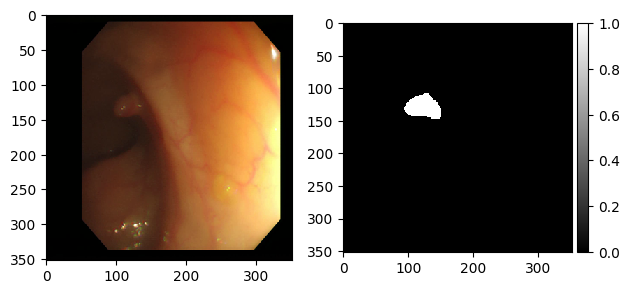

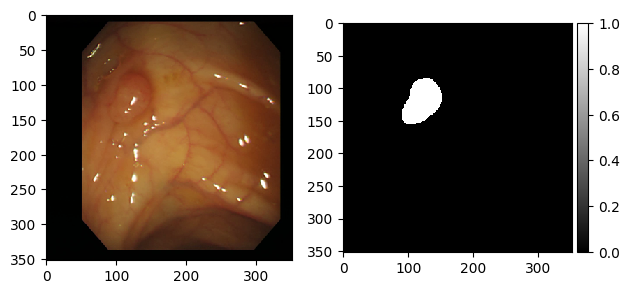

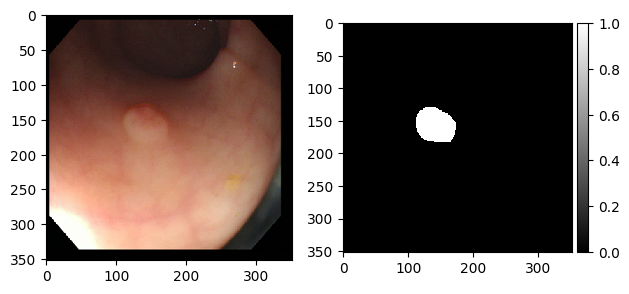

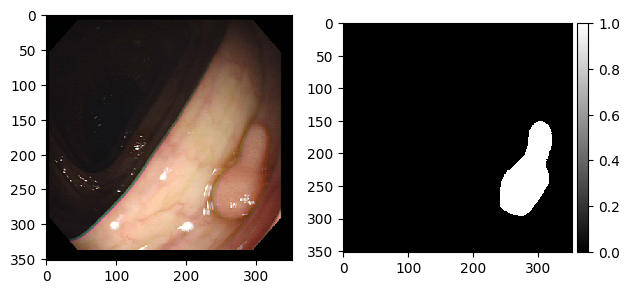

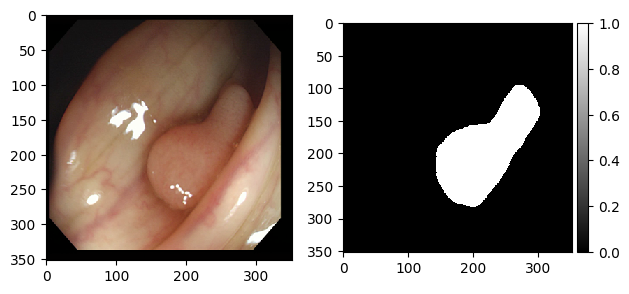

In [7]:
import random

for i in range(0,5):
    image_x = random.randint(0, 37)

    plt.subplot(1,2,1)
    imshow(X_val[image_x])

    plt.subplot(1,2,2)
    imshow(y_val[image_x], cmap='gray')
    plt.show()

In [8]:
import albumentations as A
from albumentations.augmentations import functional as F

aug_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    A.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
    A.GaussianBlur(blur_limit=(25, 25),sigma_limit=(0.001, 2.0),always_apply=False, p=0.5),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(X_train)):
        ug = aug_train(image=X_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [9]:
from metrics import f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU

In [10]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from keras.layers import (
    Conv2D,
    BatchNormalization,
    Activation,
    Concatenate,
    Input,
    Dropout,
)
from keras.layers import (
    AveragePooling2D,
    GlobalAveragePooling2D,
    UpSampling2D,
    Reshape,
    Dense,
)
from keras.models import Model
from keras.applications import ResNet50, ResNet101
from keras.regularizers import l2
from tensorflow.python.keras.engine.keras_tensor import KerasTensor


def squeeze_and_excite(inputs: KerasTensor, ratio: int = 8) -> KerasTensor:
    """Function to apply Squeeze & Excitation to a feature map.

    Args:
        inputs (KerasTensor): Feature Map
        ratio (int, optional): Ratio for excitation in first dense layer. Defaults to 8.

    Returns:
        KerasTensor: Re-calibrated feature map.
    """
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(
        filters // ratio,
        activation="relu",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)
    se = Dense(
        filters,
        activation="sigmoid",
        kernel_initializer="he_normal",
        use_bias=False,
    )(se)

    x = init * se
    return x


def ASPP(inputs: KerasTensor) -> KerasTensor:
    """Function to apply Atrous Spatial Pyramid Pooling on features from backbone.

    Args:
        inputs (KerasTensor): Features from backbone.

    Returns:
        KerasTensor: Features with better spatial context.
    """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    # 1x1 Convolution
    y2 = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(inputs)
    y2 = BatchNormalization()(y2)
    # y2 = Dropout(0.5)(y2)
    y2 = Activation("relu")(y2)

    # 3x3 Convolution, Dilation Rate - 12 or 6
    y3 = Conv2D(
        256, 3, padding="same", dilation_rate=6, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    # 3x3 Convolution, Dilation Rate - 24 or 12
    y4 = Conv2D(
        256, 3, padding="same", dilation_rate=12, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    # 3x3 Convolution, Dilation Rate - 36 or 18
    y5 = Conv2D(
        256, 3, padding="same", dilation_rate=18, use_bias=False, kernel_initializer="he_normal"
    )(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    # 1x1 Convolution on the concatenated Feature Map
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding="same", use_bias=False, kernel_initializer="he_normal")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y


def createModel(modelType: str, shape: tuple[int] = (352, 352, 3)) -> Model:
    """Creates a Model with the specified backbone.

    Args:
        modelType (str): Choice of backbone. ResNet50 or ResNet101.
        shape (tuple[int]): Shape of input to the model. Defaults to (256, 256, 3).

    Returns:
        Model: Your DeepLabV3+ Model.
    """
    inputs = Input(shape)  # instantiating a tensor

    encoder = (
        ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)
        if modelType == "ResNet101"
        else ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    )

    image_features = encoder.get_layer(
        "conv4_block23_out" if modelType == "ResNet101" else "conv4_block6_out"
    ).output

    # High-Level Features
    x_a = ASPP(image_features)
    # Up-Sampling High-Level Features by 4
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)
    x_a = Dropout(0.5)(x_a)

    # Low-Level Features
    x_b = encoder.get_layer("conv2_block2_out").output

    # 1x1 Convolution on Low-Level Features
    x_b = Conv2D(
        filters=48, kernel_size=1, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation("relu")(x_b)

    # Concatenating High-Level and Low-Level Features
    x = Concatenate()([x_a, x_b])
    x = Dropout(0.5)(x)
    # x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # 3x3 Convolution on Concatenated Map
    x = Conv2D(
        filters=256, kernel_size=3, padding="same", use_bias=False, kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = Activation("relu")(x)
    x = squeeze_and_excite(x)

    # Final Up-Sampling by 4
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(1, 1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)

    return model

In [11]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = K.cast(ground_truth, tf.float32)
    predictions = K.cast(predictions, tf.float32)
    ground_truth = K.flatten(ground_truth)
    predictions = K.flatten(predictions)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice

In [24]:
seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="cvccolondb"
model_type = "deeplabv3p"

model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + 'newaug'

In [25]:
from keras.optimizers import AdamW

deeplabv3p_model = createModel(modelType="ResNet101",shape=(352,352,3))
optimizer = AdamW(
    learning_rate = 0.00001, weight_decay = 0.004)
loss = 'binary_crossentropy'
deeplabv3p_model.compile(optimizer=optimizer, loss=loss,
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
step = 0
learning_rate = 1e-5
min_loss_for_saving = 0.2

start_time = time.time()

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    tf.keras.backend.clear_session()

    image_augmented, mask_augmented = augment_images()

    deeplabv3p_model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(X_val, y_val), verbose=1)

    prediction_valid = deeplabv3p_model.predict(X_val, verbose=1, batch_size=4)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = deeplabv3p_model.predict(X_test, verbose=0, batch_size=16)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        deeplabv3p_model.save(model_path)

    del image_augmented
    del mask_augmented
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Training, epoch 0
Learning Rate: 1e-05


2023-11-30 21:30:47.734904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-30 21:30:50.359722: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f32603eac80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 21:30:50.359742: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-11-30 21:30:50.363517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 21:30:50.418450: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.8737464
Loss Test: 0.858797
Training, epoch 1
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.8856037
Loss Test: 0.8634842
Training, epoch 2
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.905502
Loss Test: 0.8831043
Training, epoch 3
Learning Rate: 1e-05


2023-11-30 21:31:47.864969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.99067247
Loss Test: 0.9665867
Training, epoch 4
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.95741665
Loss Test: 0.97377616
Training, epoch 5
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.9469578
Loss Test: 0.998161
Training, epoch 6
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.84769714
Loss Test: 0.8312636
Training, epoch 7
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.82903683
Loss Test: 0.8169247
Training, epoch 8
Learning Rate: 1e-05


2023-11-30 21:32:58.414654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.7863697
Loss Test: 0.7864398
Training, epoch 9
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.7072506
Loss Test: 0.7162707
Training, epoch 10
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.6263517
Loss Test: 0.63440865
Training, epoch 11
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.5830232
Loss Test: 0.5887773
Training, epoch 12
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.51918733
Loss Test: 0.5357405
Training, epoch 13
Learning Rate: 1e-05


2023-11-30 21:34:08.915638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.4480595
Loss Test: 0.4760611
Training, epoch 14
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.4175313
Loss Test: 0.43185806
Training, epoch 15
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.41724098
Loss Test: 0.44001073
Training, epoch 16
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.39044207
Loss Test: 0.41622448
Training, epoch 17
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.37828678
Loss Test: 0.40331286
Training, epoch 18
Learning Rate: 1e-05


2023-11-30 21:35:19.562078: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.37227184
Loss Test: 0.46001577
Training, epoch 19
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.3672189
Loss Test: 0.4668966
Training, epoch 20
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.39968532
Loss Test: 0.46939206
Training, epoch 21
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.35456562
Loss Test: 0.4209141
Training, epoch 22
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.38990796
Loss Test: 0.41566312
Training, epoch 23
Learning Rate: 1e-05


2023-11-30 21:36:30.602906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.35289103
Loss Test: 0.4023186
Training, epoch 24
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.36012197
Loss Test: 0.44637132
Training, epoch 25
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.3270526
Loss Test: 0.43310857
Training, epoch 26
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.31952792
Loss Test: 0.4319684
Training, epoch 27
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.36818004
Loss Test: 0.42011285
Training, epoch 28
Learning Rate: 1e-05


2023-11-30 21:37:41.068188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.31853884
Loss Test: 0.31880033
Training, epoch 29
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.31101757
Loss Test: 0.3525738
Training, epoch 30
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.29107124
Loss Test: 0.33192605
Training, epoch 31
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.27092874
Loss Test: 0.30673832
Training, epoch 32
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.2747178
Loss Test: 0.3132224
Training, epoch 33
Learning Rate: 1e-05


2023-11-30 21:38:52.333147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.29068047
Loss Test: 0.3151638
Training, epoch 34
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.28253782
Loss Test: 0.33608526
Training, epoch 35
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.25926405
Loss Test: 0.28715974
Training, epoch 36
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.27182966
Loss Test: 0.28214878
Training, epoch 37
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.29055452
Loss Test: 0.27121848
Training, epoch 38
Learning Rate: 1e-05


2023-11-30 21:40:03.239083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.26316625
Loss Test: 0.2809978
Training, epoch 39
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.24507177
Loss Test: 0.27096486
Training, epoch 40
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.2476573
Loss Test: 0.27991587
Training, epoch 41
Learning Rate: 1e-05
10/10 [==============================] - 1s 24ms/step
Loss Validation: 0.23624915
Loss Test: 0.2613173
Training, epoch 42
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.27173078
Loss Test: 0.2652654
Training, epoch 43
Learning Rate: 1e-05


2023-11-30 21:41:14.045984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.26833647
Loss Test: 0.29276097
Training, epoch 44
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.24646139
Loss Test: 0.26587558
Training, epoch 45
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.30248863
Loss Test: 0.29345745
Training, epoch 46
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.24312913
Loss Test: 0.41422945
Training, epoch 47
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.22242701
Loss Test: 0.30573976
Training, epoch 48
Learning Rate: 1e-05


2023-11-30 21:42:25.015342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.20849603
Loss Test: 0.24631643
Training, epoch 49
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.22257102
Loss Test: 0.37031317
Training, epoch 50
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.2041663
Loss Test: 0.28208596
Training, epoch 51
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.23452437
Loss Test: 0.2902292
Training, epoch 52
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.20743561
Loss Test: 0.37583643
Training, epoch 53
Learning Rate: 1e-05


2023-11-30 21:43:35.774081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.26951563
Loss Test: 0.27225786
Training, epoch 54
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.22395921
Loss Test: 0.28272617
Training, epoch 55
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.19343263
Loss Test: 0.22912627
Saved model with val_loss:  0.19343263
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 56
Learning Rate: 1e-05


2023-11-30 21:44:35.833568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.17684078
Loss Test: 0.2302891
Saved model with val_loss:  0.17684078
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 57
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.19230121
Loss Test: 0.2472471
Training, epoch 58
Learning Rate: 1e-05
10/10 [==============================] - 1s 36ms/step
Loss Validation: 0.19377017
Loss Test: 0.24506819
Training, epoch 59
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.1866538
Loss Test: 0.24773997
Training, epoch 60
Learning Rate: 1e-05


2023-11-30 21:45:49.781882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 24ms/step
Loss Validation: 0.19235975
Loss Test: 0.25115466
Training, epoch 61
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.2774009
Loss Test: 0.25303894
Training, epoch 62
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.18238276
Loss Test: 0.24147016
Training, epoch 63
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.22265846
Loss Test: 0.21724415
Training, epoch 64
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.22874177
Loss Test: 0.224347
Training, epoch 65
Learning Rate: 1e-05


2023-11-30 21:47:00.200645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.20339316
Loss Test: 0.2174809
Training, epoch 66
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.1643256
Loss Test: 0.19580686
Saved model with val_loss:  0.1643256
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 67
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.16457903
Loss Test: 0.20769548
Training, epoch 68
Learning Rate: 1e-05


2023-11-30 21:48:02.036011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.15841097
Loss Test: 0.18282199
Saved model with val_loss:  0.15841097
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 69
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.15601051
Loss Test: 0.19327968
Saved model with val_loss:  0.15601051
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 70
Learning Rate: 1e-05


2023-11-30 21:49:06.128745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.1581397
Loss Test: 0.18262565
Training, epoch 71
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.16693944
Loss Test: 0.18892473
Training, epoch 72
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.17203295
Loss Test: 0.1824333
Training, epoch 73
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.17195886
Loss Test: 0.1932159
Training, epoch 74
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.28895444
Loss Test: 0.19542289
Training, epoch 75
Learning Rate: 1e-05


2023-11-30 21:50:17.326686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.3170423
Loss Test: 0.19673985
Training, epoch 76
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.18632114
Loss Test: 0.2119385
Training, epoch 77
Learning Rate: 1e-05
10/10 [==============================] - 1s 26ms/step
Loss Validation: 0.1718927
Loss Test: 0.18479985
Training, epoch 78
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.17976284
Loss Test: 0.20212072
Training, epoch 79
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.17687958
Loss Test: 0.1858415
Training, epoch 80
Learning Rate: 1e-05


2023-11-30 21:51:28.464494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.16745108
Loss Test: 0.19454837
Training, epoch 81
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.16800112
Loss Test: 0.18315923
Training, epoch 82
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.16236961
Loss Test: 0.17802143
Training, epoch 83
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.15935099
Loss Test: 0.17584532
Training, epoch 84
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.15865546
Loss Test: 0.17567933
Training, epoch 85
Learning Rate: 1e-05


2023-11-30 21:52:39.203276: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.15951931
Loss Test: 0.18154699
Training, epoch 86
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.16011417
Loss Test: 0.16909581
Training, epoch 87
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.16004622
Loss Test: 0.17398667
Training, epoch 88
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.15466428
Loss Test: 0.18613654
Saved model with val_loss:  0.15466428
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 89
Learning Rate: 1e-05


2023-11-30 21:53:52.401782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.15041548
Loss Test: 0.17787015
Saved model with val_loss:  0.15041548
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 90
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.15114003
Loss Test: 0.16358334
Training, epoch 91
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.14407063
Loss Test: 0.17136443
Saved model with val_loss:  0.14407063
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 92
Learning Rate: 1e-05


2023-11-30 21:55:08.327503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.13737977
Loss Test: 0.17121792
Saved model with val_loss:  0.13737977
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 93
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.13741207
Loss Test: 0.18770802
Training, epoch 94
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.13672203
Loss Test: 0.18315393
Saved model with val_loss:  0.13672203
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 95
Learning Rate: 1e-05


2023-11-30 21:56:25.176623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.2845468
Loss Test: 0.3136747
Training, epoch 96
Learning Rate: 1e-05
10/10 [==============================] - 1s 37ms/step
Loss Validation: 0.1891908
Loss Test: 0.29297274
Training, epoch 97
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.15138263
Loss Test: 0.27619427
Training, epoch 98
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.19298112
Loss Test: 0.24250901
Training, epoch 99
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.20515162
Loss Test: 0.23202932
Training, epoch 100
Learning Rate: 1e-05


2023-11-30 21:57:36.037530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.19929266
Loss Test: 0.32513225
Training, epoch 101
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.18711686
Loss Test: 0.18287677
Training, epoch 102
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.19601375
Loss Test: 0.20582223
Training, epoch 103
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.21826273
Loss Test: 0.21918267
Training, epoch 104
Learning Rate: 1e-05
10/10 [==============================] - 1s 39ms/step
Loss Validation: 0.22364104
Loss Test: 0.21468455
Training, epoch 105
Learning Rate: 1e-05


2023-11-30 21:58:46.535695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.24686867
Loss Test: 0.21705788
Training, epoch 106
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.19342643
Loss Test: 0.2051751
Training, epoch 107
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.14717376
Loss Test: 0.20088828
Training, epoch 108
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.15510803
Loss Test: 0.2133221
Training, epoch 109
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.133712
Loss Test: 0.18381333
Saved model with val_loss:  0.133712
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 110
Learning Rate: 1e-05


2023-11-30 22:00:14.423933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.13017726
Loss Test: 0.18295872
Saved model with val_loss:  0.13017726
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 111
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.12389648
Loss Test: 0.16415334
Saved model with val_loss:  0.12389648
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 112
Learning Rate: 1e-05


2023-11-30 22:01:16.791814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.12954426
Loss Test: 0.1457243
Training, epoch 113
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.12911814
Loss Test: 0.15642166
Training, epoch 114
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.12834144
Loss Test: 0.16078413
Training, epoch 115
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.14120716
Loss Test: 0.14933693
Training, epoch 116
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.13386065
Loss Test: 0.1323964
Training, epoch 117
Learning Rate: 1e-05


2023-11-30 22:02:27.595277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.1216383
Loss Test: 0.13542402
Saved model with val_loss:  0.1216383
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 118
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.12799573
Loss Test: 0.1513421
Training, epoch 119
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.119684935
Loss Test: 0.1449526
Saved model with val_loss:  0.119684935
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 120
Learning Rate: 1e-05


2023-11-30 22:03:43.763575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.11749947
Loss Test: 0.13651752
Saved model with val_loss:  0.11749947
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 121
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.12344295
Loss Test: 0.14197457
Training, epoch 122
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.12278384
Loss Test: 0.16625148
Training, epoch 123
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.11204225
Loss Test: 0.13832092
Saved model with val_loss:  0.11204225
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 124
Learning Rate: 1e-05


2023-11-30 22:05:14.531219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.10667497
Loss Test: 0.14554328
Saved model with val_loss:  0.10667497
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 125
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.105293274
Loss Test: 0.13902855
Saved model with val_loss:  0.105293274
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 126
Learning Rate: 1e-05


2023-11-30 22:06:16.731680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.10235727
Loss Test: 0.14566517
Saved model with val_loss:  0.10235727
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 127
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.13035673
Loss Test: 0.2015484
Training, epoch 128
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.10733086
Loss Test: 0.15022004
Training, epoch 129
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.110347986
Loss Test: 0.14639837
Training, epoch 130
Learning Rate: 1e-05


2023-11-30 22:07:30.654513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.11980444
Loss Test: 0.17168885
Training, epoch 131
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.1106621
Loss Test: 0.16562325
Training, epoch 132
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.1051898
Loss Test: 0.14303952
Training, epoch 133
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.108644366
Loss Test: 0.1664775
Training, epoch 134
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.1149348
Loss Test: 0.17548424
Training, epoch 135
Learning Rate: 1e-05


2023-11-30 22:08:41.122425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.103081524
Loss Test: 0.13463712
Training, epoch 136
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.101836145
Loss Test: 0.13293898
Saved model with val_loss:  0.101836145
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 137
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.11365777
Loss Test: 0.17650265
Training, epoch 138
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.1039809
Loss Test: 0.14755344
Training, epoch 139
Learning Rate: 1e-05


2023-11-30 22:09:54.739678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.10188633
Loss Test: 0.14661855
Training, epoch 140
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.10679448
Loss Test: 0.14470619
Training, epoch 141
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.11095101
Loss Test: 0.16158241
Training, epoch 142
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.11902028
Loss Test: 0.18878204
Training, epoch 143
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.11913568
Loss Test: 0.17089534
Training, epoch 144
Learning Rate: 1e-05


2023-11-30 22:11:05.628427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 36ms/step
Loss Validation: 0.10909212
Loss Test: 0.14383209
Training, epoch 145
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.10746199
Loss Test: 0.14785701
Training, epoch 146
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.10406983
Loss Test: 0.13502848
Training, epoch 147
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.10554671
Loss Test: 0.12918836
Training, epoch 148
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.10524356
Loss Test: 0.1316365
Training, epoch 149
Learning Rate: 1e-05


2023-11-30 22:12:16.281140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.10597378
Loss Test: 0.13144898
Training, epoch 150
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.114860356
Loss Test: 0.16392165
Training, epoch 151
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.104734
Loss Test: 0.14270097
Training, epoch 152
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.12557697
Loss Test: 0.1794064
Training, epoch 153
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09669161
Loss Test: 0.12826622
Saved model with val_loss:  0.09669161
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 154
Learning Rate: 1e-05


2023-11-30 22:13:43.783179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.09510827
Loss Test: 0.12587786
Saved model with val_loss:  0.09510827
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 155
Learning Rate: 1e-05
10/10 [==============================] - 1s 36ms/step
Loss Validation: 0.0996775
Loss Test: 0.13924235
Training, epoch 156
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09894174
Loss Test: 0.13002723
Training, epoch 157
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.101288795
Loss Test: 0.14695466
Training, epoch 158
Learning Rate: 1e-05


2023-11-30 22:14:57.193160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.122774005
Loss Test: 0.13786322
Training, epoch 159
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.10288322
Loss Test: 0.15081531
Training, epoch 160
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09621167
Loss Test: 0.13509321
Training, epoch 161
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.130602
Loss Test: 0.18322867
Training, epoch 162
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.102371395
Loss Test: 0.14176607
Training, epoch 163
Learning Rate: 1e-05


2023-11-30 22:16:07.624992: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.11080074
Loss Test: 0.15617877
Training, epoch 164
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.10324228
Loss Test: 0.14428467
Training, epoch 165
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09755415
Loss Test: 0.13052821
Training, epoch 166
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.098685384
Loss Test: 0.14070463
Training, epoch 167
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.10103798
Loss Test: 0.14701194
Training, epoch 168
Learning Rate: 1e-05


2023-11-30 22:17:17.835195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 24ms/step
Loss Validation: 0.10759246
Loss Test: 0.15493435
Training, epoch 169
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.10966003
Loss Test: 0.1595186
Training, epoch 170
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.10802567
Loss Test: 0.16125304
Training, epoch 171
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.10031873
Loss Test: 0.14542401
Training, epoch 172
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.09386492
Loss Test: 0.13682806
Saved model with val_loss:  0.09386492
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 173
Learning Rate: 1e-05


2023-11-30 22:18:45.340671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.10048169
Loss Test: 0.1569612
Training, epoch 174
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.11673373
Loss Test: 0.16887933
Training, epoch 175
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.11198193
Loss Test: 0.1524846
Training, epoch 176
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.10210842
Loss Test: 0.1365025
Training, epoch 177
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.0965898
Loss Test: 0.13048178
Training, epoch 178
Learning Rate: 1e-05


2023-11-30 22:19:57.334345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.10427517
Loss Test: 0.14804578
Training, epoch 179
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.09972662
Loss Test: 0.143197
Training, epoch 180
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.1031329
Loss Test: 0.15156871
Training, epoch 181
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.113823235
Loss Test: 0.1611687
Training, epoch 182
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.11724371
Loss Test: 0.16987556
Training, epoch 183
Learning Rate: 1e-05


2023-11-30 22:21:07.294747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.09522641
Loss Test: 0.12816077
Training, epoch 184
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.106185734
Loss Test: 0.15392649
Training, epoch 185
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.105311036
Loss Test: 0.15818697
Training, epoch 186
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.10263455
Loss Test: 0.15460837
Training, epoch 187
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.097058475
Loss Test: 0.15119314
Training, epoch 188
Learning Rate: 1e-05


2023-11-30 22:22:17.416830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09233016
Loss Test: 0.14836937
Saved model with val_loss:  0.09233016
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 189
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.097384155
Loss Test: 0.16636133
Training, epoch 190
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.09518784
Loss Test: 0.15271568
Training, epoch 191
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09476167
Loss Test: 0.15417176
Training, epoch 192
Learning Rate: 1e-05


2023-11-30 22:23:30.734986: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.09357566
Loss Test: 0.15154386
Training, epoch 193
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.088721395
Loss Test: 0.1431089
Saved model with val_loss:  0.088721395
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 194
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.090528846
Loss Test: 0.14798397
Training, epoch 195
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08756477
Loss Test: 0.1351496
Saved model with val_loss:  0.08756477
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 196
Learning Rate: 1e-05


2023-11-30 22:25:01.271353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.10098684
Loss Test: 0.15296197
Training, epoch 197
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09947401
Loss Test: 0.15338635
Training, epoch 198
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.089502335
Loss Test: 0.12725574
Training, epoch 199
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.09231579
Loss Test: 0.14301687
Training, epoch 200
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09545088
Loss Test: 0.13285816
Training, epoch 201
Learning Rate: 1e-05


2023-11-30 22:26:12.020377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.09576541
Loss Test: 0.13532704
Training, epoch 202
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.096600175
Loss Test: 0.14918649
Training, epoch 203
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08753961
Loss Test: 0.12453377
Saved model with val_loss:  0.08753961
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 204
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.09237844
Loss Test: 0.12599504
Training, epoch 205
Learning Rate: 1e-05


2023-11-30 22:27:25.121227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.091092646
Loss Test: 0.14474487
Training, epoch 206
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.09345013
Loss Test: 0.13812613
Training, epoch 207
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.09209293
Loss Test: 0.13366985
Training, epoch 208
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.086639225
Loss Test: 0.11297017
Saved model with val_loss:  0.086639225
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 209
Learning Rate: 1e-05


2023-11-30 22:28:38.884573: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09215301
Loss Test: 0.13420492
Training, epoch 210
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.089954674
Loss Test: 0.11600852
Training, epoch 211
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.097371876
Loss Test: 0.13526517
Training, epoch 212
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08858448
Loss Test: 0.1257695
Training, epoch 213
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.094860196
Loss Test: 0.13934016
Training, epoch 214
Learning Rate: 1e-05


2023-11-30 22:29:49.198267: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.092276275
Loss Test: 0.12294006
Training, epoch 215
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.098083496
Loss Test: 0.13980573
Training, epoch 216
Learning Rate: 1e-05
10/10 [==============================] - 1s 37ms/step
Loss Validation: 0.090088844
Loss Test: 0.12156862
Training, epoch 217
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08520645
Loss Test: 0.11114061
Saved model with val_loss:  0.08520645
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 218
Learning Rate: 1e-05


2023-11-30 22:31:02.644437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08687329
Loss Test: 0.12033033
Training, epoch 219
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.087093174
Loss Test: 0.12144613
Training, epoch 220
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08428615
Loss Test: 0.10988778
Saved model with val_loss:  0.08428615
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 221
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.09021312
Loss Test: 0.12629783
Training, epoch 222
Learning Rate: 1e-05


2023-11-30 22:32:15.960316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.08437866
Loss Test: 0.105965555
Training, epoch 223
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.097542286
Loss Test: 0.122498035
Training, epoch 224
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.1038419
Loss Test: 0.16114849
Training, epoch 225
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.089377224
Loss Test: 0.11994851
Training, epoch 226
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08688837
Loss Test: 0.115706086
Training, epoch 227
Learning Rate: 1e-05


2023-11-30 22:33:26.711506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08938378
Loss Test: 0.12960017
Training, epoch 228
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.09630442
Loss Test: 0.14297855
Training, epoch 229
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09024346
Loss Test: 0.12706155
Training, epoch 230
Learning Rate: 1e-05
10/10 [==============================] - 1s 36ms/step
Loss Validation: 0.09386641
Loss Test: 0.13629115
Training, epoch 231
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08853817
Loss Test: 0.12348229
Training, epoch 232
Learning Rate: 1e-05


2023-11-30 22:34:37.981251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.10132396
Loss Test: 0.15376002
Training, epoch 233
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.09267694
Loss Test: 0.1352107
Training, epoch 234
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08380729
Loss Test: 0.1154713
Saved model with val_loss:  0.08380729
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 235
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.085454404
Loss Test: 0.12525547
Training, epoch 236
Learning Rate: 1e-05


2023-11-30 22:35:51.717578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.088335395
Loss Test: 0.124729395
Training, epoch 237
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.10273105
Loss Test: 0.13953364
Training, epoch 238
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.0892179
Loss Test: 0.12345791
Training, epoch 239
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.08276147
Loss Test: 0.11819291
Saved model with val_loss:  0.08276147
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 240
Learning Rate: 1e-05


2023-11-30 22:37:05.444532: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08008188
Loss Test: 0.1340298
Saved model with val_loss:  0.08008188
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 241
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08496374
Loss Test: 0.11901295
Training, epoch 242
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.08577216
Loss Test: 0.118560255
Training, epoch 243
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.0885033
Loss Test: 0.13022405
Training, epoch 244
Learning Rate: 1e-05


2023-11-30 22:38:18.709342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.08632249
Loss Test: 0.11600983
Training, epoch 245
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08849597
Loss Test: 0.1251542
Training, epoch 246
Learning Rate: 1e-05
10/10 [==============================] - 1s 36ms/step
Loss Validation: 0.09291303
Loss Test: 0.12744409
Training, epoch 247
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.088934004
Loss Test: 0.11687815
Training, epoch 248
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08692253
Loss Test: 0.1144138
Training, epoch 249
Learning Rate: 1e-05


2023-11-30 22:39:29.252568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.09125316
Loss Test: 0.12075794
Training, epoch 250
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.082405746
Loss Test: 0.109311104
Training, epoch 251
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.083723664
Loss Test: 0.1065228
Training, epoch 252
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.08079797
Loss Test: 0.103565335
Training, epoch 253
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.08599794
Loss Test: 0.113461375
Training, epoch 254
Learning Rate: 1e-05


2023-11-30 22:40:39.615599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.083355844
Loss Test: 0.10753721
Training, epoch 255
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.086901605
Loss Test: 0.1088652
Training, epoch 256
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.097438455
Loss Test: 0.12909055
Training, epoch 257
Learning Rate: 1e-05
10/10 [==============================] - 1s 26ms/step
Loss Validation: 0.08585292
Loss Test: 0.10743207
Training, epoch 258
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.08374369
Loss Test: 0.101616144
Training, epoch 259
Learning Rate: 1e-05


2023-11-30 22:41:50.114515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.08224279
Loss Test: 0.10229325
Training, epoch 260
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.08322936
Loss Test: 0.113031626
Training, epoch 261
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.09054315
Loss Test: 0.1310271
Training, epoch 262
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.08769286
Loss Test: 0.12218863
Training, epoch 263
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08117193
Loss Test: 0.115885794
Training, epoch 264
Learning Rate: 1e-05


2023-11-30 22:43:00.895238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.078308284
Loss Test: 0.10177982
Saved model with val_loss:  0.078308284
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 265
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.0807662
Loss Test: 0.11195153
Training, epoch 266
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08844584
Loss Test: 0.12591487
Training, epoch 267
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07977337
Loss Test: 0.10957205
Training, epoch 268
Learning Rate: 1e-05


2023-11-30 22:44:14.711116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.090798736
Loss Test: 0.12807935
Training, epoch 269
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.07787782
Loss Test: 0.09629786
Saved model with val_loss:  0.07787782
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 270
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08075237
Loss Test: 0.11076373
Training, epoch 271
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.0932917
Loss Test: 0.12982166
Training, epoch 272
Learning Rate: 1e-05


2023-11-30 22:45:28.331995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.081136644
Loss Test: 0.112365186
Training, epoch 273
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.0905723
Loss Test: 0.12491709
Training, epoch 274
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.08704913
Loss Test: 0.116361976
Training, epoch 275
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.089755714
Loss Test: 0.12726986
Training, epoch 276
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.08109653
Loss Test: 0.114604056
Training, epoch 277
Learning Rate: 1e-05


2023-11-30 22:46:38.783543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.09626925
Loss Test: 0.12724358
Training, epoch 278
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.088235855
Loss Test: 0.1263699
Training, epoch 279
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.087124765
Loss Test: 0.116726875
Training, epoch 280
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.08831918
Loss Test: 0.117154956
Training, epoch 281
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.08205795
Loss Test: 0.10794264
Training, epoch 282
Learning Rate: 1e-05


2023-11-30 22:47:49.547263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.07816166
Loss Test: 0.10557842
Training, epoch 283
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.07890314
Loss Test: 0.111430824
Training, epoch 284
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.08048648
Loss Test: 0.11618358
Training, epoch 285
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.07684547
Loss Test: 0.10866028
Saved model with val_loss:  0.07684547
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 286
Learning Rate: 1e-05


2023-11-30 22:49:03.212546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.07815015
Loss Test: 0.10375029
Training, epoch 287
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07954633
Loss Test: 0.10852033
Training, epoch 288
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07714331
Loss Test: 0.102454185
Training, epoch 289
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.07686281
Loss Test: 0.10294038
Training, epoch 290
Learning Rate: 1e-05
10/10 [==============================] - 1s 37ms/step
Loss Validation: 0.07666761
Loss Test: 0.10358012
Saved model with val_loss:  0.07666761
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 291
Learning Rate: 1e-05


2023-11-30 22:50:31.070528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07397628
Loss Test: 0.0995155
Saved model with val_loss:  0.07397628
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 292
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.078599095
Loss Test: 0.11456221
Training, epoch 293
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.14382088
Loss Test: 0.14786035
Training, epoch 294
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.11627567
Loss Test: 0.12150568
Training, epoch 295
Learning Rate: 1e-05


2023-11-30 22:51:44.649119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.09904069
Loss Test: 0.101616025
Training, epoch 296
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.09869295
Loss Test: 0.1027326
Training, epoch 297
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.08022195
Loss Test: 0.115671456
Training, epoch 298
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.07950342
Loss Test: 0.11786157
Training, epoch 299
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.12884468
Loss Test: 0.119957864
Training, epoch 300
Learning Rate: 1e-05


2023-11-30 22:52:55.337723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.12956786
Loss Test: 0.120265424
Training, epoch 301
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.13104856
Loss Test: 0.12348902
Training, epoch 302
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.12848634
Loss Test: 0.12491721
Training, epoch 303
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.12819564
Loss Test: 0.124090016
Training, epoch 304
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.12567747
Loss Test: 0.12708652
Training, epoch 305
Learning Rate: 1e-05


2023-11-30 22:54:05.942838: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.1526373
Loss Test: 0.12112439
Training, epoch 306
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.13545805
Loss Test: 0.15607005
Training, epoch 307
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.14503747
Loss Test: 0.17257994
Training, epoch 308
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.12171435
Loss Test: 0.11615819
Training, epoch 309
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.16522455
Loss Test: 0.12167901
Training, epoch 310
Learning Rate: 1e-05


2023-11-30 22:55:18.561159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.13859516
Loss Test: 0.12849027
Training, epoch 311
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.17890769
Loss Test: 0.20315689
Training, epoch 312
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.12602025
Loss Test: 0.13564485
Training, epoch 313
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.096722305
Loss Test: 0.13816345
Training, epoch 314
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.08333427
Loss Test: 0.11577374
Training, epoch 315
Learning Rate: 1e-05


2023-11-30 22:56:29.939113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 26ms/step
Loss Validation: 0.08494145
Loss Test: 0.12431252
Training, epoch 316
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.08084458
Loss Test: 0.12281418
Training, epoch 317
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08073157
Loss Test: 0.1186651
Training, epoch 318
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.079537034
Loss Test: 0.12050116
Training, epoch 319
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.07662767
Loss Test: 0.12272239
Training, epoch 320
Learning Rate: 1e-05


2023-11-30 22:57:40.707071: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07535881
Loss Test: 0.1181038
Training, epoch 321
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.108787656
Loss Test: 0.116907656
Training, epoch 322
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.09324777
Loss Test: 0.11695129
Training, epoch 323
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.14660347
Loss Test: 0.1712519
Training, epoch 324
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.08079356
Loss Test: 0.12438434
Training, epoch 325
Learning Rate: 1e-05


2023-11-30 22:58:51.209943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.078903794
Loss Test: 0.122226
Training, epoch 326
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.07526302
Loss Test: 0.10748947
Training, epoch 327
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.1150589
Loss Test: 0.12377739
Training, epoch 328
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.11719096
Loss Test: 0.13342583
Training, epoch 329
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.11216092
Loss Test: 0.11651343
Training, epoch 330
Learning Rate: 1e-05


2023-11-30 23:00:02.002342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.113360226
Loss Test: 0.13861603
Training, epoch 331
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.110452354
Loss Test: 0.1264528
Training, epoch 332
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.10982162
Loss Test: 0.11555213
Training, epoch 333
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.10883224
Loss Test: 0.109455585
Training, epoch 334
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07924807
Loss Test: 0.13010323
Training, epoch 335
Learning Rate: 1e-05


2023-11-30 23:01:13.606448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.0813182
Loss Test: 0.114746034
Training, epoch 336
Learning Rate: 1e-05
10/10 [==============================] - 1s 27ms/step
Loss Validation: 0.07989633
Loss Test: 0.117138326
Training, epoch 337
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.078894496
Loss Test: 0.117827535
Training, epoch 338
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.07625759
Loss Test: 0.115361154
Training, epoch 339
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.08298296
Loss Test: 0.113903046
Training, epoch 340
Learning Rate: 1e-05


2023-11-30 23:02:24.005906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.08276236
Loss Test: 0.11870372
Training, epoch 341
Learning Rate: 1e-05
10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.07677609
Loss Test: 0.10306084
Training, epoch 342
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.07633531
Loss Test: 0.1078828
Training, epoch 343
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.07687992
Loss Test: 0.12031168
Training, epoch 344
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07763165
Loss Test: 0.1256916
Training, epoch 345
Learning Rate: 1e-05


2023-11-30 23:03:34.716202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.076723814
Loss Test: 0.11561054
Training, epoch 346
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.07386339
Loss Test: 0.10367018
Saved model with val_loss:  0.07386339
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 347
Learning Rate: 1e-05
10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.072365284
Loss Test: 0.10429567
Saved model with val_loss:  0.072365284
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 348
Learning Rate: 1e-05


2023-11-30 23:04:51.522253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.07389152
Loss Test: 0.11386126
Training, epoch 349
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.07395375
Loss Test: 0.11653209
Training, epoch 350
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.07394695
Loss Test: 0.119286835
Training, epoch 351
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.07762098
Loss Test: 0.1288566
Training, epoch 352
Learning Rate: 1e-05
10/10 [==============================] - 1s 35ms/step
Loss Validation: 0.07118374
Loss Test: 0.10328746
Saved model with val_loss:  0.07118374
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 353
Learning Rate: 1e-05


2023-11-30 23:06:19.380515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.072436094
Loss Test: 0.10997838
Training, epoch 354
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.07311827
Loss Test: 0.11193794
Training, epoch 355
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.07871497
Loss Test: 0.13417798
Training, epoch 356
Learning Rate: 1e-05
10/10 [==============================] - 1s 28ms/step
Loss Validation: 0.07263398
Loss Test: 0.10470706
Training, epoch 357
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.08108652
Loss Test: 0.14560068
Training, epoch 358
Learning Rate: 1e-05


2023-11-30 23:07:30.568506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 33ms/step
Loss Validation: 0.07271159
Loss Test: 0.10743517
Training, epoch 359
Learning Rate: 1e-05
10/10 [==============================] - 1s 31ms/step
Loss Validation: 0.0722633
Loss Test: 0.098026395
Training, epoch 360
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.07078147
Loss Test: 0.108340025
Saved model with val_loss:  0.07078147
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 361
Learning Rate: 1e-05
10/10 [==============================] - 1s 30ms/step
Loss Validation: 0.07086468
Loss Test: 0.10891849
Training, epoch 362
Learning Rate: 1e-05


2023-11-30 23:08:44.525735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 1s 32ms/step
Loss Validation: 0.07269418
Loss Test: 0.112265766
Training, epoch 363
Learning Rate: 1e-05
10/10 [==============================] - 1s 29ms/step
Loss Validation: 0.069648325
Loss Test: 0.11085302
Saved model with val_loss:  0.069648325
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug/assets


Training, epoch 364
Learning Rate: 1e-05
10/10 [==============================] - 1s 34ms/step
Loss Validation: 0.07588273
Loss Test: 0.12751794
Training, epoch 365
Learning Rate: 1e-05


In [ ]:
del deeplabv3p_model

In [21]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256,128,64,32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [256,128,64,32]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256,128,64,32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(inputs)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def doubleunet(shape=(352,352,3)):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs2)
    return model

In [13]:
seed_value = 58800
loss = 'binary_crossentropy'
ct = datetime.now()
EPOCHS = 600
dataset_type="cvccolondb"
model_type = "doubleunet"

model_path = 'ModelSaveTensorFlow/' + dataset_type + '_' + model_type + 'newaug'

In [14]:
from keras.optimizers import AdamW

doubleunet_model = doubleunet(shape=(352,352,3))
optimizer = AdamW(learning_rate = 0.00001, weight_decay = 0.004)
loss = 'binary_crossentropy'
doubleunet_model.compile(optimizer=optimizer, loss=loss,run_eagerly=True,
                     metrics=['accuracy',f1_score,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

2023-11-30 23:12:43.718739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 23:12:43.718882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 23:12:43.718931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
step = 0
learning_rate = 1e-5
min_loss_for_saving = 0.2
batch_size=4
epoch_step = len(X_train)//batch_size
val_step = len(X_val)//batch_size
start_time = time.time()

for epoch in range(0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
    tf.keras.backend.clear_session()

    image_augmented, mask_augmented = augment_images()

    doubleunet_model.fit(x=image_augmented, y=mask_augmented, epochs=1,batch_size=4, steps_per_epoch=epoch_step,validation_steps=val_step, validation_data=(X_val, y_val), verbose=1)

    prediction_valid = doubleunet_model.predict(X_val, verbose=0, batch_size=4)
    loss_valid = dice_metric_loss(y_val, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = doubleunet_model.predict(X_test, verbose=0, batch_size=4)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        doubleunet_model.save(model_path)

    del image_augmented
    del mask_augmented
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()

    
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Training, epoch 0
Learning Rate: 1e-05


2023-11-30 23:12:46.741089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 23:12:51.103224: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 804.09MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-30 23:12:51.103276: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 804.09MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-30 23:12:51.114279: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 802.92MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gain

76/76 [==============================] - 55s 420ms/step - loss: 0.5456 - accuracy: 0.8731 - f1_score: 0.1048 - dice_coeff: 0.1021 - dice_loss: 0.8979 - total_loss: 1.1707 - IoU: 0.0508 - zero_IoU: 0.5749 - precision: 0.0839 - recall: 0.1113 - val_loss: 0.5364 - val_accuracy: 0.9172 - val_f1_score: 0.0107 - val_dice_coeff: 0.1109 - val_dice_loss: 0.8891 - val_total_loss: 1.1573 - val_IoU: 0.0541 - val_zero_IoU: 0.5782 - val_precision: 0.0413 - val_recall: 0.0064
Loss Validation: 0.88726217
Loss Test: 0.8736925
Training, epoch 1
Learning Rate: 1e-05
76/76 [==============================] - 32s 415ms/step - loss: 0.4965 - accuracy: 0.8979 - f1_score: 0.1237 - dice_coeff: 0.1216 - dice_loss: 0.8784 - total_loss: 1.1267 - IoU: 0.0591 - zero_IoU: 0.6025 - precision: 0.1699 - recall: 0.1224 - val_loss: 0.5617 - val_accuracy: 0.9033 - val_f1_score: 0.0250 - val_dice_coeff: 0.1121 - val_dice_loss: 0.8879 - val_total_loss: 1.1688 - val_IoU: 0.0551 - val_zero_IoU: 0.5620 - val_precision: 0.0492 -

Loss Validation: 0.7297671
Loss Test: 0.7160417
Training, epoch 27
Learning Rate: 1e-05
76/76 [==============================] - 32s 416ms/step - loss: 0.3167 - accuracy: 0.9515 - f1_score: 0.5964 - dice_coeff: 0.2015 - dice_loss: 0.7985 - total_loss: 0.9569 - IoU: 0.1022 - zero_IoU: 0.7307 - precision: 0.6596 - recall: 0.5117 - val_loss: 0.2942 - val_accuracy: 0.9683 - val_f1_score: 0.7352 - val_dice_coeff: 0.2578 - val_dice_loss: 0.7422 - val_total_loss: 0.8892 - val_IoU: 0.1334 - val_zero_IoU: 0.7410 - val_precision: 0.8876 - val_recall: 0.6438
Loss Validation: 0.73329985
Loss Test: 0.74141234
Training, epoch 28
Learning Rate: 1e-05
76/76 [==============================] - 32s 418ms/step - loss: 0.3071 - accuracy: 0.9559 - f1_score: 0.6522 - dice_coeff: 0.2306 - dice_loss: 0.7694 - total_loss: 0.9230 - IoU: 0.1143 - zero_IoU: 0.7344 - precision: 0.7180 - recall: 0.5985 - val_loss: 0.3022 - val_accuracy: 0.9651 - val_f1_score: 0.7181 - val_dice_coeff: 0.2593 - val_dice_loss: 0.7407 -

Loss Validation: 0.6867212
Loss Test: 0.65675515
Training, epoch 42
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.2707 - accuracy: 0.9647 - f1_score: 0.7370 - dice_coeff: 0.2656 - dice_loss: 0.7344 - total_loss: 0.8697 - IoU: 0.1354 - zero_IoU: 0.7618 - precision: 0.7972 - recall: 0.6596 - val_loss: 0.2476 - val_accuracy: 0.9724 - val_f1_score: 0.7301 - val_dice_coeff: 0.2921 - val_dice_loss: 0.7079 - val_total_loss: 0.8317 - val_IoU: 0.1549 - val_zero_IoU: 0.7792 - val_precision: 0.9321 - val_recall: 0.6671
Loss Validation: 0.6899679
Loss Test: 0.688194
Training, epoch 43
Learning Rate: 1e-05
76/76 [==============================] - 32s 418ms/step - loss: 0.2579 - accuracy: 0.9729 - f1_score: 0.7818 - dice_coeff: 0.2833 - dice_loss: 0.7167 - total_loss: 0.8457 - IoU: 0.1451 - zero_IoU: 0.7695 - precision: 0.8349 - recall: 0.7416 - val_loss: 0.2543 - val_accuracy: 0.9765 - val_f1_score: 0.8356 - val_dice_coeff: 0.3210 - val_dice_loss: 0.6790 - v

Loss Validation: 0.61279476
Loss Test: 0.58659136
Training, epoch 57
Learning Rate: 1e-05
76/76 [==============================] - 32s 415ms/step - loss: 0.2283 - accuracy: 0.9759 - f1_score: 0.7992 - dice_coeff: 0.3039 - dice_loss: 0.6961 - total_loss: 0.8103 - IoU: 0.1545 - zero_IoU: 0.7945 - precision: 0.8504 - recall: 0.7627 - val_loss: 0.2295 - val_accuracy: 0.9793 - val_f1_score: 0.8823 - val_dice_coeff: 0.3792 - val_dice_loss: 0.6208 - val_total_loss: 0.7355 - val_IoU: 0.2033 - val_zero_IoU: 0.7913 - val_precision: 0.8011 - val_recall: 0.9508
Loss Validation: 0.6020262
Loss Test: 0.5816762
Training, epoch 58
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.2333 - accuracy: 0.9725 - f1_score: 0.7788 - dice_coeff: 0.3012 - dice_loss: 0.6988 - total_loss: 0.8154 - IoU: 0.1569 - zero_IoU: 0.7917 - precision: 0.8356 - recall: 0.7441 - val_loss: 0.2183 - val_accuracy: 0.9848 - val_f1_score: 0.8849 - val_dice_coeff: 0.3470 - val_dice_loss: 0.6530 -

Loss Validation: 0.5642332
Loss Test: 0.56119055
Training, epoch 72
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.1840 - accuracy: 0.9815 - f1_score: 0.8498 - dice_coeff: 0.3614 - dice_loss: 0.6386 - total_loss: 0.7306 - IoU: 0.1905 - zero_IoU: 0.8296 - precision: 0.8900 - recall: 0.8302 - val_loss: 0.1753 - val_accuracy: 0.9873 - val_f1_score: 0.9122 - val_dice_coeff: 0.4195 - val_dice_loss: 0.5805 - val_total_loss: 0.6682 - val_IoU: 0.2247 - val_zero_IoU: 0.8331 - val_precision: 0.9041 - val_recall: 0.9221
Loss Validation: 0.5591867
Loss Test: 0.5504668
Training, epoch 73
Learning Rate: 1e-05
76/76 [==============================] - 32s 416ms/step - loss: 0.1887 - accuracy: 0.9775 - f1_score: 0.8204 - dice_coeff: 0.3554 - dice_loss: 0.6446 - total_loss: 0.7390 - IoU: 0.1841 - zero_IoU: 0.8290 - precision: 0.8555 - recall: 0.7975 - val_loss: 0.2124 - val_accuracy: 0.9710 - val_f1_score: 0.8304 - val_dice_coeff: 0.4217 - val_dice_loss: 0.5783 - 

Loss Validation: 0.51546955
Loss Test: 0.5144719
Training, epoch 87
Learning Rate: 1e-05
76/76 [==============================] - 32s 418ms/step - loss: 0.1586 - accuracy: 0.9802 - f1_score: 0.8394 - dice_coeff: 0.4011 - dice_loss: 0.5989 - total_loss: 0.6782 - IoU: 0.2132 - zero_IoU: 0.8538 - precision: 0.8693 - recall: 0.8402 - val_loss: 0.1417 - val_accuracy: 0.9906 - val_f1_score: 0.9302 - val_dice_coeff: 0.4713 - val_dice_loss: 0.5287 - val_total_loss: 0.5995 - val_IoU: 0.2628 - val_zero_IoU: 0.8629 - val_precision: 0.9353 - val_recall: 0.9350
Loss Validation: 0.50812083
Loss Test: 0.53532964
Training, epoch 88
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.1517 - accuracy: 0.9817 - f1_score: 0.8428 - dice_coeff: 0.4067 - dice_loss: 0.5933 - total_loss: 0.6692 - IoU: 0.2165 - zero_IoU: 0.8593 - precision: 0.8799 - recall: 0.8403 - val_loss: 0.1404 - val_accuracy: 0.9910 - val_f1_score: 0.9332 - val_dice_coeff: 0.4618 - val_dice_loss: 0.5382 

Loss Validation: 0.42857593
Loss Test: 0.42245746
Training, epoch 102
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.1277 - accuracy: 0.9822 - f1_score: 0.8487 - dice_coeff: 0.4427 - dice_loss: 0.5573 - total_loss: 0.6211 - IoU: 0.2469 - zero_IoU: 0.8831 - precision: 0.8764 - recall: 0.8514 - val_loss: 0.1008 - val_accuracy: 0.9895 - val_f1_score: 0.9248 - val_dice_coeff: 0.5627 - val_dice_loss: 0.4373 - val_total_loss: 0.4876 - val_IoU: 0.3232 - val_zero_IoU: 0.9026 - val_precision: 0.9168 - val_recall: 0.9409
Loss Validation: 0.41221762
Loss Test: 0.40782166
Training, epoch 103
Learning Rate: 1e-05
76/76 [==============================] - 32s 416ms/step - loss: 0.1233 - accuracy: 0.9850 - f1_score: 0.8585 - dice_coeff: 0.4370 - dice_loss: 0.5630 - total_loss: 0.6247 - IoU: 0.2413 - zero_IoU: 0.8864 - precision: 0.9022 - recall: 0.8579 - val_loss: 0.1006 - val_accuracy: 0.9880 - val_f1_score: 0.9113 - val_dice_coeff: 0.5652 - val_dice_loss: 0.43

Loss Validation: 0.46924138
Loss Test: 0.49782014
Training, epoch 117
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.1140 - accuracy: 0.9823 - f1_score: 0.8345 - dice_coeff: 0.4582 - dice_loss: 0.5418 - total_loss: 0.5988 - IoU: 0.2560 - zero_IoU: 0.8962 - precision: 0.8833 - recall: 0.8394 - val_loss: 0.0984 - val_accuracy: 0.9860 - val_f1_score: 0.9045 - val_dice_coeff: 0.5478 - val_dice_loss: 0.4522 - val_total_loss: 0.5014 - val_IoU: 0.3128 - val_zero_IoU: 0.9077 - val_precision: 0.9515 - val_recall: 0.8503
Loss Validation: 0.43507123
Loss Test: 0.4725396
Training, epoch 118
Learning Rate: 1e-05
76/76 [==============================] - 32s 417ms/step - loss: 0.1078 - accuracy: 0.9846 - f1_score: 0.8656 - dice_coeff: 0.4847 - dice_loss: 0.5153 - total_loss: 0.5692 - IoU: 0.2747 - zero_IoU: 0.9013 - precision: 0.9044 - recall: 0.8587 - val_loss: 0.0943 - val_accuracy: 0.9858 - val_f1_score: 0.9084 - val_dice_coeff: 0.5789 - val_dice_loss: 0.421

Loss Validation: 0.38884783
Loss Test: 0.37053204
Training, epoch 132
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0910 - accuracy: 0.9844 - f1_score: 0.8670 - dice_coeff: 0.5382 - dice_loss: 0.4618 - total_loss: 0.5073 - IoU: 0.3081 - zero_IoU: 0.9165 - precision: 0.8926 - recall: 0.8713 - val_loss: 0.1123 - val_accuracy: 0.9724 - val_f1_score: 0.8086 - val_dice_coeff: 0.5319 - val_dice_loss: 0.4681 - val_total_loss: 0.5243 - val_IoU: 0.3232 - val_zero_IoU: 0.9149 - val_precision: 0.9590 - val_recall: 0.6471
Loss Validation: 0.46673024
Loss Test: 0.50471723
Training, epoch 133
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0863 - accuracy: 0.9865 - f1_score: 0.8817 - dice_coeff: 0.5449 - dice_loss: 0.4551 - total_loss: 0.4983 - IoU: 0.3124 - zero_IoU: 0.9207 - precision: 0.9097 - recall: 0.8787 - val_loss: 0.0730 - val_accuracy: 0.9906 - val_f1_score: 0.9335 - val_dice_coeff: 0.6405 - val_dice_loss: 0.35

Loss Validation: 0.33808845
Loss Test: 0.3568926
Training, epoch 147
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0857 - accuracy: 0.9819 - f1_score: 0.8520 - dice_coeff: 0.5578 - dice_loss: 0.4422 - total_loss: 0.4851 - IoU: 0.3306 - zero_IoU: 0.9265 - precision: 0.8742 - recall: 0.8420 - val_loss: 0.0756 - val_accuracy: 0.9850 - val_f1_score: 0.8873 - val_dice_coeff: 0.6270 - val_dice_loss: 0.3730 - val_total_loss: 0.4108 - val_IoU: 0.3904 - val_zero_IoU: 0.9328 - val_precision: 0.9476 - val_recall: 0.8397
Loss Validation: 0.3496154
Loss Test: 0.36354083
Training, epoch 148
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0937 - accuracy: 0.9786 - f1_score: 0.8381 - dice_coeff: 0.5508 - dice_loss: 0.4492 - total_loss: 0.4961 - IoU: 0.3331 - zero_IoU: 0.9233 - precision: 0.8712 - recall: 0.8007 - val_loss: 0.0797 - val_accuracy: 0.9809 - val_f1_score: 0.8936 - val_dice_coeff: 0.6775 - val_dice_loss: 0.3225

Loss Validation: 0.30022502
Loss Test: 0.32334912
Training, epoch 162
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0692 - accuracy: 0.9862 - f1_score: 0.8829 - dice_coeff: 0.6174 - dice_loss: 0.3826 - total_loss: 0.4173 - IoU: 0.3725 - zero_IoU: 0.9398 - precision: 0.9121 - recall: 0.8755 - val_loss: 0.0591 - val_accuracy: 0.9879 - val_f1_score: 0.9220 - val_dice_coeff: 0.6983 - val_dice_loss: 0.3017 - val_total_loss: 0.3312 - val_IoU: 0.4399 - val_zero_IoU: 0.9459 - val_precision: 0.9116 - val_recall: 0.9222
Loss Validation: 0.28019273
Loss Test: 0.30075258
Training, epoch 163
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0775 - accuracy: 0.9823 - f1_score: 0.8647 - dice_coeff: 0.6043 - dice_loss: 0.3957 - total_loss: 0.4344 - IoU: 0.3712 - zero_IoU: 0.9351 - precision: 0.8874 - recall: 0.8488 - val_loss: 0.0870 - val_accuracy: 0.9763 - val_f1_score: 0.8727 - val_dice_coeff: 0.6593 - val_dice_loss: 0.34

Loss Validation: 0.2675444
Loss Test: 0.28101707
Training, epoch 177
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0626 - accuracy: 0.9872 - f1_score: 0.8848 - dice_coeff: 0.6385 - dice_loss: 0.3615 - total_loss: 0.3928 - IoU: 0.3961 - zero_IoU: 0.9439 - precision: 0.9208 - recall: 0.8886 - val_loss: 0.0508 - val_accuracy: 0.9910 - val_f1_score: 0.9334 - val_dice_coeff: 0.7268 - val_dice_loss: 0.2732 - val_total_loss: 0.2986 - val_IoU: 0.4726 - val_zero_IoU: 0.9525 - val_precision: 0.9326 - val_recall: 0.9445
Loss Validation: 0.25034344
Loss Test: 0.2651713
Training, epoch 178
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0687 - accuracy: 0.9832 - f1_score: 0.8640 - dice_coeff: 0.6322 - dice_loss: 0.3678 - total_loss: 0.4022 - IoU: 0.4037 - zero_IoU: 0.9423 - precision: 0.8830 - recall: 0.8699 - val_loss: 0.0577 - val_accuracy: 0.9888 - val_f1_score: 0.9148 - val_dice_coeff: 0.7083 - val_dice_loss: 0.2917

Loss Validation: 0.2258333
Loss Test: 0.23723131
Training, epoch 192
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0529 - accuracy: 0.9886 - f1_score: 0.9013 - dice_coeff: 0.6882 - dice_loss: 0.3118 - total_loss: 0.3383 - IoU: 0.4385 - zero_IoU: 0.9524 - precision: 0.9211 - recall: 0.9068 - val_loss: 0.0492 - val_accuracy: 0.9888 - val_f1_score: 0.9268 - val_dice_coeff: 0.7524 - val_dice_loss: 0.2476 - val_total_loss: 0.2721 - val_IoU: 0.5046 - val_zero_IoU: 0.9569 - val_precision: 0.9187 - val_recall: 0.9277
Loss Validation: 0.22999734
Loss Test: 0.2437998
Training, epoch 193
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0505 - accuracy: 0.9899 - f1_score: 0.9100 - dice_coeff: 0.6879 - dice_loss: 0.3121 - total_loss: 0.3374 - IoU: 0.4370 - zero_IoU: 0.9555 - precision: 0.9236 - recall: 0.9150 - val_loss: 0.0509 - val_accuracy: 0.9889 - val_f1_score: 0.9260 - val_dice_coeff: 0.7421 - val_dice_loss: 0.2579

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 196
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0569 - accuracy: 0.9872 - f1_score: 0.8873 - dice_coeff: 0.6692 - dice_loss: 0.3308 - total_loss: 0.3592 - IoU: 0.4433 - zero_IoU: 0.9530 - precision: 0.9171 - recall: 0.8892 - val_loss: 0.0502 - val_accuracy: 0.9871 - val_f1_score: 0.9122 - val_dice_coeff: 0.7449 - val_dice_loss: 0.2551 - val_total_loss: 0.2802 - val_IoU: 0.5205 - val_zero_IoU: 0.9587 - val_precision: 0.9675 - val_recall: 0.8501
Loss Validation: 0.24519491
Loss Test: 0.29628652
Training, epoch 197
Learning Rate: 1e-05
76/76 [==============================] - 32s 424ms/step - loss: 0.0589 - accuracy: 0.9854 - f1_score: 0.8745 - dice_coeff: 0.6571 - dice_loss: 0.3429 - total_loss: 0.3724 - IoU: 0.4223 - zero_IoU: 0.9511 - precision: 0.9016 - recall: 0.8687 - val_loss: 0.0412 - val_accuracy: 0.9916 - val_f1_score: 0.9400 - val_dice_coeff: 0.7708 - val_dice_loss: 0.2292 - val_total_loss: 0.2498 - val_IoU: 0.5264 - va

Loss Validation: 0.17813963
Loss Test: 0.2411468
Saved model with val_loss:  0.17813963
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 211
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0517 - accuracy: 0.9872 - f1_score: 0.8913 - dice_coeff: 0.6927 - dice_loss: 0.3073 - total_loss: 0.3331 - IoU: 0.4702 - zero_IoU: 0.9565 - precision: 0.9071 - recall: 0.8983 - val_loss: 0.0470 - val_accuracy: 0.9879 - val_f1_score: 0.9201 - val_dice_coeff: 0.7639 - val_dice_loss: 0.2361 - val_total_loss: 0.2596 - val_IoU: 0.5308 - val_zero_IoU: 0.9588 - val_precision: 0.9016 - val_recall: 0.9354
Loss Validation: 0.21979505
Loss Test: 0.24667734
Training, epoch 212
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0518 - accuracy: 0.9877 - f1_score: 0.8889 - dice_coeff: 0.6914 - dice_loss: 0.3086 - total_loss: 0.3345 - IoU: 0.4576 - zero_IoU: 0.9591 - precision: 0.9219 - recall: 0.8765 - val_loss: 0.0406 - val_accuracy: 0.9904 - val_f1_score: 0.9328 - val_dice_coeff: 0.7884 - val_dice_loss: 0.2116 - val_total_loss: 0.2319 - val_IoU: 0.5495 - va

Loss Validation: 0.18855315
Loss Test: 0.24674696
Training, epoch 226
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0452 - accuracy: 0.9890 - f1_score: 0.9046 - dice_coeff: 0.7268 - dice_loss: 0.2732 - total_loss: 0.2958 - IoU: 0.4953 - zero_IoU: 0.9625 - precision: 0.9246 - recall: 0.9053 - val_loss: 0.0453 - val_accuracy: 0.9871 - val_f1_score: 0.9222 - val_dice_coeff: 0.7852 - val_dice_loss: 0.2148 - val_total_loss: 0.2375 - val_IoU: 0.5593 - val_zero_IoU: 0.9610 - val_precision: 0.8808 - val_recall: 0.9498
Loss Validation: 0.20388246
Loss Test: 0.2209202
Training, epoch 227
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0448 - accuracy: 0.9896 - f1_score: 0.9131 - dice_coeff: 0.7304 - dice_loss: 0.2696 - total_loss: 0.2919 - IoU: 0.4890 - zero_IoU: 0.9627 - precision: 0.9332 - recall: 0.9089 - val_loss: 0.0413 - val_accuracy: 0.9888 - val_f1_score: 0.9284 - val_dice_coeff: 0.7903 - val_dice_loss: 0.209

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 232
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0455 - accuracy: 0.9881 - f1_score: 0.9031 - dice_coeff: 0.7276 - dice_loss: 0.2724 - total_loss: 0.2952 - IoU: 0.4990 - zero_IoU: 0.9620 - precision: 0.9229 - recall: 0.8949 - val_loss: 0.0347 - val_accuracy: 0.9912 - val_f1_score: 0.9381 - val_dice_coeff: 0.8160 - val_dice_loss: 0.1840 - val_total_loss: 0.2014 - val_IoU: 0.5931 - val_zero_IoU: 0.9697 - val_precision: 0.9341 - val_recall: 0.9446
Loss Validation: 0.16929454
Loss Test: 0.20341945
Training, epoch 233
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0417 - accuracy: 0.9893 - f1_score: 0.9156 - dice_coeff: 0.7591 - dice_loss: 0.2409 - total_loss: 0.2617 - IoU: 0.5180 - zero_IoU: 0.9641 - precision: 0.9211 - recall: 0.9160 - val_loss: 0.0338 - val_accuracy: 0.9919 - val_f1_score: 0.9415 - val_dice_coeff: 0.8136 - val_dice_loss: 0.1864 - val_total_loss: 0.2033 - val_IoU: 0.5868 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 237
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0421 - accuracy: 0.9892 - f1_score: 0.9113 - dice_coeff: 0.7481 - dice_loss: 0.2519 - total_loss: 0.2730 - IoU: 0.5225 - zero_IoU: 0.9637 - precision: 0.9296 - recall: 0.9148 - val_loss: 0.0352 - val_accuracy: 0.9906 - val_f1_score: 0.9352 - val_dice_coeff: 0.8243 - val_dice_loss: 0.1757 - val_total_loss: 0.1933 - val_IoU: 0.6042 - val_zero_IoU: 0.9710 - val_precision: 0.9403 - val_recall: 0.9293
Loss Validation: 0.16509145
Loss Test: 0.19859505
Training, epoch 238
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0423 - accuracy: 0.9889 - f1_score: 0.9032 - dice_coeff: 0.7409 - dice_loss: 0.2591 - total_loss: 0.2803 - IoU: 0.5184 - zero_IoU: 0.9648 - precision: 0.9173 - recall: 0.9153 - val_loss: 0.0344 - val_accuracy: 0.9910 - val_f1_score: 0.9350 - val_dice_coeff: 0.8232 - val_dice_loss: 0.1768 - val_total_loss: 0.1940 - val_IoU: 0.6027 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 239
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0414 - accuracy: 0.9895 - f1_score: 0.9036 - dice_coeff: 0.7418 - dice_loss: 0.2582 - total_loss: 0.2789 - IoU: 0.5174 - zero_IoU: 0.9646 - precision: 0.9303 - recall: 0.9109 - val_loss: 0.0319 - val_accuracy: 0.9917 - val_f1_score: 0.9398 - val_dice_coeff: 0.8329 - val_dice_loss: 0.1671 - val_total_loss: 0.1830 - val_IoU: 0.6150 - val_zero_IoU: 0.9734 - val_precision: 0.9561 - val_recall: 0.9275
Loss Validation: 0.1545257
Loss Test: 0.19346452
Saved model with val_loss:  0.1545257
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 240
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0386 - accuracy: 0.9905 - f1_score: 0.9097 - dice_coeff: 0.7481 - dice_loss: 0.2519 - total_loss: 0.2713 - IoU: 0.5184 - zero_IoU: 0.9658 - precision: 0.9368 - recall: 0.9209 - val_loss: 0.0369 - val_accuracy: 0.9904 - val_f1_score: 0.9333 - val_dice_coeff: 0.8070 - val_dice_loss: 0.1930 - val_total_loss: 0.2115 - val_IoU: 0.5825 - val_zero_IoU: 0.9681 - val_precision: 0.9374 - val_recall: 0.9294
Loss Validation: 0.17995852
Loss Test: 0.21869344
Training, epoch 241
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0410 - accuracy: 0.9896 - f1_score: 0.9121 - dice_coeff: 0.7569 - dice_loss: 0.2431 - total_loss: 0.2636 - IoU: 0.5339 - zero_IoU: 0.9648 - precision: 0.9413 - recall: 0.9112 - val_loss: 0.0356 - val_accuracy: 0.9913 - val_f1_score: 0.9397 - val_dice_coeff: 0.8164 - val_dice_loss: 0.1836 - val_total_loss: 0.2014 - val_IoU: 0.5886 - va

Loss Validation: 0.1695
Loss Test: 0.19354069
Training, epoch 255
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0453 - accuracy: 0.9873 - f1_score: 0.8983 - dice_coeff: 0.7658 - dice_loss: 0.2342 - total_loss: 0.2569 - IoU: 0.5433 - zero_IoU: 0.9651 - precision: 0.9153 - recall: 0.8968 - val_loss: 0.0568 - val_accuracy: 0.9872 - val_f1_score: 0.9221 - val_dice_coeff: 0.7242 - val_dice_loss: 0.2758 - val_total_loss: 0.3042 - val_IoU: 0.4870 - val_zero_IoU: 0.9482 - val_precision: 0.8901 - val_recall: 0.9389
Loss Validation: 0.2607782
Loss Test: 0.28840762
Training, epoch 256
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0384 - accuracy: 0.9897 - f1_score: 0.9084 - dice_coeff: 0.7677 - dice_loss: 0.2323 - total_loss: 0.2516 - IoU: 0.5383 - zero_IoU: 0.9690 - precision: 0.9350 - recall: 0.9066 - val_loss: 0.0314 - val_accuracy: 0.9918 - val_f1_score: 0.9427 - val_dice_coeff: 0.8405 - val_dice_loss: 0.1595 - 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 257
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0386 - accuracy: 0.9894 - f1_score: 0.9026 - dice_coeff: 0.7656 - dice_loss: 0.2344 - total_loss: 0.2537 - IoU: 0.5508 - zero_IoU: 0.9698 - precision: 0.9263 - recall: 0.9062 - val_loss: 0.0284 - val_accuracy: 0.9919 - val_f1_score: 0.9420 - val_dice_coeff: 0.8584 - val_dice_loss: 0.1416 - val_total_loss: 0.1558 - val_IoU: 0.6548 - val_zero_IoU: 0.9776 - val_precision: 0.9611 - val_recall: 0.9260
Loss Validation: 0.13317734
Loss Test: 0.17795986
Saved model with val_loss:  0.13317734
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 258
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0358 - accuracy: 0.9901 - f1_score: 0.9177 - dice_coeff: 0.7858 - dice_loss: 0.2142 - total_loss: 0.2321 - IoU: 0.5614 - zero_IoU: 0.9693 - precision: 0.9300 - recall: 0.9231 - val_loss: 0.0316 - val_accuracy: 0.9909 - val_f1_score: 0.9385 - val_dice_coeff: 0.8450 - val_dice_loss: 0.1550 - val_total_loss: 0.1708 - val_IoU: 0.6397 - val_zero_IoU: 0.9748 - val_precision: 0.9441 - val_recall: 0.9299
Loss Validation: 0.14569932
Loss Test: 0.17337054
Training, epoch 259
Learning Rate: 1e-05
76/76 [==============================] - 32s 424ms/step - loss: 0.0393 - accuracy: 0.9890 - f1_score: 0.9028 - dice_coeff: 0.7684 - dice_loss: 0.2316 - total_loss: 0.2512 - IoU: 0.5461 - zero_IoU: 0.9697 - precision: 0.9295 - recall: 0.8955 - val_loss: 0.0413 - val_accuracy: 0.9865 - val_f1_score: 0.9117 - val_dice_coeff: 0.8052 - val_dice_loss: 0.1948 - val_total_loss: 0.2154 - val_IoU: 0.5917 - va

Loss Validation: 0.15865856
Loss Test: 0.17811841
Training, epoch 273
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0375 - accuracy: 0.9897 - f1_score: 0.9200 - dice_coeff: 0.7976 - dice_loss: 0.2024 - total_loss: 0.2211 - IoU: 0.5661 - zero_IoU: 0.9702 - precision: 0.9427 - recall: 0.9041 - val_loss: 0.0285 - val_accuracy: 0.9923 - val_f1_score: 0.9431 - val_dice_coeff: 0.8504 - val_dice_loss: 0.1496 - val_total_loss: 0.1639 - val_IoU: 0.6441 - val_zero_IoU: 0.9765 - val_precision: 0.9585 - val_recall: 0.9348
Loss Validation: 0.13825285
Loss Test: 0.17990917
Training, epoch 274
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0346 - accuracy: 0.9901 - f1_score: 0.9104 - dice_coeff: 0.7920 - dice_loss: 0.2080 - total_loss: 0.2252 - IoU: 0.5733 - zero_IoU: 0.9706 - precision: 0.9309 - recall: 0.9235 - val_loss: 0.0346 - val_accuracy: 0.9886 - val_f1_score: 0.9263 - val_dice_coeff: 0.8490 - val_dice_loss: 0.15

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 280
Learning Rate: 1e-05
76/76 [==============================] - 32s 427ms/step - loss: 0.0342 - accuracy: 0.9901 - f1_score: 0.9150 - dice_coeff: 0.7998 - dice_loss: 0.2002 - total_loss: 0.2173 - IoU: 0.5866 - zero_IoU: 0.9716 - precision: 0.9322 - recall: 0.9203 - val_loss: 0.0289 - val_accuracy: 0.9916 - val_f1_score: 0.9402 - val_dice_coeff: 0.8513 - val_dice_loss: 0.1487 - val_total_loss: 0.1631 - val_IoU: 0.6480 - val_zero_IoU: 0.9769 - val_precision: 0.9620 - val_recall: 0.9203
Loss Validation: 0.13813508
Loss Test: 0.16228032
Training, epoch 281
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0322 - accuracy: 0.9908 - f1_score: 0.9173 - dice_coeff: 0.7945 - dice_loss: 0.2055 - total_loss: 0.2216 - IoU: 0.5855 - zero_IoU: 0.9735 - precision: 0.9404 - recall: 0.9204 - val_loss: 0.0288 - val_accuracy: 0.9916 - val_f1_score: 0.9392 - val_dice_coeff: 0.8558 - val_dice_loss: 0.1442 - val_total_loss: 0.1586 - val_IoU: 0.6530 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 285
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0330 - accuracy: 0.9902 - f1_score: 0.9161 - dice_coeff: 0.8054 - dice_loss: 0.1946 - total_loss: 0.2111 - IoU: 0.5994 - zero_IoU: 0.9733 - precision: 0.9274 - recall: 0.9292 - val_loss: 0.0264 - val_accuracy: 0.9921 - val_f1_score: 0.9424 - val_dice_coeff: 0.8655 - val_dice_loss: 0.1345 - val_total_loss: 0.1477 - val_IoU: 0.6737 - val_zero_IoU: 0.9782 - val_precision: 0.9409 - val_recall: 0.9504
Loss Validation: 0.12603736
Loss Test: 0.16873473
Saved model with val_loss:  0.12603736
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 286
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0352 - accuracy: 0.9897 - f1_score: 0.9083 - dice_coeff: 0.7854 - dice_loss: 0.2146 - total_loss: 0.2322 - IoU: 0.5725 - zero_IoU: 0.9711 - precision: 0.9362 - recall: 0.9067 - val_loss: 0.0311 - val_accuracy: 0.9900 - val_f1_score: 0.9350 - val_dice_coeff: 0.8656 - val_dice_loss: 0.1344 - val_total_loss: 0.1499 - val_IoU: 0.6967 - val_zero_IoU: 0.9771 - val_precision: 0.9618 - val_recall: 0.8977
Loss Validation: 0.13574195
Loss Test: 0.19930911
Training, epoch 287
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0328 - accuracy: 0.9906 - f1_score: 0.9168 - dice_coeff: 0.8011 - dice_loss: 0.1989 - total_loss: 0.2153 - IoU: 0.5915 - zero_IoU: 0.9733 - precision: 0.9353 - recall: 0.9221 - val_loss: 0.0369 - val_accuracy: 0.9887 - val_f1_score: 0.9243 - val_dice_coeff: 0.8306 - val_dice_loss: 0.1694 - val_total_loss: 0.1879 - val_IoU: 0.6222 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 289
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0285 - accuracy: 0.9921 - f1_score: 0.9273 - dice_coeff: 0.8232 - dice_loss: 0.1768 - total_loss: 0.1911 - IoU: 0.6105 - zero_IoU: 0.9749 - precision: 0.9491 - recall: 0.9315 - val_loss: 0.0265 - val_accuracy: 0.9922 - val_f1_score: 0.9445 - val_dice_coeff: 0.8719 - val_dice_loss: 0.1281 - val_total_loss: 0.1414 - val_IoU: 0.6787 - val_zero_IoU: 0.9795 - val_precision: 0.9507 - val_recall: 0.9414
Loss Validation: 0.1203624
Loss Test: 0.13100189
Training, epoch 290
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0330 - accuracy: 0.9901 - f1_score: 0.9123 - dice_coeff: 0.8071 - dice_loss: 0.1929 - total_loss: 0.2093 - IoU: 0.5937 - zero_IoU: 0.9736 - precision: 0.9304 - recall: 0.9178 - val_loss: 0.0338 - val_accuracy: 0.9891 - val_f1_score: 0.9255 - val_dice_coeff: 0.8400 - val_dice_loss: 0.1600 - val_total_loss: 0.1769 - val_IoU: 0.6399 - val

Loss Validation: 0.11559731
Loss Test: 0.14863843
Saved model with val_loss:  0.11559731
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 304
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0296 - accuracy: 0.9907 - f1_score: 0.9218 - dice_coeff: 0.8169 - dice_loss: 0.1831 - total_loss: 0.1979 - IoU: 0.6062 - zero_IoU: 0.9755 - precision: 0.9321 - recall: 0.9230 - val_loss: 0.0276 - val_accuracy: 0.9911 - val_f1_score: 0.9376 - val_dice_coeff: 0.8734 - val_dice_loss: 0.1266 - val_total_loss: 0.1404 - val_IoU: 0.6944 - val_zero_IoU: 0.9791 - val_precision: 0.9345 - val_recall: 0.9439
Loss Validation: 0.119629204
Loss Test: 0.15954483
Training, epoch 305
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0291 - accuracy: 0.9911 - f1_score: 0.9203 - dice_coeff: 0.8144 - dice_loss: 0.1856 - total_loss: 0.2001 - IoU: 0.6103 - zero_IoU: 0.9750 - precision: 0.9374 - recall: 0.9239 - val_loss: 0.0311 - val_accuracy: 0.9903 - val_f1_score: 0.9337 - val_dice_coeff: 0.8523 - val_dice_loss: 0.1477 - val_total_loss: 0.1633 - val_IoU: 0.6515 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 312
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0272 - accuracy: 0.9918 - f1_score: 0.9166 - dice_coeff: 0.8257 - dice_loss: 0.1743 - total_loss: 0.1879 - IoU: 0.6235 - zero_IoU: 0.9777 - precision: 0.9426 - recall: 0.9290 - val_loss: 0.0255 - val_accuracy: 0.9921 - val_f1_score: 0.9446 - val_dice_coeff: 0.8806 - val_dice_loss: 0.1194 - val_total_loss: 0.1322 - val_IoU: 0.6998 - val_zero_IoU: 0.9804 - val_precision: 0.9527 - val_recall: 0.9370
Loss Validation: 0.11431599
Loss Test: 0.15356833
Training, epoch 313
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0283 - accuracy: 0.9913 - f1_score: 0.9240 - dice_coeff: 0.8297 - dice_loss: 0.1703 - total_loss: 0.1844 - IoU: 0.6316 - zero_IoU: 0.9760 - precision: 0.9431 - recall: 0.9315 - val_loss: 0.0265 - val_accuracy: 0.9908 - val_f1_score: 0.9348 - val_dice_coeff: 0.8753 - val_dice_loss: 0.1247 - val_total_loss: 0.1379 - val_IoU: 0.7018 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 318
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0283 - accuracy: 0.9915 - f1_score: 0.9274 - dice_coeff: 0.8394 - dice_loss: 0.1606 - total_loss: 0.1748 - IoU: 0.6347 - zero_IoU: 0.9771 - precision: 0.9424 - recall: 0.9293 - val_loss: 0.0264 - val_accuracy: 0.9917 - val_f1_score: 0.9402 - val_dice_coeff: 0.8768 - val_dice_loss: 0.1232 - val_total_loss: 0.1364 - val_IoU: 0.6927 - val_zero_IoU: 0.9801 - val_precision: 0.9416 - val_recall: 0.9436
Loss Validation: 0.11518055
Loss Test: 0.12521726
Training, epoch 319
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0335 - accuracy: 0.9895 - f1_score: 0.9103 - dice_coeff: 0.8173 - dice_loss: 0.1827 - total_loss: 0.1995 - IoU: 0.6245 - zero_IoU: 0.9752 - precision: 0.9340 - recall: 0.9075 - val_loss: 0.0259 - val_accuracy: 0.9919 - val_f1_score: 0.9404 - val_dice_coeff: 0.8900 - val_dice_loss: 0.1100 - val_total_loss: 0.1230 - val_IoU: 0.7232 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 320
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0278 - accuracy: 0.9915 - f1_score: 0.9258 - dice_coeff: 0.8357 - dice_loss: 0.1643 - total_loss: 0.1782 - IoU: 0.6377 - zero_IoU: 0.9776 - precision: 0.9457 - recall: 0.9281 - val_loss: 0.0251 - val_accuracy: 0.9915 - val_f1_score: 0.9382 - val_dice_coeff: 0.8847 - val_dice_loss: 0.1153 - val_total_loss: 0.1279 - val_IoU: 0.7153 - val_zero_IoU: 0.9814 - val_precision: 0.9400 - val_recall: 0.9430
Loss Validation: 0.108471274
Loss Test: 0.12509227
Training, epoch 321
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0289 - accuracy: 0.9913 - f1_score: 0.9207 - dice_coeff: 0.8308 - dice_loss: 0.1692 - total_loss: 0.1837 - IoU: 0.6250 - zero_IoU: 0.9769 - precision: 0.9450 - recall: 0.9227 - val_loss: 0.0244 - val_accuracy: 0.9927 - val_f1_score: 0.9470 - val_dice_coeff: 0.8815 - val_dice_loss: 0.1185 - val_total_loss: 0.1307 - val_IoU: 0.7049 - v

Loss Validation: 0.116733015
Loss Test: 0.15977341
Training, epoch 335
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0315 - accuracy: 0.9895 - f1_score: 0.8987 - dice_coeff: 0.8121 - dice_loss: 0.1879 - total_loss: 0.2037 - IoU: 0.6133 - zero_IoU: 0.9756 - precision: 0.9244 - recall: 0.9063 - val_loss: 0.0233 - val_accuracy: 0.9923 - val_f1_score: 0.9411 - val_dice_coeff: 0.8831 - val_dice_loss: 0.1169 - val_total_loss: 0.1286 - val_IoU: 0.7036 - val_zero_IoU: 0.9820 - val_precision: 0.9561 - val_recall: 0.9366
Loss Validation: 0.10780281
Loss Test: 0.14908236
Training, epoch 336
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0309 - accuracy: 0.9903 - f1_score: 0.9186 - dice_coeff: 0.8329 - dice_loss: 0.1671 - total_loss: 0.1825 - IoU: 0.6312 - zero_IoU: 0.9768 - precision: 0.9359 - recall: 0.9149 - val_loss: 0.0234 - val_accuracy: 0.9921 - val_f1_score: 0.9416 - val_dice_coeff: 0.8899 - val_dice_loss: 0.1

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 337
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0256 - accuracy: 0.9921 - f1_score: 0.9292 - dice_coeff: 0.8436 - dice_loss: 0.1564 - total_loss: 0.1691 - IoU: 0.6512 - zero_IoU: 0.9790 - precision: 0.9471 - recall: 0.9303 - val_loss: 0.0235 - val_accuracy: 0.9922 - val_f1_score: 0.9416 - val_dice_coeff: 0.8899 - val_dice_loss: 0.1101 - val_total_loss: 0.1218 - val_IoU: 0.7159 - val_zero_IoU: 0.9827 - val_precision: 0.9604 - val_recall: 0.9302
Loss Validation: 0.10386068
Loss Test: 0.14112914
Training, epoch 338
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0299 - accuracy: 0.9900 - f1_score: 0.9187 - dice_coeff: 0.8432 - dice_loss: 0.1568 - total_loss: 0.1717 - IoU: 0.6469 - zero_IoU: 0.9751 - precision: 0.9353 - recall: 0.9211 - val_loss: 0.0269 - val_accuracy: 0.9908 - val_f1_score: 0.9361 - val_dice_coeff: 0.8814 - val_dice_loss: 0.1186 - val_total_loss: 0.1320 - val_IoU: 0.7034 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 343
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0264 - accuracy: 0.9915 - f1_score: 0.9257 - dice_coeff: 0.8467 - dice_loss: 0.1533 - total_loss: 0.1664 - IoU: 0.6452 - zero_IoU: 0.9803 - precision: 0.9354 - recall: 0.9306 - val_loss: 0.0238 - val_accuracy: 0.9925 - val_f1_score: 0.9450 - val_dice_coeff: 0.8908 - val_dice_loss: 0.1092 - val_total_loss: 0.1211 - val_IoU: 0.7129 - val_zero_IoU: 0.9829 - val_precision: 0.9577 - val_recall: 0.9376
Loss Validation: 0.10190433
Loss Test: 0.14388686
Training, epoch 344
Learning Rate: 1e-05
76/76 [==============================] - 32s 427ms/step - loss: 0.0266 - accuracy: 0.9916 - f1_score: 0.9260 - dice_coeff: 0.8422 - dice_loss: 0.1578 - total_loss: 0.1710 - IoU: 0.6542 - zero_IoU: 0.9756 - precision: 0.9492 - recall: 0.9326 - val_loss: 0.0232 - val_accuracy: 0.9924 - val_f1_score: 0.9446 - val_dice_coeff: 0.8976 - val_dice_loss: 0.1024 - val_total_loss: 0.1140 - val_IoU: 0.7321 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 345
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0238 - accuracy: 0.9923 - f1_score: 0.9308 - dice_coeff: 0.8542 - dice_loss: 0.1458 - total_loss: 0.1577 - IoU: 0.6629 - zero_IoU: 0.9812 - precision: 0.9426 - recall: 0.9340 - val_loss: 0.0226 - val_accuracy: 0.9927 - val_f1_score: 0.9454 - val_dice_coeff: 0.8966 - val_dice_loss: 0.1034 - val_total_loss: 0.1147 - val_IoU: 0.7345 - val_zero_IoU: 0.9838 - val_precision: 0.9517 - val_recall: 0.9474
Loss Validation: 0.09585595
Loss Test: 0.12280762
Saved model with val_loss:  0.09585595
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 346
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0245 - accuracy: 0.9922 - f1_score: 0.9326 - dice_coeff: 0.8601 - dice_loss: 0.1399 - total_loss: 0.1522 - IoU: 0.6569 - zero_IoU: 0.9804 - precision: 0.9449 - recall: 0.9385 - val_loss: 0.0230 - val_accuracy: 0.9925 - val_f1_score: 0.9438 - val_dice_coeff: 0.8934 - val_dice_loss: 0.1066 - val_total_loss: 0.1181 - val_IoU: 0.7260 - val_zero_IoU: 0.9833 - val_precision: 0.9553 - val_recall: 0.9405
Loss Validation: 0.09928495
Loss Test: 0.1266498
Training, epoch 347
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0249 - accuracy: 0.9921 - f1_score: 0.9315 - dice_coeff: 0.8528 - dice_loss: 0.1472 - total_loss: 0.1597 - IoU: 0.6635 - zero_IoU: 0.9785 - precision: 0.9465 - recall: 0.9341 - val_loss: 0.0223 - val_accuracy: 0.9927 - val_f1_score: 0.9448 - val_dice_coeff: 0.8972 - val_dice_loss: 0.1028 - val_total_loss: 0.1140 - val_IoU: 0.7309 - val

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 348
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0260 - accuracy: 0.9916 - f1_score: 0.9242 - dice_coeff: 0.8507 - dice_loss: 0.1493 - total_loss: 0.1623 - IoU: 0.6676 - zero_IoU: 0.9788 - precision: 0.9455 - recall: 0.9287 - val_loss: 0.0245 - val_accuracy: 0.9922 - val_f1_score: 0.9418 - val_dice_coeff: 0.8884 - val_dice_loss: 0.1116 - val_total_loss: 0.1239 - val_IoU: 0.7169 - val_zero_IoU: 0.9824 - val_precision: 0.9561 - val_recall: 0.9357
Loss Validation: 0.10425609
Loss Test: 0.1309064
Training, epoch 349
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0232 - accuracy: 0.9928 - f1_score: 0.9316 - dice_coeff: 0.8549 - dice_loss: 0.1451 - total_loss: 0.1567 - IoU: 0.6618 - zero_IoU: 0.9816 - precision: 0.9490 - recall: 0.9366 - val_loss: 0.0260 - val_accuracy: 0.9914 - val_f1_score: 0.9378 - val_dice_coeff: 0.8841 - val_dice_loss: 0.1159 - val_total_loss: 0.1289 - val_IoU: 0.7151 - val

Loss Validation: 0.09157932
Loss Test: 0.1130026
Saved model with val_loss:  0.09157932
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 363
Learning Rate: 1e-05
76/76 [==============================] - 32s 427ms/step - loss: 0.0242 - accuracy: 0.9921 - f1_score: 0.9265 - dice_coeff: 0.8536 - dice_loss: 0.1464 - total_loss: 0.1585 - IoU: 0.6618 - zero_IoU: 0.9785 - precision: 0.9459 - recall: 0.9362 - val_loss: 0.0251 - val_accuracy: 0.9909 - val_f1_score: 0.9356 - val_dice_coeff: 0.8895 - val_dice_loss: 0.1105 - val_total_loss: 0.1231 - val_IoU: 0.7144 - val_zero_IoU: 0.9821 - val_precision: 0.9257 - val_recall: 0.9511
Loss Validation: 0.10321891
Loss Test: 0.111587584
Training, epoch 364
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0284 - accuracy: 0.9907 - f1_score: 0.9104 - dice_coeff: 0.8403 - dice_loss: 0.1597 - total_loss: 0.1739 - IoU: 0.6515 - zero_IoU: 0.9773 - precision: 0.9428 - recall: 0.9215 - val_loss: 0.0246 - val_accuracy: 0.9915 - val_f1_score: 0.9382 - val_dice_coeff: 0.8865 - val_dice_loss: 0.1135 - val_total_loss: 0.1258 - val_IoU: 0.7157 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 375
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0259 - accuracy: 0.9918 - f1_score: 0.9310 - dice_coeff: 0.8609 - dice_loss: 0.1391 - total_loss: 0.1520 - IoU: 0.6865 - zero_IoU: 0.9801 - precision: 0.9404 - recall: 0.9334 - val_loss: 0.0216 - val_accuracy: 0.9922 - val_f1_score: 0.9417 - val_dice_coeff: 0.9083 - val_dice_loss: 0.0917 - val_total_loss: 0.1025 - val_IoU: 0.7635 - val_zero_IoU: 0.9855 - val_precision: 0.9582 - val_recall: 0.9328
Loss Validation: 0.08651489
Loss Test: 0.10608983
Saved model with val_loss:  0.08651489
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 376
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0232 - accuracy: 0.9925 - f1_score: 0.9271 - dice_coeff: 0.8621 - dice_loss: 0.1379 - total_loss: 0.1495 - IoU: 0.6788 - zero_IoU: 0.9821 - precision: 0.9495 - recall: 0.9351 - val_loss: 0.0221 - val_accuracy: 0.9919 - val_f1_score: 0.9400 - val_dice_coeff: 0.8999 - val_dice_loss: 0.1001 - val_total_loss: 0.1111 - val_IoU: 0.7447 - val_zero_IoU: 0.9842 - val_precision: 0.9350 - val_recall: 0.9539
Loss Validation: 0.09221476
Loss Test: 0.10604012
Training, epoch 377
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0239 - accuracy: 0.9921 - f1_score: 0.9259 - dice_coeff: 0.8602 - dice_loss: 0.1398 - total_loss: 0.1518 - IoU: 0.6841 - zero_IoU: 0.9795 - precision: 0.9471 - recall: 0.9369 - val_loss: 0.0233 - val_accuracy: 0.9918 - val_f1_score: 0.9407 - val_dice_coeff: 0.8998 - val_dice_loss: 0.1002 - val_total_loss: 0.1118 - val_IoU: 0.7450 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 389
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0234 - accuracy: 0.9920 - f1_score: 0.9253 - dice_coeff: 0.8674 - dice_loss: 0.1326 - total_loss: 0.1443 - IoU: 0.6873 - zero_IoU: 0.9814 - precision: 0.9421 - recall: 0.9348 - val_loss: 0.0204 - val_accuracy: 0.9933 - val_f1_score: 0.9492 - val_dice_coeff: 0.9077 - val_dice_loss: 0.0923 - val_total_loss: 0.1025 - val_IoU: 0.7550 - val_zero_IoU: 0.9857 - val_precision: 0.9608 - val_recall: 0.9464
Loss Validation: 0.08543247
Loss Test: 0.11620003
Saved model with val_loss:  0.08543247
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 390
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0238 - accuracy: 0.9915 - f1_score: 0.9343 - dice_coeff: 0.8731 - dice_loss: 0.1269 - total_loss: 0.1388 - IoU: 0.6992 - zero_IoU: 0.9804 - precision: 0.9432 - recall: 0.9306 - val_loss: 0.0228 - val_accuracy: 0.9915 - val_f1_score: 0.9392 - val_dice_coeff: 0.8955 - val_dice_loss: 0.1045 - val_total_loss: 0.1159 - val_IoU: 0.7369 - val_zero_IoU: 0.9827 - val_precision: 0.9280 - val_recall: 0.9568
Loss Validation: 0.09866238
Loss Test: 0.11612749
Training, epoch 391
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0222 - accuracy: 0.9922 - f1_score: 0.9363 - dice_coeff: 0.8815 - dice_loss: 0.1185 - total_loss: 0.1296 - IoU: 0.6955 - zero_IoU: 0.9813 - precision: 0.9455 - recall: 0.9395 - val_loss: 0.0203 - val_accuracy: 0.9931 - val_f1_score: 0.9471 - val_dice_coeff: 0.9024 - val_dice_loss: 0.0976 - val_total_loss: 0.1078 - val_IoU: 0.7480 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 397
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0219 - accuracy: 0.9925 - f1_score: 0.9371 - dice_coeff: 0.8824 - dice_loss: 0.1176 - total_loss: 0.1285 - IoU: 0.7116 - zero_IoU: 0.9819 - precision: 0.9494 - recall: 0.9400 - val_loss: 0.0231 - val_accuracy: 0.9925 - val_f1_score: 0.9438 - val_dice_coeff: 0.8970 - val_dice_loss: 0.1030 - val_total_loss: 0.1145 - val_IoU: 0.7407 - val_zero_IoU: 0.9832 - val_precision: 0.9408 - val_recall: 0.9566
Loss Validation: 0.09668428
Loss Test: 0.115840316
Training, epoch 398
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0264 - accuracy: 0.9908 - f1_score: 0.9271 - dice_coeff: 0.8683 - dice_loss: 0.1317 - total_loss: 0.1449 - IoU: 0.7030 - zero_IoU: 0.9794 - precision: 0.9342 - recall: 0.9291 - val_loss: 0.0225 - val_accuracy: 0.9924 - val_f1_score: 0.9432 - val_dice_coeff: 0.9059 - val_dice_loss: 0.0941 - val_total_loss: 0.1054 - val_IoU: 0.7552 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 405
Learning Rate: 1e-05
76/76 [==============================] - 32s 427ms/step - loss: 0.0205 - accuracy: 0.9930 - f1_score: 0.9330 - dice_coeff: 0.8723 - dice_loss: 0.1277 - total_loss: 0.1380 - IoU: 0.6966 - zero_IoU: 0.9831 - precision: 0.9485 - recall: 0.9409 - val_loss: 0.0211 - val_accuracy: 0.9928 - val_f1_score: 0.9451 - val_dice_coeff: 0.9087 - val_dice_loss: 0.0913 - val_total_loss: 0.1019 - val_IoU: 0.7592 - val_zero_IoU: 0.9857 - val_precision: 0.9487 - val_recall: 0.9518
Loss Validation: 0.08444375
Loss Test: 0.09701383
Training, epoch 406
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0246 - accuracy: 0.9912 - f1_score: 0.9268 - dice_coeff: 0.8702 - dice_loss: 0.1298 - total_loss: 0.1421 - IoU: 0.6963 - zero_IoU: 0.9802 - precision: 0.9392 - recall: 0.9252 - val_loss: 0.0218 - val_accuracy: 0.9925 - val_f1_score: 0.9429 - val_dice_coeff: 0.9097 - val_dice_loss: 0.0903 - val_total_loss: 0.1012 - val_IoU: 0.7632 - va

Loss Validation: 0.093621135
Loss Test: 0.100170255
Training, epoch 420
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0228 - accuracy: 0.9921 - f1_score: 0.9333 - dice_coeff: 0.8764 - dice_loss: 0.1236 - total_loss: 0.1350 - IoU: 0.7062 - zero_IoU: 0.9823 - precision: 0.9491 - recall: 0.9312 - val_loss: 0.0223 - val_accuracy: 0.9925 - val_f1_score: 0.9436 - val_dice_coeff: 0.8972 - val_dice_loss: 0.1028 - val_total_loss: 0.1140 - val_IoU: 0.7332 - val_zero_IoU: 0.9843 - val_precision: 0.9602 - val_recall: 0.9359
Loss Validation: 0.09493995
Loss Test: 0.11598241
Training, epoch 421
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0227 - accuracy: 0.9920 - f1_score: 0.9366 - dice_coeff: 0.8851 - dice_loss: 0.1149 - total_loss: 0.1262 - IoU: 0.7134 - zero_IoU: 0.9824 - precision: 0.9424 - recall: 0.9399 - val_loss: 0.0217 - val_accuracy: 0.9924 - val_f1_score: 0.9442 - val_dice_coeff: 0.9008 - val_dice_loss: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 424
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0207 - accuracy: 0.9929 - f1_score: 0.9349 - dice_coeff: 0.8800 - dice_loss: 0.1200 - total_loss: 0.1303 - IoU: 0.7159 - zero_IoU: 0.9832 - precision: 0.9504 - recall: 0.9412 - val_loss: 0.0197 - val_accuracy: 0.9930 - val_f1_score: 0.9467 - val_dice_coeff: 0.9066 - val_dice_loss: 0.0934 - val_total_loss: 0.1032 - val_IoU: 0.7623 - val_zero_IoU: 0.9856 - val_precision: 0.9533 - val_recall: 0.9502
Loss Validation: 0.08510703
Loss Test: 0.10005641
Training, epoch 425
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0200 - accuracy: 0.9931 - f1_score: 0.9357 - dice_coeff: 0.8791 - dice_loss: 0.1209 - total_loss: 0.1309 - IoU: 0.7170 - zero_IoU: 0.9844 - precision: 0.9528 - recall: 0.9405 - val_loss: 0.0198 - val_accuracy: 0.9929 - val_f1_score: 0.9467 - val_dice_coeff: 0.9087 - val_dice_loss: 0.0913 - val_total_loss: 0.1012 - val_IoU: 0.7639 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 427
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0246 - accuracy: 0.9914 - f1_score: 0.9293 - dice_coeff: 0.8776 - dice_loss: 0.1224 - total_loss: 0.1347 - IoU: 0.7083 - zero_IoU: 0.9801 - precision: 0.9444 - recall: 0.9312 - val_loss: 0.0236 - val_accuracy: 0.9914 - val_f1_score: 0.9357 - val_dice_coeff: 0.8927 - val_dice_loss: 0.1073 - val_total_loss: 0.1191 - val_IoU: 0.7464 - val_zero_IoU: 0.9832 - val_precision: 0.9272 - val_recall: 0.9562
Loss Validation: 0.09765142
Loss Test: 0.10667533
Training, epoch 428
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0243 - accuracy: 0.9915 - f1_score: 0.9186 - dice_coeff: 0.8601 - dice_loss: 0.1399 - total_loss: 0.1521 - IoU: 0.6867 - zero_IoU: 0.9811 - precision: 0.9387 - recall: 0.9308 - val_loss: 0.0233 - val_accuracy: 0.9915 - val_f1_score: 0.9383 - val_dice_coeff: 0.8960 - val_dice_loss: 0.1040 - val_total_loss: 0.1156 - val_IoU: 0.7397 - va

Loss Validation: 0.10092312
Loss Test: 0.12605321
Training, epoch 442
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0221 - accuracy: 0.9922 - f1_score: 0.9269 - dice_coeff: 0.8724 - dice_loss: 0.1276 - total_loss: 0.1386 - IoU: 0.7083 - zero_IoU: 0.9829 - precision: 0.9418 - recall: 0.9341 - val_loss: 0.0250 - val_accuracy: 0.9909 - val_f1_score: 0.9361 - val_dice_coeff: 0.8987 - val_dice_loss: 0.1013 - val_total_loss: 0.1138 - val_IoU: 0.7585 - val_zero_IoU: 0.9823 - val_precision: 0.9185 - val_recall: 0.9599
Loss Validation: 0.09814924
Loss Test: 0.11202049
Training, epoch 443
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0218 - accuracy: 0.9926 - f1_score: 0.9264 - dice_coeff: 0.8707 - dice_loss: 0.1293 - total_loss: 0.1402 - IoU: 0.7077 - zero_IoU: 0.9832 - precision: 0.9491 - recall: 0.9365 - val_loss: 0.0226 - val_accuracy: 0.9919 - val_f1_score: 0.9410 - val_dice_coeff: 0.9024 - val_dice_loss: 0.09

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 453
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0203 - accuracy: 0.9926 - f1_score: 0.9365 - dice_coeff: 0.8912 - dice_loss: 0.1088 - total_loss: 0.1189 - IoU: 0.7177 - zero_IoU: 0.9845 - precision: 0.9443 - recall: 0.9408 - val_loss: 0.0224 - val_accuracy: 0.9917 - val_f1_score: 0.9390 - val_dice_coeff: 0.9085 - val_dice_loss: 0.0915 - val_total_loss: 0.1027 - val_IoU: 0.7613 - val_zero_IoU: 0.9853 - val_precision: 0.9336 - val_recall: 0.9531
Loss Validation: 0.08536166
Loss Test: 0.103863776
Training, epoch 454
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0195 - accuracy: 0.9929 - f1_score: 0.9355 - dice_coeff: 0.8846 - dice_loss: 0.1154 - total_loss: 0.1251 - IoU: 0.7234 - zero_IoU: 0.9849 - precision: 0.9504 - recall: 0.9408 - val_loss: 0.0205 - val_accuracy: 0.9927 - val_f1_score: 0.9449 - val_dice_coeff: 0.9143 - val_dice_loss: 0.0857 - val_total_loss: 0.0960 - val_IoU: 0.7710 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 455
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0208 - accuracy: 0.9924 - f1_score: 0.9293 - dice_coeff: 0.8842 - dice_loss: 0.1158 - total_loss: 0.1262 - IoU: 0.7199 - zero_IoU: 0.9831 - precision: 0.9474 - recall: 0.9373 - val_loss: 0.0210 - val_accuracy: 0.9926 - val_f1_score: 0.9434 - val_dice_coeff: 0.9078 - val_dice_loss: 0.0922 - val_total_loss: 0.1027 - val_IoU: 0.7633 - val_zero_IoU: 0.9860 - val_precision: 0.9587 - val_recall: 0.9376
Loss Validation: 0.08416921
Loss Test: 0.13926852
Training, epoch 456
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0208 - accuracy: 0.9926 - f1_score: 0.9361 - dice_coeff: 0.8875 - dice_loss: 0.1125 - total_loss: 0.1229 - IoU: 0.7172 - zero_IoU: 0.9845 - precision: 0.9434 - recall: 0.9398 - val_loss: 0.0204 - val_accuracy: 0.9930 - val_f1_score: 0.9471 - val_dice_coeff: 0.9145 - val_dice_loss: 0.0855 - val_total_loss: 0.0957 - val_IoU: 0.7794 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 460
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0192 - accuracy: 0.9931 - f1_score: 0.9342 - dice_coeff: 0.8862 - dice_loss: 0.1138 - total_loss: 0.1234 - IoU: 0.7224 - zero_IoU: 0.9853 - precision: 0.9489 - recall: 0.9409 - val_loss: 0.0197 - val_accuracy: 0.9931 - val_f1_score: 0.9462 - val_dice_coeff: 0.9135 - val_dice_loss: 0.0865 - val_total_loss: 0.0963 - val_IoU: 0.7688 - val_zero_IoU: 0.9871 - val_precision: 0.9552 - val_recall: 0.9486
Loss Validation: 0.07770234
Loss Test: 0.102761805
Training, epoch 461
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0194 - accuracy: 0.9932 - f1_score: 0.9394 - dice_coeff: 0.8914 - dice_loss: 0.1086 - total_loss: 0.1183 - IoU: 0.7156 - zero_IoU: 0.9835 - precision: 0.9557 - recall: 0.9434 - val_loss: 0.0192 - val_accuracy: 0.9928 - val_f1_score: 0.9451 - val_dice_coeff: 0.9161 - val_dice_loss: 0.0839 - val_total_loss: 0.0935 - val_IoU: 0.7739 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 462
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0213 - accuracy: 0.9925 - f1_score: 0.9324 - dice_coeff: 0.8840 - dice_loss: 0.1160 - total_loss: 0.1266 - IoU: 0.7234 - zero_IoU: 0.9836 - precision: 0.9452 - recall: 0.9398 - val_loss: 0.0213 - val_accuracy: 0.9926 - val_f1_score: 0.9428 - val_dice_coeff: 0.9073 - val_dice_loss: 0.0927 - val_total_loss: 0.1033 - val_IoU: 0.7575 - val_zero_IoU: 0.9861 - val_precision: 0.9525 - val_recall: 0.9454
Loss Validation: 0.08308631
Loss Test: 0.097714305
Training, epoch 463
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0221 - accuracy: 0.9920 - f1_score: 0.9300 - dice_coeff: 0.8835 - dice_loss: 0.1165 - total_loss: 0.1275 - IoU: 0.7185 - zero_IoU: 0.9837 - precision: 0.9446 - recall: 0.9343 - val_loss: 0.0212 - val_accuracy: 0.9924 - val_f1_score: 0.9427 - val_dice_coeff: 0.9100 - val_dice_loss: 0.0900 - val_total_loss: 0.1007 - val_IoU: 0.7712 - v

Loss Validation: 0.18214232
Loss Test: 0.18618363
Training, epoch 477
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0338 - accuracy: 0.9879 - f1_score: 0.8984 - dice_coeff: 0.8241 - dice_loss: 0.1759 - total_loss: 0.1927 - IoU: 0.6594 - zero_IoU: 0.9768 - precision: 0.9145 - recall: 0.8929 - val_loss: 0.0285 - val_accuracy: 0.9888 - val_f1_score: 0.9146 - val_dice_coeff: 0.8720 - val_dice_loss: 0.1280 - val_total_loss: 0.1422 - val_IoU: 0.7415 - val_zero_IoU: 0.9803 - val_precision: 0.9562 - val_recall: 0.8858
Loss Validation: 0.11955875
Loss Test: 0.14589828
Training, epoch 478
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0333 - accuracy: 0.9872 - f1_score: 0.8900 - dice_coeff: 0.8246 - dice_loss: 0.1754 - total_loss: 0.1920 - IoU: 0.6683 - zero_IoU: 0.9762 - precision: 0.9045 - recall: 0.8952 - val_loss: 0.0230 - val_accuracy: 0.9915 - val_f1_score: 0.9344 - val_dice_coeff: 0.8914 - val_dice_loss: 0.10

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 491
Learning Rate: 1e-05
76/76 [==============================] - 33s 429ms/step - loss: 0.0222 - accuracy: 0.9919 - f1_score: 0.9345 - dice_coeff: 0.8886 - dice_loss: 0.1114 - total_loss: 0.1225 - IoU: 0.7308 - zero_IoU: 0.9823 - precision: 0.9517 - recall: 0.9345 - val_loss: 0.0227 - val_accuracy: 0.9921 - val_f1_score: 0.9428 - val_dice_coeff: 0.9145 - val_dice_loss: 0.0855 - val_total_loss: 0.0969 - val_IoU: 0.7725 - val_zero_IoU: 0.9863 - val_precision: 0.9459 - val_recall: 0.9453
Loss Validation: 0.08101082
Loss Test: 0.11248469
Training, epoch 492
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0332 - accuracy: 0.9883 - f1_score: 0.9065 - dice_coeff: 0.8587 - dice_loss: 0.1413 - total_loss: 0.1579 - IoU: 0.7032 - zero_IoU: 0.9788 - precision: 0.9143 - recall: 0.9103 - val_loss: 0.0246 - val_accuracy: 0.9907 - val_f1_score: 0.9346 - val_dice_coeff: 0.9004 - val_dice_loss: 0.0996 - val_total_loss: 0.1119 - val_IoU: 0.7498 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 501
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0170 - accuracy: 0.9937 - f1_score: 0.9413 - dice_coeff: 0.9008 - dice_loss: 0.0992 - total_loss: 0.1077 - IoU: 0.7439 - zero_IoU: 0.9865 - precision: 0.9541 - recall: 0.9487 - val_loss: 0.0196 - val_accuracy: 0.9929 - val_f1_score: 0.9467 - val_dice_coeff: 0.9205 - val_dice_loss: 0.0795 - val_total_loss: 0.0893 - val_IoU: 0.7871 - val_zero_IoU: 0.9876 - val_precision: 0.9511 - val_recall: 0.9512
Loss Validation: 0.073617876
Loss Test: 0.10473502
Saved model with val_loss:  0.073617876
INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 502
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0171 - accuracy: 0.9936 - f1_score: 0.9441 - dice_coeff: 0.9044 - dice_loss: 0.0956 - total_loss: 0.1041 - IoU: 0.7524 - zero_IoU: 0.9862 - precision: 0.9511 - recall: 0.9506 - val_loss: 0.0196 - val_accuracy: 0.9930 - val_f1_score: 0.9475 - val_dice_coeff: 0.9198 - val_dice_loss: 0.0802 - val_total_loss: 0.0900 - val_IoU: 0.7826 - val_zero_IoU: 0.9876 - val_precision: 0.9581 - val_recall: 0.9453
Loss Validation: 0.07464594
Loss Test: 0.10874015
Training, epoch 503
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0197 - accuracy: 0.9926 - f1_score: 0.9401 - dice_coeff: 0.9012 - dice_loss: 0.0988 - total_loss: 0.1087 - IoU: 0.7522 - zero_IoU: 0.9849 - precision: 0.9492 - recall: 0.9400 - val_loss: 0.0236 - val_accuracy: 0.9914 - val_f1_score: 0.9351 - val_dice_coeff: 0.9038 - val_dice_loss: 0.0962 - val_total_loss: 0.1080 - val_IoU: 0.7629 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 515
Learning Rate: 1e-05
76/76 [==============================] - 32s 425ms/step - loss: 0.0194 - accuracy: 0.9928 - f1_score: 0.9398 - dice_coeff: 0.8940 - dice_loss: 0.1060 - total_loss: 0.1157 - IoU: 0.7369 - zero_IoU: 0.9842 - precision: 0.9509 - recall: 0.9436 - val_loss: 0.0214 - val_accuracy: 0.9919 - val_f1_score: 0.9421 - val_dice_coeff: 0.9110 - val_dice_loss: 0.0890 - val_total_loss: 0.0997 - val_IoU: 0.7815 - val_zero_IoU: 0.9855 - val_precision: 0.9391 - val_recall: 0.9503
Loss Validation: 0.08401716
Loss Test: 0.09064007
Training, epoch 516
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0198 - accuracy: 0.9927 - f1_score: 0.9351 - dice_coeff: 0.8930 - dice_loss: 0.1070 - total_loss: 0.1169 - IoU: 0.7456 - zero_IoU: 0.9845 - precision: 0.9489 - recall: 0.9416 - val_loss: 0.0206 - val_accuracy: 0.9926 - val_f1_score: 0.9443 - val_dice_coeff: 0.9123 - val_dice_loss: 0.0877 - val_total_loss: 0.0980 - val_IoU: 0.7843 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 520
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0190 - accuracy: 0.9931 - f1_score: 0.9401 - dice_coeff: 0.9002 - dice_loss: 0.0998 - total_loss: 0.1093 - IoU: 0.7421 - zero_IoU: 0.9850 - precision: 0.9542 - recall: 0.9421 - val_loss: 0.0189 - val_accuracy: 0.9923 - val_f1_score: 0.9434 - val_dice_coeff: 0.9189 - val_dice_loss: 0.0811 - val_total_loss: 0.0905 - val_IoU: 0.7899 - val_zero_IoU: 0.9872 - val_precision: 0.9424 - val_recall: 0.9525
Loss Validation: 0.07506657
Loss Test: 0.08431387
Training, epoch 521
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0182 - accuracy: 0.9933 - f1_score: 0.9433 - dice_coeff: 0.9057 - dice_loss: 0.0943 - total_loss: 0.1034 - IoU: 0.7472 - zero_IoU: 0.9851 - precision: 0.9543 - recall: 0.9462 - val_loss: 0.0197 - val_accuracy: 0.9926 - val_f1_score: 0.9440 - val_dice_coeff: 0.9141 - val_dice_loss: 0.0859 - val_total_loss: 0.0957 - val_IoU: 0.7743 - va

Loss Validation: 0.0750224
Loss Test: 0.08470702
Training, epoch 535
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0201 - accuracy: 0.9922 - f1_score: 0.9363 - dice_coeff: 0.8983 - dice_loss: 0.1017 - total_loss: 0.1117 - IoU: 0.7478 - zero_IoU: 0.9834 - precision: 0.9459 - recall: 0.9441 - val_loss: 0.0245 - val_accuracy: 0.9916 - val_f1_score: 0.9361 - val_dice_coeff: 0.9033 - val_dice_loss: 0.0967 - val_total_loss: 0.1089 - val_IoU: 0.7607 - val_zero_IoU: 0.9849 - val_precision: 0.9535 - val_recall: 0.9297
Loss Validation: 0.089723706
Loss Test: 0.12332058
Training, epoch 536
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0218 - accuracy: 0.9916 - f1_score: 0.9253 - dice_coeff: 0.8842 - dice_loss: 0.1158 - total_loss: 0.1267 - IoU: 0.7209 - zero_IoU: 0.9828 - precision: 0.9431 - recall: 0.9303 - val_loss: 0.0181 - val_accuracy: 0.9932 - val_f1_score: 0.9476 - val_dice_coeff: 0.9186 - val_dice_loss: 0.08

Loss Validation: 0.080221176
Loss Test: 0.115140796
Training, epoch 550
Learning Rate: 1e-05
76/76 [==============================] - 32s 426ms/step - loss: 0.0222 - accuracy: 0.9916 - f1_score: 0.9261 - dice_coeff: 0.8840 - dice_loss: 0.1160 - total_loss: 0.1271 - IoU: 0.7230 - zero_IoU: 0.9836 - precision: 0.9454 - recall: 0.9265 - val_loss: 0.0302 - val_accuracy: 0.9896 - val_f1_score: 0.9300 - val_dice_coeff: 0.8985 - val_dice_loss: 0.1015 - val_total_loss: 0.1166 - val_IoU: 0.7564 - val_zero_IoU: 0.9825 - val_precision: 0.9022 - val_recall: 0.9610
Loss Validation: 0.09754324
Loss Test: 0.09562659
Training, epoch 551
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0468 - accuracy: 0.9860 - f1_score: 0.8787 - dice_coeff: 0.8150 - dice_loss: 0.1850 - total_loss: 0.2084 - IoU: 0.6613 - zero_IoU: 0.9759 - precision: 0.9126 - recall: 0.8693 - val_loss: 0.0307 - val_accuracy: 0.9900 - val_f1_score: 0.9209 - val_dice_coeff: 0.8531 - val_dice_loss: 0.

Loss Validation: 0.07578945
Loss Test: 0.0983842
Training, epoch 565
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0167 - accuracy: 0.9937 - f1_score: 0.9435 - dice_coeff: 0.9075 - dice_loss: 0.0925 - total_loss: 0.1008 - IoU: 0.7637 - zero_IoU: 0.9868 - precision: 0.9532 - recall: 0.9503 - val_loss: 0.0193 - val_accuracy: 0.9930 - val_f1_score: 0.9464 - val_dice_coeff: 0.9227 - val_dice_loss: 0.0773 - val_total_loss: 0.0870 - val_IoU: 0.7901 - val_zero_IoU: 0.9883 - val_precision: 0.9586 - val_recall: 0.9439
Loss Validation: 0.070931256
Loss Test: 0.1007517
Training, epoch 566
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0175 - accuracy: 0.9932 - f1_score: 0.9424 - dice_coeff: 0.9078 - dice_loss: 0.0922 - total_loss: 0.1009 - IoU: 0.7727 - zero_IoU: 0.9863 - precision: 0.9518 - recall: 0.9479 - val_loss: 0.0190 - val_accuracy: 0.9930 - val_f1_score: 0.9470 - val_dice_coeff: 0.9216 - val_dice_loss: 0.078

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/cvccolondb_doubleunetnewaug/assets


Training, epoch 579
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0223 - accuracy: 0.9916 - f1_score: 0.9318 - dice_coeff: 0.8966 - dice_loss: 0.1034 - total_loss: 0.1145 - IoU: 0.7533 - zero_IoU: 0.9840 - precision: 0.9403 - recall: 0.9322 - val_loss: 0.0226 - val_accuracy: 0.9918 - val_f1_score: 0.9409 - val_dice_coeff: 0.9188 - val_dice_loss: 0.0812 - val_total_loss: 0.0924 - val_IoU: 0.7954 - val_zero_IoU: 0.9865 - val_precision: 0.9452 - val_recall: 0.9420
Loss Validation: 0.078170955
Loss Test: 0.088267684
Training, epoch 580
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0262 - accuracy: 0.9904 - f1_score: 0.9100 - dice_coeff: 0.8671 - dice_loss: 0.1329 - total_loss: 0.1460 - IoU: 0.7178 - zero_IoU: 0.9824 - precision: 0.9321 - recall: 0.9195 - val_loss: 0.0285 - val_accuracy: 0.9893 - val_f1_score: 0.9257 - val_dice_coeff: 0.8923 - val_dice_loss: 0.1077 - val_total_loss: 0.1220 - val_IoU: 0.7596 - 

Loss Validation: 0.083099544
Loss Test: 0.14547724
Training, epoch 594
Learning Rate: 1e-05
76/76 [==============================] - 33s 428ms/step - loss: 0.0192 - accuracy: 0.9928 - f1_score: 0.9349 - dice_coeff: 0.8851 - dice_loss: 0.1149 - total_loss: 0.1245 - IoU: 0.7351 - zero_IoU: 0.9846 - precision: 0.9452 - recall: 0.9459 - val_loss: 0.0228 - val_accuracy: 0.9914 - val_f1_score: 0.9399 - val_dice_coeff: 0.9149 - val_dice_loss: 0.0851 - val_total_loss: 0.0965 - val_IoU: 0.7869 - val_zero_IoU: 0.9854 - val_precision: 0.9407 - val_recall: 0.9406
Loss Validation: 0.083922505
Loss Test: 0.09133774
Training, epoch 595
Learning Rate: 1e-05
76/76 [==============================] - 33s 427ms/step - loss: 0.0188 - accuracy: 0.9930 - f1_score: 0.9423 - dice_coeff: 0.9050 - dice_loss: 0.0950 - total_loss: 0.1044 - IoU: 0.7630 - zero_IoU: 0.9849 - precision: 0.9544 - recall: 0.9435 - val_loss: 0.0213 - val_accuracy: 0.9922 - val_f1_score: 0.9430 - val_dice_coeff: 0.9193 - val_dice_loss: 0.

In [17]:
del doubleunet_model

In [12]:
print("Loading the model")

deeplabv3p_model = tf.keras.models.load_model("ModelSaveTensorFlow/cvccolondb_deeplabv3pnewaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplabv3p_preds_tr = deeplabv3p_model.predict(X_train, batch_size=4)
deeplabv3p_preds_val = deeplabv3p_model.predict(X_val, batch_size=4)
deeplabv3p_preds_t = deeplabv3p_model.predict(X_test, batch_size=4)
del deeplabv3p_model

Loading the model


2023-12-01 18:32:39.755581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 18:32:39.755724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-01 18:32:39.755770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

10/10 [==============================] - 0s 29ms/step


In [19]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplabv3p_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab V3 Plus 1: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab V3 Plus 1: 
Accuracy: 0.9853570846020009
Precision: 0.9629815785247354
Recall: 0.8514362798720969
F1-Score: 0.903780183831431
IoU: 0.8244516022254191


In [13]:
print("Loading the model")

doubleunet_model = tf.keras.models.load_model("ModelSaveTensorFlow/cvccolondb_doubleunetnewaug", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
doubleunet_preds_tr = doubleunet_model.predict(X_train, batch_size=4)
doubleunet_preds_val = doubleunet_model.predict(X_val, batch_size=4)
doubleunet_preds_t = doubleunet_model.predict(X_test, batch_size=4)
del doubleunet_model

Loading the model
10/10 [==============================] - 1s 102ms/step


In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(doubleunet_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Double U-Net 1: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Double U-Net 1: 
Accuracy: 0.9900158271938887
Precision: 0.9494671597226155
Recall: 0.9256510854930999
F1-Score: 0.937407877374883
IoU: 0.882189748460615


In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score
# average_preds_tr = (resunet_preds_tr + unet_preds_tr + deeplabv3p_preds_tr + deeplabv3p_preds_tr) / 3.0
average_preds_test = (doubleunet_preds_t + deeplabv3p_preds_t) / 2.0 
average_preds_t = np.round(average_preds_test).flatten()

y_test_flat = y_test.flatten()

avg_ensemble_accuracy = accuracy_score(y_test_flat, average_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average_preds_t)

# Display ensemble metrics
print("Averaged Layer 1 Accuracy:", avg_ensemble_accuracy)
print("Averaged Layer 1 F1 Score:", avg_ensemble_f1)
print("Averaged Layer 1 Precision:", avg_ensemble_precision)
print("Averaged Layer 1 Recall:", avg_ensemble_recall)
print("Averaged Layer 1 IoU:", avg_ensemble_iou)

Averaged Layer 1 Accuracy: 0.9888670175891692
Averaged Layer 1 F1 Score: 0.9284499444448995
Averaged Layer 1 Precision: 0.9653040718895998
Averaged Layer 1 Recall: 0.8943064203971727
Averaged Layer 1 IoU: 0.8664550383172999


In [15]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [16]:
average_preds_tr = (doubleunet_preds_tr + deeplabv3p_preds_tr) / 2.0 
train_with_predictions = np.concatenate([X_train, average_preds_tr], axis=-1)

average_preds_val = (doubleunet_preds_val + deeplabv3p_preds_val) / 2.0 
val_with_predictions = np.concatenate([X_val, average_preds_val], axis=-1)

average_preds_t = (doubleunet_preds_t + deeplabv3p_preds_t) / 2.0 
test_with_predictions = np.concatenate([X_test, average_preds_t], axis=-1)

In [29]:
from datetime import datetime

log_dir = './logs/fit' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path = 'ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_dice_metric_loss', verbose = 1, save_best_only=True,
                            mode='min', save_freq='epoch')
early = EarlyStopping(monitor='val_dice_metric_loss', min_delta=0, patience = 25, verbose = 1, mode='min')
board = TensorBoard(log_dir=log_dir,histogram_freq = 1)
tensorboard_callback = [checkpoint,early,board]

In [30]:
optimizer = Adam(learning_rate = 0.00001)
loss = 'binary_crossentropy'
unet_model2 = unet(input_shape=(352,352,4))
unet_model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',f1_score,dice_metric_loss,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
unet_model2.fit(train_with_predictions, y_train,
                  batch_size=8,epochs=400, 
                  validation_data=(val_with_predictions, y_val), 
                  callbacks=[tensorboard_callback])

Epoch 1/400
38/38 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.8541 - f1_score: 0.5118 - dice_metric_loss: 0.7509 - dice_coeff: 0.2491 - dice_loss: 0.7509 - total_loss: 0.9892 - IoU: 0.1315 - zero_IoU: 0.6155 - precision_1: 0.3273 - recall_1: 0.9169
Epoch 1: val_dice_metric_loss improved from inf to 0.79833, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5


/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 23s 293ms/step - loss: 0.4766 - accuracy: 0.8541 - f1_score: 0.5118 - dice_metric_loss: 0.7509 - dice_coeff: 0.2491 - dice_loss: 0.7509 - total_loss: 0.9892 - IoU: 0.1315 - zero_IoU: 0.6155 - precision_1: 0.3273 - recall_1: 0.9169 - val_loss: 0.5646 - val_accuracy: 0.9578 - val_f1_score: 0.7472 - val_dice_metric_loss: 0.7983 - val_dice_coeff: 0.2017 - val_dice_loss: 0.7983 - val_total_loss: 1.0787 - val_IoU: 0.1041 - val_zero_IoU: 0.5466 - val_precision_1: 0.6301 - val_recall_1: 0.9843
Epoch 2/400
38/38 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.9770 - f1_score: 0.8336 - dice_metric_loss: 0.6486 - dice_coeff: 0.3514 - dice_loss: 0.6486 - total_loss: 0.7982 - IoU: 0.1880 - zero_IoU: 0.7356 - precision_1: 0.7727 - recall_1: 0.9778
Epoch 2: val_dice_metric_loss improved from 0.79833 to 0.74328, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 257ms/step - loss: 

Epoch 19/400
38/38 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9941 - f1_score: 0.9571 - dice_metric_loss: 0.3791 - dice_coeff: 0.6209 - dice_loss: 0.3791 - total_loss: 0.4201 - IoU: 0.3670 - zero_IoU: 0.9194 - precision_1: 0.9625 - recall_1: 0.9572
Epoch 19: val_dice_metric_loss improved from 0.37770 to 0.37376, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 254ms/step - loss: 0.0820 - accuracy: 0.9941 - f1_score: 0.9571 - dice_metric_loss: 0.3791 - dice_coeff: 0.6209 - dice_loss: 0.3791 - total_loss: 0.4201 - IoU: 0.3670 - zero_IoU: 0.9194 - precision_1: 0.9625 - recall_1: 0.9572 - val_loss: 0.0856 - val_accuracy: 0.9932 - val_f1_score: 0.9465 - val_dice_metric_loss: 0.3738 - val_dice_coeff: 0.6262 - val_dice_loss: 0.3738 - val_total_loss: 0.4136 - val_IoU: 0.3738 - val_zero_IoU: 0.9217 - val_precision_1: 0.9389 - val_recall_1: 0.9672
Epoch 20/400
38/38 [==============================] - ETA: 0s 

Epoch 28/400
38/38 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9948 - f1_score: 0.9632 - dice_metric_loss: 0.3391 - dice_coeff: 0.6609 - dice_loss: 0.3391 - total_loss: 0.3743 - IoU: 0.3940 - zero_IoU: 0.9302 - precision_1: 0.9677 - recall_1: 0.9618
Epoch 28: val_dice_metric_loss did not improve from 0.34288
38/38 [==============================] - 9s 249ms/step - loss: 0.0702 - accuracy: 0.9948 - f1_score: 0.9632 - dice_metric_loss: 0.3391 - dice_coeff: 0.6609 - dice_loss: 0.3391 - total_loss: 0.3743 - IoU: 0.3940 - zero_IoU: 0.9302 - precision_1: 0.9677 - recall_1: 0.9618 - val_loss: 0.0747 - val_accuracy: 0.9934 - val_f1_score: 0.9487 - val_dice_metric_loss: 0.3462 - val_dice_coeff: 0.6538 - val_dice_loss: 0.3462 - val_total_loss: 0.3806 - val_IoU: 0.3975 - val_zero_IoU: 0.9312 - val_precision_1: 0.9465 - val_recall_1: 0.9620
Epoch 29/400
38/38 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9949 - f1_score: 0.9627 - dice_metric_lo

38/38 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9965 - f1_score: 0.9745 - dice_metric_loss: 0.2930 - dice_coeff: 0.7070 - dice_loss: 0.2930 - total_loss: 0.3207 - IoU: 0.4385 - zero_IoU: 0.9441 - precision_1: 0.9791 - recall_1: 0.9731
Epoch 46: val_dice_metric_loss improved from 0.30154 to 0.30088, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 256ms/step - loss: 0.0554 - accuracy: 0.9965 - f1_score: 0.9745 - dice_metric_loss: 0.2930 - dice_coeff: 0.7070 - dice_loss: 0.2930 - total_loss: 0.3207 - IoU: 0.4385 - zero_IoU: 0.9441 - precision_1: 0.9791 - recall_1: 0.9731 - val_loss: 0.0616 - val_accuracy: 0.9938 - val_f1_score: 0.9515 - val_dice_metric_loss: 0.3009 - val_dice_coeff: 0.6991 - val_dice_loss: 0.3009 - val_total_loss: 0.3290 - val_IoU: 0.4380 - val_zero_IoU: 0.9448 - val_precision_1: 0.9582 - val_recall_1: 0.9541
Epoch 47/400
38/38 [==============================] - ETA: 0s - loss: 0.054

Epoch 55/400
38/38 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9972 - f1_score: 0.9784 - dice_metric_loss: 0.2823 - dice_coeff: 0.7177 - dice_loss: 0.2823 - total_loss: 0.3073 - IoU: 0.4583 - zero_IoU: 0.9491 - precision_1: 0.9830 - recall_1: 0.9789
Epoch 55: val_dice_metric_loss did not improve from 0.28479
38/38 [==============================] - 9s 247ms/step - loss: 0.0501 - accuracy: 0.9972 - f1_score: 0.9784 - dice_metric_loss: 0.2823 - dice_coeff: 0.7177 - dice_loss: 0.2823 - total_loss: 0.3073 - IoU: 0.4583 - zero_IoU: 0.9491 - precision_1: 0.9830 - recall_1: 0.9789 - val_loss: 0.0626 - val_accuracy: 0.9936 - val_f1_score: 0.9504 - val_dice_metric_loss: 0.2853 - val_dice_coeff: 0.7147 - val_dice_loss: 0.2853 - val_total_loss: 0.3140 - val_IoU: 0.4548 - val_zero_IoU: 0.9480 - val_precision_1: 0.9449 - val_recall_1: 0.9656
Epoch 56/400
38/38 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9973 - f1_score: 0.9791 - dice_metric_lo

Epoch 73/400
38/38 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9980 - f1_score: 0.9857 - dice_metric_loss: 0.2370 - dice_coeff: 0.7630 - dice_loss: 0.2370 - total_loss: 0.2579 - IoU: 0.4938 - zero_IoU: 0.9572 - precision_1: 0.9879 - recall_1: 0.9856
Epoch 73: val_dice_metric_loss did not improve from 0.26066
38/38 [==============================] - 9s 249ms/step - loss: 0.0418 - accuracy: 0.9980 - f1_score: 0.9857 - dice_metric_loss: 0.2370 - dice_coeff: 0.7630 - dice_loss: 0.2370 - total_loss: 0.2579 - IoU: 0.4938 - zero_IoU: 0.9572 - precision_1: 0.9879 - recall_1: 0.9856 - val_loss: 0.0581 - val_accuracy: 0.9936 - val_f1_score: 0.9504 - val_dice_metric_loss: 0.2607 - val_dice_coeff: 0.7393 - val_dice_loss: 0.2607 - val_total_loss: 0.2872 - val_IoU: 0.4804 - val_zero_IoU: 0.9545 - val_precision_1: 0.9523 - val_recall_1: 0.9573
Epoch 74/400
38/38 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9980 - f1_score: 0.9847 - dice_metric_lo

Epoch 82/400
38/38 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9977 - f1_score: 0.9831 - dice_metric_loss: 0.2313 - dice_coeff: 0.7687 - dice_loss: 0.2313 - total_loss: 0.2511 - IoU: 0.5065 - zero_IoU: 0.9598 - precision_1: 0.9861 - recall_1: 0.9833
Epoch 82: val_dice_metric_loss did not improve from 0.25127
38/38 [==============================] - 9s 250ms/step - loss: 0.0396 - accuracy: 0.9977 - f1_score: 0.9831 - dice_metric_loss: 0.2313 - dice_coeff: 0.7687 - dice_loss: 0.2313 - total_loss: 0.2511 - IoU: 0.5065 - zero_IoU: 0.9598 - precision_1: 0.9861 - recall_1: 0.9833 - val_loss: 0.0568 - val_accuracy: 0.9934 - val_f1_score: 0.9492 - val_dice_metric_loss: 0.2515 - val_dice_coeff: 0.7485 - val_dice_loss: 0.2515 - val_total_loss: 0.2774 - val_IoU: 0.4902 - val_zero_IoU: 0.9566 - val_precision_1: 0.9481 - val_recall_1: 0.9599
Epoch 83/400
38/38 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9979 - f1_score: 0.9851 - dice_metric_lo

Epoch 91/400
38/38 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9982 - f1_score: 0.9868 - dice_metric_loss: 0.2262 - dice_coeff: 0.7738 - dice_loss: 0.2262 - total_loss: 0.2444 - IoU: 0.5230 - zero_IoU: 0.9628 - precision_1: 0.9889 - recall_1: 0.9870
Epoch 91: val_dice_metric_loss improved from 0.23968 to 0.23942, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 257ms/step - loss: 0.0363 - accuracy: 0.9982 - f1_score: 0.9868 - dice_metric_loss: 0.2262 - dice_coeff: 0.7738 - dice_loss: 0.2262 - total_loss: 0.2444 - IoU: 0.5230 - zero_IoU: 0.9628 - precision_1: 0.9889 - recall_1: 0.9870 - val_loss: 0.0538 - val_accuracy: 0.9936 - val_f1_score: 0.9501 - val_dice_metric_loss: 0.2394 - val_dice_coeff: 0.7606 - val_dice_loss: 0.2394 - val_total_loss: 0.2639 - val_IoU: 0.5034 - val_zero_IoU: 0.9597 - val_precision_1: 0.9574 - val_recall_1: 0.9521
Epoch 92/400
38/38 [==============================] - ETA: 0s 

Epoch 100/400
38/38 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9985 - f1_score: 0.9880 - dice_metric_loss: 0.2258 - dice_coeff: 0.7742 - dice_loss: 0.2258 - total_loss: 0.2425 - IoU: 0.5376 - zero_IoU: 0.9656 - precision_1: 0.9904 - recall_1: 0.9889
Epoch 100: val_dice_metric_loss improved from 0.22623 to 0.22505, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0336 - accuracy: 0.9985 - f1_score: 0.9880 - dice_metric_loss: 0.2258 - dice_coeff: 0.7742 - dice_loss: 0.2258 - total_loss: 0.2425 - IoU: 0.5376 - zero_IoU: 0.9656 - precision_1: 0.9904 - recall_1: 0.9889 - val_loss: 0.0558 - val_accuracy: 0.9936 - val_f1_score: 0.9501 - val_dice_metric_loss: 0.2251 - val_dice_coeff: 0.7749 - val_dice_loss: 0.2251 - val_total_loss: 0.2506 - val_IoU: 0.5213 - val_zero_IoU: 0.9625 - val_precision_1: 0.9482 - val_recall_1: 0.9620
Epoch 101/400
38/38 [==============================] - ETA: 

Epoch 109/400
38/38 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9986 - f1_score: 0.9897 - dice_metric_loss: 0.1957 - dice_coeff: 0.8043 - dice_loss: 0.1957 - total_loss: 0.2111 - IoU: 0.5531 - zero_IoU: 0.9681 - precision_1: 0.9910 - recall_1: 0.9904
Epoch 109: val_dice_metric_loss improved from 0.21874 to 0.21706, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 260ms/step - loss: 0.0309 - accuracy: 0.9986 - f1_score: 0.9897 - dice_metric_loss: 0.1957 - dice_coeff: 0.8043 - dice_loss: 0.1957 - total_loss: 0.2111 - IoU: 0.5531 - zero_IoU: 0.9681 - precision_1: 0.9910 - recall_1: 0.9904 - val_loss: 0.0562 - val_accuracy: 0.9934 - val_f1_score: 0.9488 - val_dice_metric_loss: 0.2171 - val_dice_coeff: 0.7829 - val_dice_loss: 0.2171 - val_total_loss: 0.2429 - val_IoU: 0.5315 - val_zero_IoU: 0.9640 - val_precision_1: 0.9439 - val_recall_1: 0.9642
Epoch 110/400
38/38 [==============================] - ETA: 

Epoch 118/400
38/38 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9987 - f1_score: 0.9905 - dice_metric_loss: 0.1797 - dice_coeff: 0.8203 - dice_loss: 0.1797 - total_loss: 0.1941 - IoU: 0.5677 - zero_IoU: 0.9704 - precision_1: 0.9918 - recall_1: 0.9900
Epoch 118: val_dice_metric_loss did not improve from 0.20742
38/38 [==============================] - 9s 250ms/step - loss: 0.0288 - accuracy: 0.9987 - f1_score: 0.9905 - dice_metric_loss: 0.1797 - dice_coeff: 0.8203 - dice_loss: 0.1797 - total_loss: 0.1941 - IoU: 0.5677 - zero_IoU: 0.9704 - precision_1: 0.9918 - recall_1: 0.9900 - val_loss: 0.0513 - val_accuracy: 0.9936 - val_f1_score: 0.9506 - val_dice_metric_loss: 0.2104 - val_dice_coeff: 0.7896 - val_dice_loss: 0.2104 - val_total_loss: 0.2338 - val_IoU: 0.5387 - val_zero_IoU: 0.9657 - val_precision_1: 0.9543 - val_recall_1: 0.9555
Epoch 119/400
38/38 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9986 - f1_score: 0.9897 - dice_metric

Epoch 127/400
38/38 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9988 - f1_score: 0.9913 - dice_metric_loss: 0.1677 - dice_coeff: 0.8323 - dice_loss: 0.1677 - total_loss: 0.1810 - IoU: 0.5835 - zero_IoU: 0.9725 - precision_1: 0.9925 - recall_1: 0.9917
Epoch 127: val_dice_metric_loss did not improve from 0.19910
38/38 [==============================] - 9s 249ms/step - loss: 0.0266 - accuracy: 0.9988 - f1_score: 0.9913 - dice_metric_loss: 0.1677 - dice_coeff: 0.8323 - dice_loss: 0.1677 - total_loss: 0.1810 - IoU: 0.5835 - zero_IoU: 0.9725 - precision_1: 0.9925 - recall_1: 0.9917 - val_loss: 0.0518 - val_accuracy: 0.9936 - val_f1_score: 0.9503 - val_dice_metric_loss: 0.1991 - val_dice_coeff: 0.8009 - val_dice_loss: 0.1991 - val_total_loss: 0.2228 - val_IoU: 0.5537 - val_zero_IoU: 0.9679 - val_precision_1: 0.9499 - val_recall_1: 0.9601
Epoch 128/400
38/38 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9989 - f1_score: 0.9914 - dice_metric

Epoch 136/400
38/38 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9988 - f1_score: 0.9909 - dice_metric_loss: 0.1664 - dice_coeff: 0.8336 - dice_loss: 0.1664 - total_loss: 0.1789 - IoU: 0.5959 - zero_IoU: 0.9743 - precision_1: 0.9921 - recall_1: 0.9911
Epoch 136: val_dice_metric_loss improved from 0.19147 to 0.18823, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 261ms/step - loss: 0.0251 - accuracy: 0.9988 - f1_score: 0.9909 - dice_metric_loss: 0.1664 - dice_coeff: 0.8336 - dice_loss: 0.1664 - total_loss: 0.1789 - IoU: 0.5959 - zero_IoU: 0.9743 - precision_1: 0.9921 - recall_1: 0.9911 - val_loss: 0.0484 - val_accuracy: 0.9938 - val_f1_score: 0.9516 - val_dice_metric_loss: 0.1882 - val_dice_coeff: 0.8118 - val_dice_loss: 0.1882 - val_total_loss: 0.2103 - val_IoU: 0.5685 - val_zero_IoU: 0.9702 - val_precision_1: 0.9569 - val_recall_1: 0.9552
Epoch 137/400
38/38 [==============================] - ETA: 

Epoch 145/400
38/38 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9988 - f1_score: 0.9909 - dice_metric_loss: 0.1573 - dice_coeff: 0.8427 - dice_loss: 0.1573 - total_loss: 0.1690 - IoU: 0.6096 - zero_IoU: 0.9760 - precision_1: 0.9927 - recall_1: 0.9912
Epoch 145: val_dice_metric_loss improved from 0.18286 to 0.18078, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 256ms/step - loss: 0.0234 - accuracy: 0.9988 - f1_score: 0.9909 - dice_metric_loss: 0.1573 - dice_coeff: 0.8427 - dice_loss: 0.1573 - total_loss: 0.1690 - IoU: 0.6096 - zero_IoU: 0.9760 - precision_1: 0.9927 - recall_1: 0.9912 - val_loss: 0.0476 - val_accuracy: 0.9937 - val_f1_score: 0.9512 - val_dice_metric_loss: 0.1808 - val_dice_coeff: 0.8192 - val_dice_loss: 0.1808 - val_total_loss: 0.2025 - val_IoU: 0.5790 - val_zero_IoU: 0.9715 - val_precision_1: 0.9551 - val_recall_1: 0.9562
Epoch 146/400
38/38 [==============================] - ETA: 

Epoch 154/400
38/38 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9989 - f1_score: 0.9916 - dice_metric_loss: 0.1477 - dice_coeff: 0.8523 - dice_loss: 0.1477 - total_loss: 0.1586 - IoU: 0.6237 - zero_IoU: 0.9777 - precision_1: 0.9928 - recall_1: 0.9919
Epoch 154: val_dice_metric_loss improved from 0.17558 to 0.17449, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0217 - accuracy: 0.9989 - f1_score: 0.9916 - dice_metric_loss: 0.1477 - dice_coeff: 0.8523 - dice_loss: 0.1477 - total_loss: 0.1586 - IoU: 0.6237 - zero_IoU: 0.9777 - precision_1: 0.9928 - recall_1: 0.9919 - val_loss: 0.0473 - val_accuracy: 0.9937 - val_f1_score: 0.9507 - val_dice_metric_loss: 0.1745 - val_dice_coeff: 0.8255 - val_dice_loss: 0.1745 - val_total_loss: 0.1961 - val_IoU: 0.5877 - val_zero_IoU: 0.9728 - val_precision_1: 0.9567 - val_recall_1: 0.9541
Epoch 155/400
38/38 [==============================] - ETA: 

Epoch 163/400
38/38 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9989 - f1_score: 0.9919 - dice_metric_loss: 0.1435 - dice_coeff: 0.8565 - dice_loss: 0.1435 - total_loss: 0.1537 - IoU: 0.6371 - zero_IoU: 0.9792 - precision_1: 0.9937 - recall_1: 0.9919
Epoch 163: val_dice_metric_loss improved from 0.16536 to 0.16393, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 260ms/step - loss: 0.0203 - accuracy: 0.9989 - f1_score: 0.9919 - dice_metric_loss: 0.1435 - dice_coeff: 0.8565 - dice_loss: 0.1435 - total_loss: 0.1537 - IoU: 0.6371 - zero_IoU: 0.9792 - precision_1: 0.9937 - recall_1: 0.9919 - val_loss: 0.0486 - val_accuracy: 0.9935 - val_f1_score: 0.9499 - val_dice_metric_loss: 0.1639 - val_dice_coeff: 0.8361 - val_dice_loss: 0.1639 - val_total_loss: 0.1861 - val_IoU: 0.6045 - val_zero_IoU: 0.9746 - val_precision_1: 0.9500 - val_recall_1: 0.9596
Epoch 164/400
38/38 [==============================] - ETA: 

38/38 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9990 - f1_score: 0.9922 - dice_metric_loss: 0.1276 - dice_coeff: 0.8724 - dice_loss: 0.1276 - total_loss: 0.1370 - IoU: 0.6522 - zero_IoU: 0.9807 - precision_1: 0.9931 - recall_1: 0.9929
Epoch 172: val_dice_metric_loss improved from 0.15881 to 0.15816, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 260ms/step - loss: 0.0188 - accuracy: 0.9990 - f1_score: 0.9922 - dice_metric_loss: 0.1276 - dice_coeff: 0.8724 - dice_loss: 0.1276 - total_loss: 0.1370 - IoU: 0.6522 - zero_IoU: 0.9807 - precision_1: 0.9931 - recall_1: 0.9929 - val_loss: 0.0434 - val_accuracy: 0.9936 - val_f1_score: 0.9503 - val_dice_metric_loss: 0.1582 - val_dice_coeff: 0.8418 - val_dice_loss: 0.1582 - val_total_loss: 0.1779 - val_IoU: 0.6122 - val_zero_IoU: 0.9759 - val_precision_1: 0.9626 - val_recall_1: 0.9473
Epoch 173/400
38/38 [==============================] - ETA: 0s - loss: 0.0

Epoch 181/400
38/38 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9990 - f1_score: 0.9923 - dice_metric_loss: 0.1265 - dice_coeff: 0.8735 - dice_loss: 0.1265 - total_loss: 0.1353 - IoU: 0.6640 - zero_IoU: 0.9819 - precision_1: 0.9933 - recall_1: 0.9931
Epoch 181: val_dice_metric_loss improved from 0.15012 to 0.14963, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0177 - accuracy: 0.9990 - f1_score: 0.9923 - dice_metric_loss: 0.1265 - dice_coeff: 0.8735 - dice_loss: 0.1265 - total_loss: 0.1353 - IoU: 0.6640 - zero_IoU: 0.9819 - precision_1: 0.9933 - recall_1: 0.9931 - val_loss: 0.0498 - val_accuracy: 0.9935 - val_f1_score: 0.9503 - val_dice_metric_loss: 0.1496 - val_dice_coeff: 0.8504 - val_dice_loss: 0.1496 - val_total_loss: 0.1726 - val_IoU: 0.6272 - val_zero_IoU: 0.9770 - val_precision_1: 0.9491 - val_recall_1: 0.9607
Epoch 182/400
38/38 [==============================] - ETA: 

Epoch 190/400
38/38 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9990 - f1_score: 0.9926 - dice_metric_loss: 0.1231 - dice_coeff: 0.8769 - dice_loss: 0.1231 - total_loss: 0.1314 - IoU: 0.6761 - zero_IoU: 0.9831 - precision_1: 0.9939 - recall_1: 0.9928
Epoch 190: val_dice_metric_loss improved from 0.14478 to 0.14346, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0165 - accuracy: 0.9990 - f1_score: 0.9926 - dice_metric_loss: 0.1231 - dice_coeff: 0.8769 - dice_loss: 0.1231 - total_loss: 0.1314 - IoU: 0.6761 - zero_IoU: 0.9831 - precision_1: 0.9939 - recall_1: 0.9928 - val_loss: 0.0464 - val_accuracy: 0.9936 - val_f1_score: 0.9506 - val_dice_metric_loss: 0.1435 - val_dice_coeff: 0.8565 - val_dice_loss: 0.1435 - val_total_loss: 0.1647 - val_IoU: 0.6371 - val_zero_IoU: 0.9782 - val_precision_1: 0.9519 - val_recall_1: 0.9590
Epoch 191/400
38/38 [==============================] - ETA: 

Epoch 199/400
38/38 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9991 - f1_score: 0.9928 - dice_metric_loss: 0.1151 - dice_coeff: 0.8849 - dice_loss: 0.1151 - total_loss: 0.1228 - IoU: 0.6894 - zero_IoU: 0.9843 - precision_1: 0.9941 - recall_1: 0.9932
Epoch 199: val_dice_metric_loss improved from 0.13818 to 0.13755, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0154 - accuracy: 0.9991 - f1_score: 0.9928 - dice_metric_loss: 0.1151 - dice_coeff: 0.8849 - dice_loss: 0.1151 - total_loss: 0.1228 - IoU: 0.6894 - zero_IoU: 0.9843 - precision_1: 0.9941 - recall_1: 0.9932 - val_loss: 0.0461 - val_accuracy: 0.9937 - val_f1_score: 0.9511 - val_dice_metric_loss: 0.1376 - val_dice_coeff: 0.8624 - val_dice_loss: 0.1376 - val_total_loss: 0.1587 - val_IoU: 0.6466 - val_zero_IoU: 0.9793 - val_precision_1: 0.9533 - val_recall_1: 0.9585
Epoch 200/400
38/38 [==============================] - ETA: 

Epoch 208/400
38/38 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9991 - f1_score: 0.9931 - dice_metric_loss: 0.1107 - dice_coeff: 0.8893 - dice_loss: 0.1107 - total_loss: 0.1179 - IoU: 0.7020 - zero_IoU: 0.9854 - precision_1: 0.9944 - recall_1: 0.9934
Epoch 208: val_dice_metric_loss improved from 0.13338 to 0.13327, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 258ms/step - loss: 0.0144 - accuracy: 0.9991 - f1_score: 0.9931 - dice_metric_loss: 0.1107 - dice_coeff: 0.8893 - dice_loss: 0.1107 - total_loss: 0.1179 - IoU: 0.7020 - zero_IoU: 0.9854 - precision_1: 0.9944 - recall_1: 0.9934 - val_loss: 0.0444 - val_accuracy: 0.9937 - val_f1_score: 0.9509 - val_dice_metric_loss: 0.1333 - val_dice_coeff: 0.8667 - val_dice_loss: 0.1333 - val_total_loss: 0.1536 - val_IoU: 0.6545 - val_zero_IoU: 0.9800 - val_precision_1: 0.9560 - val_recall_1: 0.9547
Epoch 209/400
38/38 [==============================] - ETA: 

Epoch 217/400
38/38 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9992 - f1_score: 0.9936 - dice_metric_loss: 0.0971 - dice_coeff: 0.9029 - dice_loss: 0.0971 - total_loss: 0.1037 - IoU: 0.7160 - zero_IoU: 0.9865 - precision_1: 0.9946 - recall_1: 0.9940
Epoch 217: val_dice_metric_loss improved from 0.12703 to 0.12623, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 258ms/step - loss: 0.0133 - accuracy: 0.9992 - f1_score: 0.9936 - dice_metric_loss: 0.0971 - dice_coeff: 0.9029 - dice_loss: 0.0971 - total_loss: 0.1037 - IoU: 0.7160 - zero_IoU: 0.9865 - precision_1: 0.9946 - recall_1: 0.9940 - val_loss: 0.0463 - val_accuracy: 0.9936 - val_f1_score: 0.9506 - val_dice_metric_loss: 0.1262 - val_dice_coeff: 0.8738 - val_dice_loss: 0.1262 - val_total_loss: 0.1476 - val_IoU: 0.6684 - val_zero_IoU: 0.9811 - val_precision_1: 0.9528 - val_recall_1: 0.9581
Epoch 218/400
38/38 [==============================] - ETA: 

Epoch 226/400
38/38 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9993 - f1_score: 0.9947 - dice_metric_loss: 0.0895 - dice_coeff: 0.9105 - dice_loss: 0.0895 - total_loss: 0.0956 - IoU: 0.7294 - zero_IoU: 0.9875 - precision_1: 0.9951 - recall_1: 0.9949
Epoch 226: val_dice_metric_loss did not improve from 0.12097
38/38 [==============================] - 9s 247ms/step - loss: 0.0121 - accuracy: 0.9993 - f1_score: 0.9947 - dice_metric_loss: 0.0895 - dice_coeff: 0.9105 - dice_loss: 0.0895 - total_loss: 0.0956 - IoU: 0.7294 - zero_IoU: 0.9875 - precision_1: 0.9951 - recall_1: 0.9949 - val_loss: 0.0482 - val_accuracy: 0.9936 - val_f1_score: 0.9507 - val_dice_metric_loss: 0.1213 - val_dice_coeff: 0.8787 - val_dice_loss: 0.1213 - val_total_loss: 0.1437 - val_IoU: 0.6772 - val_zero_IoU: 0.9818 - val_precision_1: 0.9492 - val_recall_1: 0.9614
Epoch 227/400
38/38 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9991 - f1_score: 0.9933 - dice_metric

38/38 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9991 - f1_score: 0.9934 - dice_metric_loss: 0.0853 - dice_coeff: 0.9147 - dice_loss: 0.0853 - total_loss: 0.0911 - IoU: 0.7389 - zero_IoU: 0.9882 - precision_1: 0.9944 - recall_1: 0.9939
Epoch 235: val_dice_metric_loss improved from 0.11782 to 0.11704, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0117 - accuracy: 0.9991 - f1_score: 0.9934 - dice_metric_loss: 0.0853 - dice_coeff: 0.9147 - dice_loss: 0.0853 - total_loss: 0.0911 - IoU: 0.7389 - zero_IoU: 0.9882 - precision_1: 0.9944 - recall_1: 0.9939 - val_loss: 0.0459 - val_accuracy: 0.9937 - val_f1_score: 0.9508 - val_dice_metric_loss: 0.1170 - val_dice_coeff: 0.8830 - val_dice_loss: 0.1170 - val_total_loss: 0.1383 - val_IoU: 0.6852 - val_zero_IoU: 0.9826 - val_precision_1: 0.9497 - val_recall_1: 0.9618
Epoch 236/400
38/38 [==============================] - ETA: 0s - loss: 0.0

Epoch 244/400
38/38 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9989 - f1_score: 0.9923 - dice_metric_loss: 0.0790 - dice_coeff: 0.9210 - dice_loss: 0.0790 - total_loss: 0.0848 - IoU: 0.7489 - zero_IoU: 0.9887 - precision_1: 0.9940 - recall_1: 0.9917
Epoch 244: val_dice_metric_loss improved from 0.11291 to 0.11167, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 264ms/step - loss: 0.0114 - accuracy: 0.9989 - f1_score: 0.9923 - dice_metric_loss: 0.0790 - dice_coeff: 0.9210 - dice_loss: 0.0790 - total_loss: 0.0848 - IoU: 0.7489 - zero_IoU: 0.9887 - precision_1: 0.9940 - recall_1: 0.9917 - val_loss: 0.0442 - val_accuracy: 0.9936 - val_f1_score: 0.9505 - val_dice_metric_loss: 0.1117 - val_dice_coeff: 0.8883 - val_dice_loss: 0.1117 - val_total_loss: 0.1322 - val_IoU: 0.6969 - val_zero_IoU: 0.9834 - val_precision_1: 0.9515 - val_recall_1: 0.9583
Epoch 245/400
38/38 [==============================] - ETA: 

Epoch 253/400
38/38 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9993 - f1_score: 0.9947 - dice_metric_loss: 0.0762 - dice_coeff: 0.9238 - dice_loss: 0.0762 - total_loss: 0.0813 - IoU: 0.7618 - zero_IoU: 0.9898 - precision_1: 0.9955 - recall_1: 0.9946
Epoch 253: val_dice_metric_loss improved from 0.10793 to 0.10751, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 259ms/step - loss: 0.0101 - accuracy: 0.9993 - f1_score: 0.9947 - dice_metric_loss: 0.0762 - dice_coeff: 0.9238 - dice_loss: 0.0762 - total_loss: 0.0813 - IoU: 0.7618 - zero_IoU: 0.9898 - precision_1: 0.9955 - recall_1: 0.9946 - val_loss: 0.0474 - val_accuracy: 0.9936 - val_f1_score: 0.9507 - val_dice_metric_loss: 0.1075 - val_dice_coeff: 0.8925 - val_dice_loss: 0.1075 - val_total_loss: 0.1295 - val_IoU: 0.7054 - val_zero_IoU: 0.9840 - val_precision_1: 0.9481 - val_recall_1: 0.9632
Epoch 254/400
38/38 [==============================] - ETA: 

Epoch 262/400
38/38 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9993 - f1_score: 0.9953 - dice_metric_loss: 0.0678 - dice_coeff: 0.9322 - dice_loss: 0.0678 - total_loss: 0.0724 - IoU: 0.7750 - zero_IoU: 0.9906 - precision_1: 0.9958 - recall_1: 0.9953
Epoch 262: val_dice_metric_loss did not improve from 0.10331
38/38 [==============================] - 9s 251ms/step - loss: 0.0092 - accuracy: 0.9993 - f1_score: 0.9953 - dice_metric_loss: 0.0678 - dice_coeff: 0.9322 - dice_loss: 0.0678 - total_loss: 0.0724 - IoU: 0.7750 - zero_IoU: 0.9906 - precision_1: 0.9958 - recall_1: 0.9953 - val_loss: 0.0443 - val_accuracy: 0.9937 - val_f1_score: 0.9510 - val_dice_metric_loss: 0.1037 - val_dice_coeff: 0.8963 - val_dice_loss: 0.1037 - val_total_loss: 0.1242 - val_IoU: 0.7126 - val_zero_IoU: 0.9847 - val_precision_1: 0.9535 - val_recall_1: 0.9578
Epoch 263/400
38/38 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9993 - f1_score: 0.9952 - dice_metric

Epoch 280/400
38/38 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9994 - f1_score: 0.9949 - dice_metric_loss: 0.0625 - dice_coeff: 0.9375 - dice_loss: 0.0625 - total_loss: 0.0665 - IoU: 0.7958 - zero_IoU: 0.9919 - precision_1: 0.9958 - recall_1: 0.9955
Epoch 280: val_dice_metric_loss improved from 0.09683 to 0.09610, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 263ms/step - loss: 0.0080 - accuracy: 0.9994 - f1_score: 0.9949 - dice_metric_loss: 0.0625 - dice_coeff: 0.9375 - dice_loss: 0.0625 - total_loss: 0.0665 - IoU: 0.7958 - zero_IoU: 0.9919 - precision_1: 0.9958 - recall_1: 0.9955 - val_loss: 0.0472 - val_accuracy: 0.9936 - val_f1_score: 0.9506 - val_dice_metric_loss: 0.0961 - val_dice_coeff: 0.9039 - val_dice_loss: 0.0961 - val_total_loss: 0.1181 - val_IoU: 0.7300 - val_zero_IoU: 0.9858 - val_precision_1: 0.9502 - val_recall_1: 0.9603
Epoch 281/400
38/38 [==============================] - ETA: 

38/38 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9993 - f1_score: 0.9950 - dice_metric_loss: 0.0562 - dice_coeff: 0.9438 - dice_loss: 0.0562 - total_loss: 0.0597 - IoU: 0.8143 - zero_IoU: 0.9928 - precision_1: 0.9958 - recall_1: 0.9951
Epoch 298: val_dice_metric_loss improved from 0.09022 to 0.08918, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 260ms/step - loss: 0.0072 - accuracy: 0.9993 - f1_score: 0.9950 - dice_metric_loss: 0.0562 - dice_coeff: 0.9438 - dice_loss: 0.0562 - total_loss: 0.0597 - IoU: 0.8143 - zero_IoU: 0.9928 - precision_1: 0.9958 - recall_1: 0.9951 - val_loss: 0.0456 - val_accuracy: 0.9936 - val_f1_score: 0.9510 - val_dice_metric_loss: 0.0892 - val_dice_coeff: 0.9108 - val_dice_loss: 0.0892 - val_total_loss: 0.1105 - val_IoU: 0.7454 - val_zero_IoU: 0.9869 - val_precision_1: 0.9513 - val_recall_1: 0.9598
Epoch 299/400
38/38 [==============================] - ETA: 0s - loss: 0.0

Epoch 307/400
38/38 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9994 - f1_score: 0.9952 - dice_metric_loss: 0.0496 - dice_coeff: 0.9504 - dice_loss: 0.0496 - total_loss: 0.0529 - IoU: 0.8244 - zero_IoU: 0.9934 - precision_1: 0.9963 - recall_1: 0.9954
Epoch 307: val_dice_metric_loss did not improve from 0.08626
38/38 [==============================] - 9s 246ms/step - loss: 0.0066 - accuracy: 0.9994 - f1_score: 0.9952 - dice_metric_loss: 0.0496 - dice_coeff: 0.9504 - dice_loss: 0.0496 - total_loss: 0.0529 - IoU: 0.8244 - zero_IoU: 0.9934 - precision_1: 0.9963 - recall_1: 0.9954 - val_loss: 0.0454 - val_accuracy: 0.9937 - val_f1_score: 0.9510 - val_dice_metric_loss: 0.0872 - val_dice_coeff: 0.9128 - val_dice_loss: 0.0872 - val_total_loss: 0.1084 - val_IoU: 0.7505 - val_zero_IoU: 0.9872 - val_precision_1: 0.9535 - val_recall_1: 0.9580
Epoch 308/400
38/38 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9994 - f1_score: 0.9956 - dice_metric

38/38 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9992 - f1_score: 0.9943 - dice_metric_loss: 0.0492 - dice_coeff: 0.9508 - dice_loss: 0.0492 - total_loss: 0.0525 - IoU: 0.8311 - zero_IoU: 0.9936 - precision_1: 0.9950 - recall_1: 0.9945
Epoch 316: val_dice_metric_loss did not improve from 0.08461
38/38 [==============================] - 9s 248ms/step - loss: 0.0066 - accuracy: 0.9992 - f1_score: 0.9943 - dice_metric_loss: 0.0492 - dice_coeff: 0.9508 - dice_loss: 0.0492 - total_loss: 0.0525 - IoU: 0.8311 - zero_IoU: 0.9936 - precision_1: 0.9950 - recall_1: 0.9945 - val_loss: 0.0445 - val_accuracy: 0.9936 - val_f1_score: 0.9502 - val_dice_metric_loss: 0.0847 - val_dice_coeff: 0.9153 - val_dice_loss: 0.0847 - val_total_loss: 0.1054 - val_IoU: 0.7570 - val_zero_IoU: 0.9875 - val_precision_1: 0.9501 - val_recall_1: 0.9601
Epoch 317/400
38/38 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9993 - f1_score: 0.9948 - dice_metric_loss: 0.0490 

38/38 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9994 - f1_score: 0.9960 - dice_metric_loss: 0.0418 - dice_coeff: 0.9582 - dice_loss: 0.0418 - total_loss: 0.0445 - IoU: 0.8511 - zero_IoU: 0.9947 - precision_1: 0.9965 - recall_1: 0.9961
Epoch 334: val_dice_metric_loss improved from 0.07926 to 0.07848, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 256ms/step - loss: 0.0054 - accuracy: 0.9994 - f1_score: 0.9960 - dice_metric_loss: 0.0418 - dice_coeff: 0.9582 - dice_loss: 0.0418 - total_loss: 0.0445 - IoU: 0.8511 - zero_IoU: 0.9947 - precision_1: 0.9965 - recall_1: 0.9961 - val_loss: 0.0474 - val_accuracy: 0.9937 - val_f1_score: 0.9514 - val_dice_metric_loss: 0.0785 - val_dice_coeff: 0.9215 - val_dice_loss: 0.0785 - val_total_loss: 0.1006 - val_IoU: 0.7723 - val_zero_IoU: 0.9884 - val_precision_1: 0.9537 - val_recall_1: 0.9580
Epoch 335/400
38/38 [==============================] - ETA: 0s - loss: 0.0

38/38 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9994 - f1_score: 0.9957 - dice_metric_loss: 0.0353 - dice_coeff: 0.9647 - dice_loss: 0.0353 - total_loss: 0.0377 - IoU: 0.8664 - zero_IoU: 0.9953 - precision_1: 0.9964 - recall_1: 0.9956
Epoch 352: val_dice_metric_loss did not improve from 0.07513
38/38 [==============================] - 9s 244ms/step - loss: 0.0048 - accuracy: 0.9994 - f1_score: 0.9957 - dice_metric_loss: 0.0353 - dice_coeff: 0.9647 - dice_loss: 0.0353 - total_loss: 0.0377 - IoU: 0.8664 - zero_IoU: 0.9953 - precision_1: 0.9964 - recall_1: 0.9956 - val_loss: 0.0452 - val_accuracy: 0.9937 - val_f1_score: 0.9509 - val_dice_metric_loss: 0.0753 - val_dice_coeff: 0.9247 - val_dice_loss: 0.0753 - val_total_loss: 0.0964 - val_IoU: 0.7809 - val_zero_IoU: 0.9889 - val_precision_1: 0.9538 - val_recall_1: 0.9576
Epoch 353/400
38/38 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9994 - f1_score: 0.9957 - dice_metric_loss: 0.0354 

38/38 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995 - f1_score: 0.9964 - dice_metric_loss: 0.0288 - dice_coeff: 0.9712 - dice_loss: 0.0288 - total_loss: 0.0308 - IoU: 0.8830 - zero_IoU: 0.9960 - precision_1: 0.9969 - recall_1: 0.9964
Epoch 370: val_dice_metric_loss improved from 0.07122 to 0.07116, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 261ms/step - loss: 0.0040 - accuracy: 0.9995 - f1_score: 0.9964 - dice_metric_loss: 0.0288 - dice_coeff: 0.9712 - dice_loss: 0.0288 - total_loss: 0.0308 - IoU: 0.8830 - zero_IoU: 0.9960 - precision_1: 0.9969 - recall_1: 0.9964 - val_loss: 0.0480 - val_accuracy: 0.9937 - val_f1_score: 0.9511 - val_dice_metric_loss: 0.0712 - val_dice_coeff: 0.9288 - val_dice_loss: 0.0712 - val_total_loss: 0.0937 - val_IoU: 0.7919 - val_zero_IoU: 0.9895 - val_precision_1: 0.9518 - val_recall_1: 0.9601
Epoch 371/400
38/38 [==============================] - ETA: 0s - loss: 0.0

38/38 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9995 - f1_score: 0.9963 - dice_metric_loss: 0.0274 - dice_coeff: 0.9726 - dice_loss: 0.0274 - total_loss: 0.0292 - IoU: 0.8947 - zero_IoU: 0.9965 - precision_1: 0.9971 - recall_1: 0.9965
Epoch 388: val_dice_metric_loss improved from 0.06800 to 0.06780, saving model to ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5
38/38 [==============================] - 10s 256ms/step - loss: 0.0036 - accuracy: 0.9995 - f1_score: 0.9963 - dice_metric_loss: 0.0274 - dice_coeff: 0.9726 - dice_loss: 0.0274 - total_loss: 0.0292 - IoU: 0.8947 - zero_IoU: 0.9965 - precision_1: 0.9971 - recall_1: 0.9965 - val_loss: 0.0487 - val_accuracy: 0.9937 - val_f1_score: 0.9512 - val_dice_metric_loss: 0.0678 - val_dice_coeff: 0.9322 - val_dice_loss: 0.0678 - val_total_loss: 0.0907 - val_IoU: 0.8018 - val_zero_IoU: 0.9900 - val_precision_1: 0.9531 - val_recall_1: 0.9585
Epoch 389/400
38/38 [==============================] - ETA: 0s - loss: 0.0

In [31]:
del unet_model2

In [28]:
unet2_model = tf.keras.models.load_model('ModelSaveTensorFlow/cvccolondb_unet2_newaug.h5', custom_objects={'f1_score': f1_score,
        'dice_coeff': dice_coeff,
        'dice_loss': dice_loss,
        'total_loss': total_loss,
        'IoU': IoU,
        'zero_IoU': zero_IoU,
        'dice_metric_loss':dice_metric_loss})
unet2_preds_t = unet2_model.predict(test_with_predictions,batch_size=4)

10/10 [==============================] - 2s 82ms/step


In [33]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

# threshold = 0.5
# binary_predictions = (unet2_preds_t > threshold).astype(np.uint8)

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(unet2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("U-Net 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

U-Net 2: 
Accuracy: 0.9899070842621792
Precision: 0.9588307480179249
Recall: 0.9142965331538203
F1-Score: 0.9360342328105714
IoU: 0.8797597269348232


In [18]:

def deeplab2(input_shape=(352,352,4)):

    atrous_rates = [6, 12, 18, 24]
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    fusion_layer_deeplab = pool3

    # Atrous (dilated) Convolutions with Different Rates
    atrous_layers = []
    for rate in atrous_rates:
        atrous_layer = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=rate)(conv5)
        atrous_layers.append(atrous_layer)

    # Concatenated Atrous Layers
    concat = Concatenate(axis=-1)(atrous_layers)

    # Decoder
    conv6 = Conv2D(512, 1, activation='relu', padding='same')(concat)

    upsample = Conv2DTranspose(1, kernel_size=16, strides=16, padding='same')(conv6)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [19]:
from datetime import datetime

log_dir = './logs/fit' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path = 'ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_dice_metric_loss', verbose = 1, save_best_only=True,
                            mode='min', save_freq='epoch')
early = EarlyStopping(monitor='val_dice_metric_loss', min_delta=0, patience = 25, verbose = 1, mode='min')
board = TensorBoard(log_dir=log_dir,histogram_freq = 1)
tensorboard_callback = [checkpoint,early,board]

In [22]:
optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.00001,weight_decay=0.004)
loss = 'binary_crossentropy'
deeplab_model2 = deeplab2(input_shape=(352,352,4))
deeplab_model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',f1_score,dice_metric_loss,dice_coeff,dice_loss, total_loss, IoU, zero_IoU, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
deeplab_model2.fit(train_with_predictions, y_train,
                  batch_size=8,epochs=400, 
                  validation_data=(val_with_predictions, y_val), 
                  callbacks=[tensorboard_callback])

Epoch 1/400


2023-12-01 18:35:05.958104: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe841a51a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 18:35:05.958121: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-01 18:35:05.960725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 18:35:06.010198: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.8750 - f1_score: 0.0546 - dice_metric_loss: 0.8738 - dice_coeff: 0.1262 - dice_loss: 0.8738 - total_loss: 1.2202 - IoU: 0.0624 - zero_IoU: 0.4793 - precision_1: 0.1124 - recall_1: 0.0994
Epoch 1: val_dice_metric_loss improved from inf to 0.87897, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5


/home/kchang/anaconda3/envs/test1/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 14s 106ms/step - loss: 0.6928 - accuracy: 0.8750 - f1_score: 0.0546 - dice_metric_loss: 0.8738 - dice_coeff: 0.1262 - dice_loss: 0.8738 - total_loss: 1.2202 - IoU: 0.0624 - zero_IoU: 0.4793 - precision_1: 0.1124 - recall_1: 0.0994 - val_loss: 0.6920 - val_accuracy: 0.9210 - val_f1_score: 0.0200 - val_dice_metric_loss: 0.8790 - val_dice_coeff: 0.1210 - val_dice_loss: 0.8790 - val_total_loss: 1.2237 - val_IoU: 0.0608 - val_zero_IoU: 0.4813 - val_precision_1: 0.0864 - val_recall_1: 0.0115
Epoch 2/400
38/38 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.9206 - f1_score: 0.0129 - dice_metric_loss: 0.8750 - dice_coeff: 0.1250 - dice_loss: 0.8750 - total_loss: 1.2142 - IoU: 0.0618 - zero_IoU: 0.4872 - precision_1: 0.0841 - recall_1: 0.0072
Epoch 2: val_dice_metric_loss did not improve from 0.87897
38/38 [==============================] - 3s 76ms/step - loss: 0.6785 - accuracy: 0.9206 - f1_score: 0.0129 - dice_metric_loss: 0.875

38/38 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9265 - f1_score: 0.0140 - dice_metric_loss: 0.7123 - dice_coeff: 0.2877 - dice_loss: 0.7123 - total_loss: 0.7872 - IoU: 0.1241 - zero_IoU: 0.9092 - precision_1: 0.9991 - recall_1: 0.0085
Epoch 10: val_dice_metric_loss improved from 0.73158 to 0.64766, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 84ms/step - loss: 0.1497 - accuracy: 0.9265 - f1_score: 0.0140 - dice_metric_loss: 0.7123 - dice_coeff: 0.2877 - dice_loss: 0.7123 - total_loss: 0.7872 - IoU: 0.1241 - zero_IoU: 0.9092 - precision_1: 0.9991 - recall_1: 0.0085 - val_loss: 0.1279 - val_accuracy: 0.9334 - val_f1_score: 0.1097 - val_dice_metric_loss: 0.6477 - val_dice_coeff: 0.3523 - val_dice_loss: 0.6477 - val_total_loss: 0.7102 - val_IoU: 0.1657 - val_zero_IoU: 0.9205 - val_precision_1: 0.9990 - val_recall_1: 0.0633
Epoch 11/400
38/38 [==============================] - ETA: 0s - loss: 0.12

Epoch 19/400
38/38 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9865 - f1_score: 0.9017 - dice_metric_loss: 0.1412 - dice_coeff: 0.8588 - dice_loss: 0.1412 - total_loss: 0.1574 - IoU: 0.6571 - zero_IoU: 0.9761 - precision_1: 0.8992 - recall_1: 0.9208
Epoch 19: val_dice_metric_loss improved from 0.14608 to 0.13873, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 82ms/step - loss: 0.0325 - accuracy: 0.9865 - f1_score: 0.9017 - dice_metric_loss: 0.1412 - dice_coeff: 0.8588 - dice_loss: 0.1412 - total_loss: 0.1574 - IoU: 0.6571 - zero_IoU: 0.9761 - precision_1: 0.8992 - recall_1: 0.9208 - val_loss: 0.0327 - val_accuracy: 0.9871 - val_f1_score: 0.9030 - val_dice_metric_loss: 0.1387 - val_dice_coeff: 0.8613 - val_dice_loss: 0.1387 - val_total_loss: 0.1532 - val_IoU: 0.6758 - val_zero_IoU: 0.9789 - val_precision_1: 0.8875 - val_recall_1: 0.9382
Epoch 20/400
38/38 [==============================] - ETA: 0s

Epoch 28/400
38/38 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9910 - f1_score: 0.9332 - dice_metric_loss: 0.1013 - dice_coeff: 0.8987 - dice_loss: 0.1013 - total_loss: 0.1123 - IoU: 0.7322 - zero_IoU: 0.9834 - precision_1: 0.9382 - recall_1: 0.9404
Epoch 28: val_dice_metric_loss improved from 0.10563 to 0.10200, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 81ms/step - loss: 0.0221 - accuracy: 0.9910 - f1_score: 0.9332 - dice_metric_loss: 0.1013 - dice_coeff: 0.8987 - dice_loss: 0.1013 - total_loss: 0.1123 - IoU: 0.7322 - zero_IoU: 0.9834 - precision_1: 0.9382 - recall_1: 0.9404 - val_loss: 0.0233 - val_accuracy: 0.9912 - val_f1_score: 0.9315 - val_dice_metric_loss: 0.1020 - val_dice_coeff: 0.8980 - val_dice_loss: 0.1020 - val_total_loss: 0.1121 - val_IoU: 0.7361 - val_zero_IoU: 0.9849 - val_precision_1: 0.9343 - val_recall_1: 0.9427
Epoch 29/400
38/38 [==============================] - ETA: 0s

Epoch 37/400
38/38 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9929 - f1_score: 0.9492 - dice_metric_loss: 0.0768 - dice_coeff: 0.9232 - dice_loss: 0.0768 - total_loss: 0.0857 - IoU: 0.7854 - zero_IoU: 0.9870 - precision_1: 0.9522 - recall_1: 0.9516
Epoch 37: val_dice_metric_loss improved from 0.08376 to 0.08340, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 81ms/step - loss: 0.0178 - accuracy: 0.9929 - f1_score: 0.9492 - dice_metric_loss: 0.0768 - dice_coeff: 0.9232 - dice_loss: 0.0768 - total_loss: 0.0857 - IoU: 0.7854 - zero_IoU: 0.9870 - precision_1: 0.9522 - recall_1: 0.9516 - val_loss: 0.0213 - val_accuracy: 0.9925 - val_f1_score: 0.9419 - val_dice_metric_loss: 0.0834 - val_dice_coeff: 0.9166 - val_dice_loss: 0.0834 - val_total_loss: 0.0927 - val_IoU: 0.7784 - val_zero_IoU: 0.9875 - val_precision_1: 0.9372 - val_recall_1: 0.9582
Epoch 38/400
38/38 [==============================] - ETA: 0s

38/38 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9932 - f1_score: 0.9495 - dice_metric_loss: 0.0752 - dice_coeff: 0.9248 - dice_loss: 0.0752 - total_loss: 0.0837 - IoU: 0.7986 - zero_IoU: 0.9877 - precision_1: 0.9554 - recall_1: 0.9527
Epoch 46: val_dice_metric_loss improved from 0.07884 to 0.07870, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 80ms/step - loss: 0.0170 - accuracy: 0.9932 - f1_score: 0.9495 - dice_metric_loss: 0.0752 - dice_coeff: 0.9248 - dice_loss: 0.0752 - total_loss: 0.0837 - IoU: 0.7986 - zero_IoU: 0.9877 - precision_1: 0.9554 - recall_1: 0.9527 - val_loss: 0.0209 - val_accuracy: 0.9928 - val_f1_score: 0.9439 - val_dice_metric_loss: 0.0787 - val_dice_coeff: 0.9213 - val_dice_loss: 0.0787 - val_total_loss: 0.0879 - val_IoU: 0.7895 - val_zero_IoU: 0.9882 - val_precision_1: 0.9414 - val_recall_1: 0.9578
Epoch 47/400
38/38 [==============================] - ETA: 0s - loss: 0.01

38/38 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9935 - f1_score: 0.9537 - dice_metric_loss: 0.0689 - dice_coeff: 0.9311 - dice_loss: 0.0689 - total_loss: 0.0769 - IoU: 0.8079 - zero_IoU: 0.9883 - precision_1: 0.9562 - recall_1: 0.9567
Epoch 55: val_dice_metric_loss did not improve from 0.07669
38/38 [==============================] - 3s 76ms/step - loss: 0.0160 - accuracy: 0.9935 - f1_score: 0.9537 - dice_metric_loss: 0.0689 - dice_coeff: 0.9311 - dice_loss: 0.0689 - total_loss: 0.0769 - IoU: 0.8079 - zero_IoU: 0.9883 - precision_1: 0.9562 - recall_1: 0.9567 - val_loss: 0.0209 - val_accuracy: 0.9926 - val_f1_score: 0.9430 - val_dice_metric_loss: 0.0787 - val_dice_coeff: 0.9213 - val_dice_loss: 0.0787 - val_total_loss: 0.0879 - val_IoU: 0.7895 - val_zero_IoU: 0.9882 - val_precision_1: 0.9336 - val_recall_1: 0.9647
Epoch 56/400
38/38 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9933 - f1_score: 0.9510 - dice_metric_loss: 0.0721 - d

38/38 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9935 - f1_score: 0.9527 - dice_metric_loss: 0.0696 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0775 - IoU: 0.8092 - zero_IoU: 0.9884 - precision_1: 0.9566 - recall_1: 0.9556
Epoch 64: val_dice_metric_loss improved from 0.07388 to 0.07353, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 81ms/step - loss: 0.0158 - accuracy: 0.9935 - f1_score: 0.9527 - dice_metric_loss: 0.0696 - dice_coeff: 0.9304 - dice_loss: 0.0696 - total_loss: 0.0775 - IoU: 0.8092 - zero_IoU: 0.9884 - precision_1: 0.9566 - recall_1: 0.9556 - val_loss: 0.0210 - val_accuracy: 0.9930 - val_f1_score: 0.9455 - val_dice_metric_loss: 0.0735 - val_dice_coeff: 0.9265 - val_dice_loss: 0.0735 - val_total_loss: 0.0827 - val_IoU: 0.8014 - val_zero_IoU: 0.9890 - val_precision_1: 0.9472 - val_recall_1: 0.9542
Epoch 65/400
38/38 [==============================] - ETA: 0s - loss: 0.01

38/38 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9937 - f1_score: 0.9543 - dice_metric_loss: 0.0661 - dice_coeff: 0.9339 - dice_loss: 0.0661 - total_loss: 0.0737 - IoU: 0.8176 - zero_IoU: 0.9890 - precision_1: 0.9583 - recall_1: 0.9574
Epoch 73: val_dice_metric_loss did not improve from 0.07317
38/38 [==============================] - 3s 76ms/step - loss: 0.0152 - accuracy: 0.9937 - f1_score: 0.9543 - dice_metric_loss: 0.0661 - dice_coeff: 0.9339 - dice_loss: 0.0661 - total_loss: 0.0737 - IoU: 0.8176 - zero_IoU: 0.9890 - precision_1: 0.9583 - recall_1: 0.9574 - val_loss: 0.0218 - val_accuracy: 0.9921 - val_f1_score: 0.9382 - val_dice_metric_loss: 0.0801 - val_dice_coeff: 0.9199 - val_dice_loss: 0.0801 - val_total_loss: 0.0897 - val_IoU: 0.7842 - val_zero_IoU: 0.9880 - val_precision_1: 0.9195 - val_recall_1: 0.9735
Epoch 74/400
38/38 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9937 - f1_score: 0.9528 - dice_metric_loss: 0.0693 - d

38/38 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9940 - f1_score: 0.9564 - dice_metric_loss: 0.0643 - dice_coeff: 0.9357 - dice_loss: 0.0643 - total_loss: 0.0716 - IoU: 0.8215 - zero_IoU: 0.9893 - precision_1: 0.9596 - recall_1: 0.9595
Epoch 82: val_dice_metric_loss did not improve from 0.07134
38/38 [==============================] - 3s 76ms/step - loss: 0.0146 - accuracy: 0.9940 - f1_score: 0.9564 - dice_metric_loss: 0.0643 - dice_coeff: 0.9357 - dice_loss: 0.0643 - total_loss: 0.0716 - IoU: 0.8215 - zero_IoU: 0.9893 - precision_1: 0.9596 - recall_1: 0.9595 - val_loss: 0.0200 - val_accuracy: 0.9932 - val_f1_score: 0.9474 - val_dice_metric_loss: 0.0721 - val_dice_coeff: 0.9279 - val_dice_loss: 0.0721 - val_total_loss: 0.0808 - val_IoU: 0.8043 - val_zero_IoU: 0.9893 - val_precision_1: 0.9476 - val_recall_1: 0.9577
Epoch 83/400
38/38 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9939 - f1_score: 0.9556 - dice_metric_loss: 0.0648 - d

38/38 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9939 - f1_score: 0.9539 - dice_metric_loss: 0.0663 - dice_coeff: 0.9337 - dice_loss: 0.0663 - total_loss: 0.0737 - IoU: 0.8203 - zero_IoU: 0.9892 - precision_1: 0.9593 - recall_1: 0.9580
Epoch 91: val_dice_metric_loss did not improve from 0.07045
38/38 [==============================] - 3s 77ms/step - loss: 0.0148 - accuracy: 0.9939 - f1_score: 0.9539 - dice_metric_loss: 0.0663 - dice_coeff: 0.9337 - dice_loss: 0.0663 - total_loss: 0.0737 - IoU: 0.8203 - zero_IoU: 0.9892 - precision_1: 0.9593 - recall_1: 0.9580 - val_loss: 0.0205 - val_accuracy: 0.9930 - val_f1_score: 0.9461 - val_dice_metric_loss: 0.0720 - val_dice_coeff: 0.9280 - val_dice_loss: 0.0720 - val_total_loss: 0.0810 - val_IoU: 0.8038 - val_zero_IoU: 0.9893 - val_precision_1: 0.9412 - val_recall_1: 0.9624
Epoch 92/400
38/38 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9940 - f1_score: 0.9565 - dice_metric_loss: 0.0635 - d

38/38 [==============================] - 3s 80ms/step - loss: 0.0141 - accuracy: 0.9941 - f1_score: 0.9558 - dice_metric_loss: 0.0641 - dice_coeff: 0.9359 - dice_loss: 0.0641 - total_loss: 0.0712 - IoU: 0.8261 - zero_IoU: 0.9896 - precision_1: 0.9603 - recall_1: 0.9606 - val_loss: 0.0201 - val_accuracy: 0.9933 - val_f1_score: 0.9478 - val_dice_metric_loss: 0.0703 - val_dice_coeff: 0.9297 - val_dice_loss: 0.0703 - val_total_loss: 0.0791 - val_IoU: 0.8081 - val_zero_IoU: 0.9896 - val_precision_1: 0.9551 - val_recall_1: 0.9502
Epoch 101/400
38/38 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9942 - f1_score: 0.9570 - dice_metric_loss: 0.0631 - dice_coeff: 0.9369 - dice_loss: 0.0631 - total_loss: 0.0701 - IoU: 0.8270 - zero_IoU: 0.9897 - precision_1: 0.9608 - recall_1: 0.9606
Epoch 101: val_dice_metric_loss did not improve from 0.07032
38/38 [==============================] - 3s 76ms/step - loss: 0.0141 - accuracy: 0.9942 - f1_score: 0.9570 - dice_metric_loss: 0.0

Epoch 110/400
38/38 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9941 - f1_score: 0.9563 - dice_metric_loss: 0.0631 - dice_coeff: 0.9369 - dice_loss: 0.0631 - total_loss: 0.0702 - IoU: 0.8274 - zero_IoU: 0.9896 - precision_1: 0.9592 - recall_1: 0.9607
Epoch 110: val_dice_metric_loss did not improve from 0.06850
38/38 [==============================] - 3s 76ms/step - loss: 0.0142 - accuracy: 0.9941 - f1_score: 0.9563 - dice_metric_loss: 0.0631 - dice_coeff: 0.9369 - dice_loss: 0.0631 - total_loss: 0.0702 - IoU: 0.8274 - zero_IoU: 0.9896 - precision_1: 0.9592 - recall_1: 0.9607 - val_loss: 0.0199 - val_accuracy: 0.9933 - val_f1_score: 0.9479 - val_dice_metric_loss: 0.0706 - val_dice_coeff: 0.9294 - val_dice_loss: 0.0706 - val_total_loss: 0.0793 - val_IoU: 0.8067 - val_zero_IoU: 0.9895 - val_precision_1: 0.9453 - val_recall_1: 0.9609
Epoch 111/400
38/38 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9941 - f1_score: 0.9565 - dice_metric_

38/38 [==============================] - 3s 77ms/step - loss: 0.0137 - accuracy: 0.9943 - f1_score: 0.9585 - dice_metric_loss: 0.0609 - dice_coeff: 0.9391 - dice_loss: 0.0609 - total_loss: 0.0677 - IoU: 0.8315 - zero_IoU: 0.9899 - precision_1: 0.9625 - recall_1: 0.9606 - val_loss: 0.0214 - val_accuracy: 0.9925 - val_f1_score: 0.9420 - val_dice_metric_loss: 0.0740 - val_dice_coeff: 0.9260 - val_dice_loss: 0.0740 - val_total_loss: 0.0835 - val_IoU: 0.7974 - val_zero_IoU: 0.9889 - val_precision_1: 0.9261 - val_recall_1: 0.9721
Epoch 120/400
38/38 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9942 - f1_score: 0.9570 - dice_metric_loss: 0.0622 - dice_coeff: 0.9378 - dice_loss: 0.0622 - total_loss: 0.0691 - IoU: 0.8305 - zero_IoU: 0.9899 - precision_1: 0.9591 - recall_1: 0.9629
Epoch 120: val_dice_metric_loss did not improve from 0.06815
38/38 [==============================] - 3s 76ms/step - loss: 0.0138 - accuracy: 0.9942 - f1_score: 0.9570 - dice_metric_loss: 0.0

Epoch 129/400
38/38 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9944 - f1_score: 0.9577 - dice_metric_loss: 0.0608 - dice_coeff: 0.9392 - dice_loss: 0.0608 - total_loss: 0.0675 - IoU: 0.8342 - zero_IoU: 0.9902 - precision_1: 0.9612 - recall_1: 0.9630
Epoch 129: val_dice_metric_loss did not improve from 0.06815
38/38 [==============================] - 3s 75ms/step - loss: 0.0134 - accuracy: 0.9944 - f1_score: 0.9577 - dice_metric_loss: 0.0608 - dice_coeff: 0.9392 - dice_loss: 0.0608 - total_loss: 0.0675 - IoU: 0.8342 - zero_IoU: 0.9902 - precision_1: 0.9612 - recall_1: 0.9630 - val_loss: 0.0199 - val_accuracy: 0.9934 - val_f1_score: 0.9494 - val_dice_metric_loss: 0.0686 - val_dice_coeff: 0.9314 - val_dice_loss: 0.0686 - val_total_loss: 0.0774 - val_IoU: 0.8112 - val_zero_IoU: 0.9898 - val_precision_1: 0.9571 - val_recall_1: 0.9502
Epoch 130/400
38/38 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9943 - f1_score: 0.9579 - dice_metric_

38/38 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9944 - f1_score: 0.9589 - dice_metric_loss: 0.0584 - dice_coeff: 0.9416 - dice_loss: 0.0584 - total_loss: 0.0650 - IoU: 0.8364 - zero_IoU: 0.9903 - precision_1: 0.9618 - recall_1: 0.9625
Epoch 138: val_dice_metric_loss did not improve from 0.06775
38/38 [==============================] - 3s 76ms/step - loss: 0.0133 - accuracy: 0.9944 - f1_score: 0.9589 - dice_metric_loss: 0.0584 - dice_coeff: 0.9416 - dice_loss: 0.0584 - total_loss: 0.0650 - IoU: 0.8364 - zero_IoU: 0.9903 - precision_1: 0.9618 - recall_1: 0.9625 - val_loss: 0.0235 - val_accuracy: 0.9926 - val_f1_score: 0.9421 - val_dice_metric_loss: 0.0729 - val_dice_coeff: 0.9271 - val_dice_loss: 0.0729 - val_total_loss: 0.0833 - val_IoU: 0.8028 - val_zero_IoU: 0.9895 - val_precision_1: 0.9763 - val_recall_1: 0.9190
Epoch 139/400
38/38 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9943 - f1_score: 0.9581 - dice_metric_loss: 0.0597 -

38/38 [==============================] - 3s 76ms/step - loss: 0.0129 - accuracy: 0.9946 - f1_score: 0.9607 - dice_metric_loss: 0.0577 - dice_coeff: 0.9423 - dice_loss: 0.0577 - total_loss: 0.0641 - IoU: 0.8382 - zero_IoU: 0.9904 - precision_1: 0.9643 - recall_1: 0.9625 - val_loss: 0.0207 - val_accuracy: 0.9931 - val_f1_score: 0.9465 - val_dice_metric_loss: 0.0686 - val_dice_coeff: 0.9314 - val_dice_loss: 0.0686 - val_total_loss: 0.0777 - val_IoU: 0.8112 - val_zero_IoU: 0.9898 - val_precision_1: 0.9400 - val_recall_1: 0.9643
Epoch 148/400
38/38 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9946 - f1_score: 0.9596 - dice_metric_loss: 0.0582 - dice_coeff: 0.9418 - dice_loss: 0.0582 - total_loss: 0.0646 - IoU: 0.8403 - zero_IoU: 0.9905 - precision_1: 0.9621 - recall_1: 0.9648
Epoch 148: val_dice_metric_loss improved from 0.06731 to 0.06641, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 81ms/step - los

Epoch 157/400
38/38 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9945 - f1_score: 0.9596 - dice_metric_loss: 0.0580 - dice_coeff: 0.9420 - dice_loss: 0.0580 - total_loss: 0.0645 - IoU: 0.8382 - zero_IoU: 0.9904 - precision_1: 0.9617 - recall_1: 0.9641
Epoch 157: val_dice_metric_loss did not improve from 0.06598
38/38 [==============================] - 3s 76ms/step - loss: 0.0130 - accuracy: 0.9945 - f1_score: 0.9596 - dice_metric_loss: 0.0580 - dice_coeff: 0.9420 - dice_loss: 0.0580 - total_loss: 0.0645 - IoU: 0.8382 - zero_IoU: 0.9904 - precision_1: 0.9617 - recall_1: 0.9641 - val_loss: 0.0206 - val_accuracy: 0.9934 - val_f1_score: 0.9491 - val_dice_metric_loss: 0.0663 - val_dice_coeff: 0.9337 - val_dice_loss: 0.0663 - val_total_loss: 0.0754 - val_IoU: 0.8166 - val_zero_IoU: 0.9901 - val_precision_1: 0.9520 - val_recall_1: 0.9551
Epoch 158/400
38/38 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9947 - f1_score: 0.9619 - dice_metric_

Epoch 167/400
38/38 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9947 - f1_score: 0.9614 - dice_metric_loss: 0.0559 - dice_coeff: 0.9441 - dice_loss: 0.0559 - total_loss: 0.0622 - IoU: 0.8411 - zero_IoU: 0.9907 - precision_1: 0.9635 - recall_1: 0.9652
Epoch 167: val_dice_metric_loss improved from 0.06598 to 0.06583, saving model to ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5
38/38 [==============================] - 3s 81ms/step - loss: 0.0125 - accuracy: 0.9947 - f1_score: 0.9614 - dice_metric_loss: 0.0559 - dice_coeff: 0.9441 - dice_loss: 0.0559 - total_loss: 0.0622 - IoU: 0.8411 - zero_IoU: 0.9907 - precision_1: 0.9635 - recall_1: 0.9652 - val_loss: 0.0207 - val_accuracy: 0.9934 - val_f1_score: 0.9493 - val_dice_metric_loss: 0.0658 - val_dice_coeff: 0.9342 - val_dice_loss: 0.0658 - val_total_loss: 0.0750 - val_IoU: 0.8181 - val_zero_IoU: 0.9902 - val_precision_1: 0.9562 - val_recall_1: 0.9508
Epoch 168/400
38/38 [==============================] - ETA:

38/38 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9948 - f1_score: 0.9604 - dice_metric_loss: 0.0576 - dice_coeff: 0.9424 - dice_loss: 0.0576 - total_loss: 0.0637 - IoU: 0.8446 - zero_IoU: 0.9909 - precision_1: 0.9655 - recall_1: 0.9648
Epoch 176: val_dice_metric_loss did not improve from 0.06573
38/38 [==============================] - 3s 76ms/step - loss: 0.0122 - accuracy: 0.9948 - f1_score: 0.9604 - dice_metric_loss: 0.0576 - dice_coeff: 0.9424 - dice_loss: 0.0576 - total_loss: 0.0637 - IoU: 0.8446 - zero_IoU: 0.9909 - precision_1: 0.9655 - recall_1: 0.9648 - val_loss: 0.0214 - val_accuracy: 0.9929 - val_f1_score: 0.9456 - val_dice_metric_loss: 0.0685 - val_dice_coeff: 0.9315 - val_dice_loss: 0.0685 - val_total_loss: 0.0780 - val_IoU: 0.8105 - val_zero_IoU: 0.9897 - val_precision_1: 0.9351 - val_recall_1: 0.9676
Epoch 177/400
38/38 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9945 - f1_score: 0.9585 - dice_metric_loss: 0.0587 -

38/38 [==============================] - 3s 78ms/step - loss: 0.0128 - accuracy: 0.9946 - f1_score: 0.9591 - dice_metric_loss: 0.0571 - dice_coeff: 0.9429 - dice_loss: 0.0571 - total_loss: 0.0635 - IoU: 0.8409 - zero_IoU: 0.9907 - precision_1: 0.9619 - recall_1: 0.9649 - val_loss: 0.0204 - val_accuracy: 0.9934 - val_f1_score: 0.9489 - val_dice_metric_loss: 0.0672 - val_dice_coeff: 0.9328 - val_dice_loss: 0.0672 - val_total_loss: 0.0761 - val_IoU: 0.8151 - val_zero_IoU: 0.9900 - val_precision_1: 0.9581 - val_recall_1: 0.9480
Epoch 186/400
38/38 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9949 - f1_score: 0.9620 - dice_metric_loss: 0.0552 - dice_coeff: 0.9448 - dice_loss: 0.0552 - total_loss: 0.0612 - IoU: 0.8462 - zero_IoU: 0.9910 - precision_1: 0.9656 - recall_1: 0.9656
Epoch 186: val_dice_metric_loss did not improve from 0.06530
38/38 [==============================] - 3s 76ms/step - loss: 0.0120 - accuracy: 0.9949 - f1_score: 0.9620 - dice_metric_loss: 0.0

Epoch 195/400
38/38 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9950 - f1_score: 0.9634 - dice_metric_loss: 0.0524 - dice_coeff: 0.9476 - dice_loss: 0.0524 - total_loss: 0.0583 - IoU: 0.8493 - zero_IoU: 0.9912 - precision_1: 0.9658 - recall_1: 0.9663
Epoch 195: val_dice_metric_loss did not improve from 0.06412
38/38 [==============================] - 3s 76ms/step - loss: 0.0118 - accuracy: 0.9950 - f1_score: 0.9634 - dice_metric_loss: 0.0524 - dice_coeff: 0.9476 - dice_loss: 0.0524 - total_loss: 0.0583 - IoU: 0.8493 - zero_IoU: 0.9912 - precision_1: 0.9658 - recall_1: 0.9663 - val_loss: 0.0215 - val_accuracy: 0.9933 - val_f1_score: 0.9488 - val_dice_metric_loss: 0.0649 - val_dice_coeff: 0.9351 - val_dice_loss: 0.0649 - val_total_loss: 0.0744 - val_IoU: 0.8192 - val_zero_IoU: 0.9903 - val_precision_1: 0.9536 - val_recall_1: 0.9523
Epoch 196/400
38/38 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9951 - f1_score: 0.9645 - dice_metric_

38/38 [==============================] - 3s 77ms/step - loss: 0.0117 - accuracy: 0.9950 - f1_score: 0.9627 - dice_metric_loss: 0.0536 - dice_coeff: 0.9464 - dice_loss: 0.0536 - total_loss: 0.0594 - IoU: 0.8490 - zero_IoU: 0.9913 - precision_1: 0.9665 - recall_1: 0.9665 - val_loss: 0.0226 - val_accuracy: 0.9926 - val_f1_score: 0.9433 - val_dice_metric_loss: 0.0691 - val_dice_coeff: 0.9309 - val_dice_loss: 0.0691 - val_total_loss: 0.0792 - val_IoU: 0.8087 - val_zero_IoU: 0.9896 - val_precision_1: 0.9281 - val_recall_1: 0.9712
Epoch 205/400
38/38 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9950 - f1_score: 0.9636 - dice_metric_loss: 0.0523 - dice_coeff: 0.9477 - dice_loss: 0.0523 - total_loss: 0.0582 - IoU: 0.8505 - zero_IoU: 0.9913 - precision_1: 0.9676 - recall_1: 0.9652
Epoch 205: val_dice_metric_loss did not improve from 0.06379
38/38 [==============================] - 3s 76ms/step - loss: 0.0117 - accuracy: 0.9950 - f1_score: 0.9636 - dice_metric_loss: 0.0

Epoch 214/400
38/38 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9952 - f1_score: 0.9641 - dice_metric_loss: 0.0524 - dice_coeff: 0.9476 - dice_loss: 0.0524 - total_loss: 0.0581 - IoU: 0.8530 - zero_IoU: 0.9915 - precision_1: 0.9666 - recall_1: 0.9686
Epoch 214: val_dice_metric_loss did not improve from 0.06379
38/38 [==============================] - 3s 78ms/step - loss: 0.0113 - accuracy: 0.9952 - f1_score: 0.9641 - dice_metric_loss: 0.0524 - dice_coeff: 0.9476 - dice_loss: 0.0524 - total_loss: 0.0581 - IoU: 0.8530 - zero_IoU: 0.9915 - precision_1: 0.9666 - recall_1: 0.9686 - val_loss: 0.0222 - val_accuracy: 0.9932 - val_f1_score: 0.9474 - val_dice_metric_loss: 0.0656 - val_dice_coeff: 0.9344 - val_dice_loss: 0.0656 - val_total_loss: 0.0756 - val_IoU: 0.8174 - val_zero_IoU: 0.9903 - val_precision_1: 0.9631 - val_recall_1: 0.9399
Epoch 215/400
38/38 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9951 - f1_score: 0.9643 - dice_metric_

Epoch 224/400
38/38 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9950 - f1_score: 0.9622 - dice_metric_loss: 0.0529 - dice_coeff: 0.9471 - dice_loss: 0.0529 - total_loss: 0.0587 - IoU: 0.8512 - zero_IoU: 0.9915 - precision_1: 0.9652 - recall_1: 0.9680
Epoch 224: val_dice_metric_loss did not improve from 0.06379
38/38 [==============================] - 3s 78ms/step - loss: 0.0116 - accuracy: 0.9950 - f1_score: 0.9622 - dice_metric_loss: 0.0529 - dice_coeff: 0.9471 - dice_loss: 0.0529 - total_loss: 0.0587 - IoU: 0.8512 - zero_IoU: 0.9915 - precision_1: 0.9652 - recall_1: 0.9680 - val_loss: 0.0221 - val_accuracy: 0.9932 - val_f1_score: 0.9478 - val_dice_metric_loss: 0.0645 - val_dice_coeff: 0.9355 - val_dice_loss: 0.0645 - val_total_loss: 0.0744 - val_IoU: 0.8195 - val_zero_IoU: 0.9903 - val_precision_1: 0.9439 - val_recall_1: 0.9609
Epoch 225/400
38/38 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9953 - f1_score: 0.9652 - dice_metric_

In [23]:
del deeplab_model2

In [25]:
deeplab2_model = tf.keras.models.load_model("ModelSaveTensorFlow/cvccolondb_deeplab2_newaug.h5", custom_objects={'f1_score': f1_score,
    'dice_coeff': dice_coeff,
    'dice_loss': dice_loss,
    'total_loss': total_loss,
    'IoU': IoU,
    'zero_IoU': zero_IoU,
    'dice_metric_loss':dice_metric_loss})
deeplab2_preds_t = deeplab2_model.predict(test_with_predictions,batch_size=4)

10/10 [==============================] - 1s 42ms/step


In [26]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

ground_truth_flat = y_test.flatten()
predictions_flat = np.round(deeplab2_preds_t).flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, predictions_flat)
precision = precision_score(ground_truth_flat, predictions_flat)
recall = recall_score(ground_truth_flat, predictions_flat)
f1 = f1_score(ground_truth_flat, predictions_flat)
jaccard = jaccard_score(ground_truth_flat, predictions_flat)

# Print or log the evaluation metrics
print("Deeplab 2: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"IoU: {jaccard}")

Deeplab 2: 
Accuracy: 0.9902494545862331
Precision: 0.9474674481780347
Recall: 0.930891850387075
F1-Score: 0.9391065135298963
IoU: 0.8852033927124696


In [29]:
average_preds_test = (unet2_preds_t + deeplab2_preds_t) / 2.0
average_preds_t = np.round(average_preds_test).flatten()
y_test_flat = y_test.flatten()

In [30]:
avg_ensemble_accuracy = accuracy_score(y_test_flat, average_preds_t)
avg_ensemble_f1 = f1_score(y_test_flat, average_preds_t)
avg_ensemble_precision = precision_score(y_test_flat, average_preds_t)
avg_ensemble_recall = recall_score(y_test_flat, average_preds_t)
avg_ensemble_iou = jaccard_score(y_test_flat, average_preds_t)

# Display ensemble metrics
print("Averaged Ensemble Accuracy:", avg_ensemble_accuracy)
print("Averaged Ensemble F1 Score:", avg_ensemble_f1)
print("Averaged Ensemble Precision:", avg_ensemble_precision)
print("Averaged Ensemble Recall:", avg_ensemble_recall)
print("Averaged Ensemble IoU:", avg_ensemble_iou)

Averaged Ensemble Accuracy: 0.9910008852354284
Averaged Ensemble F1 Score: 0.9433891679058761
Averaged Ensemble Precision: 0.9589106208222765
Averaged Ensemble Recall: 0.9283621886570178
Averaged Ensemble IoU: 0.8928444979464665


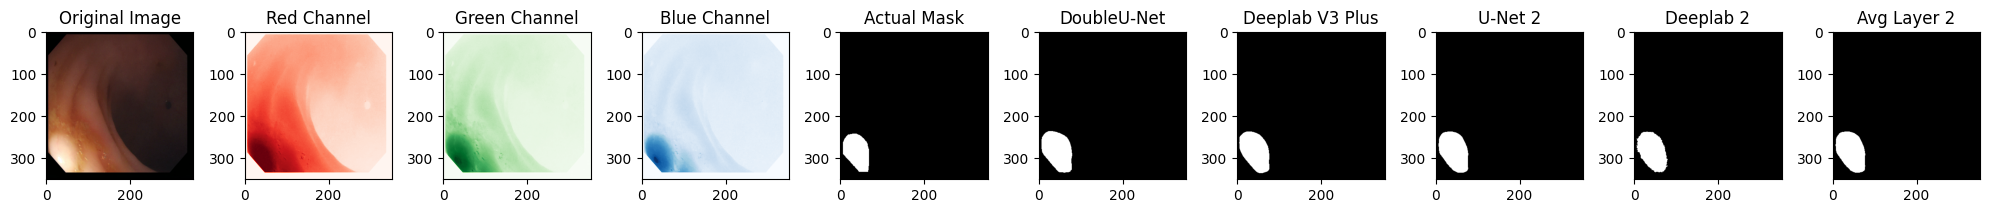

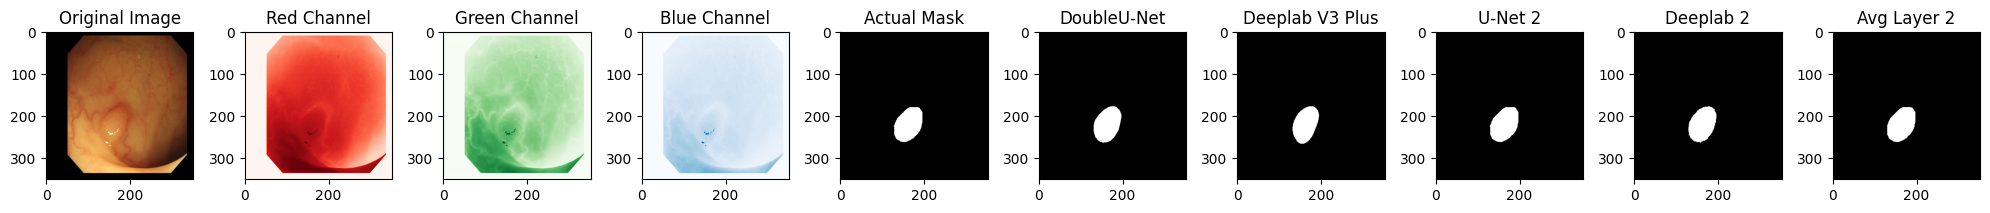

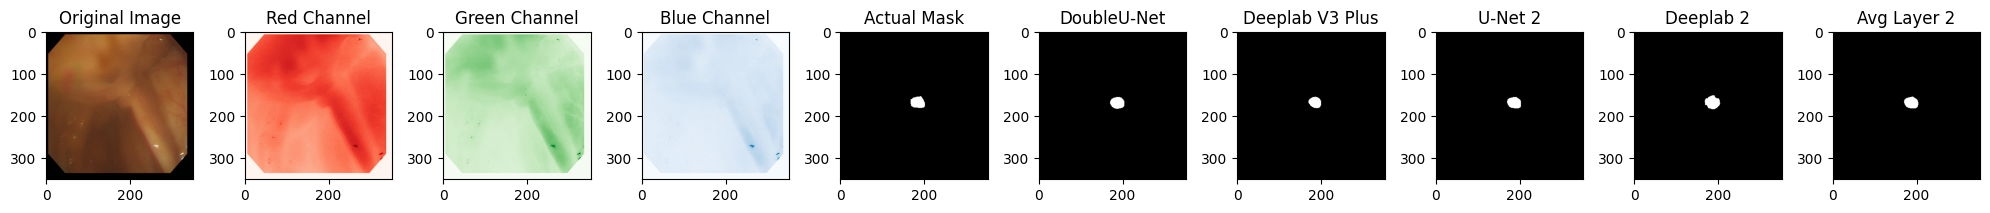

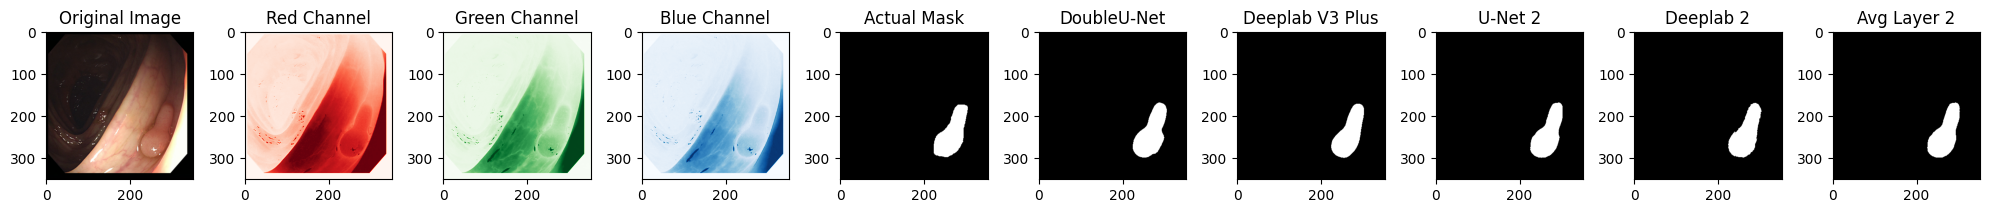

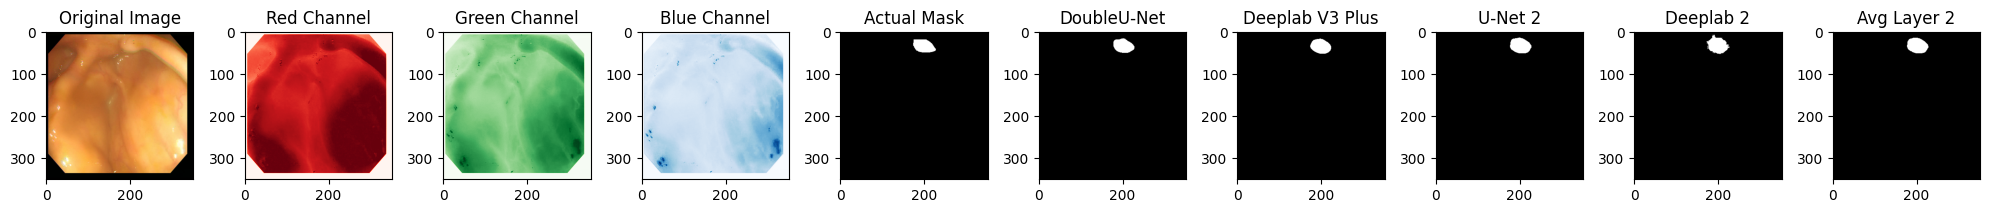

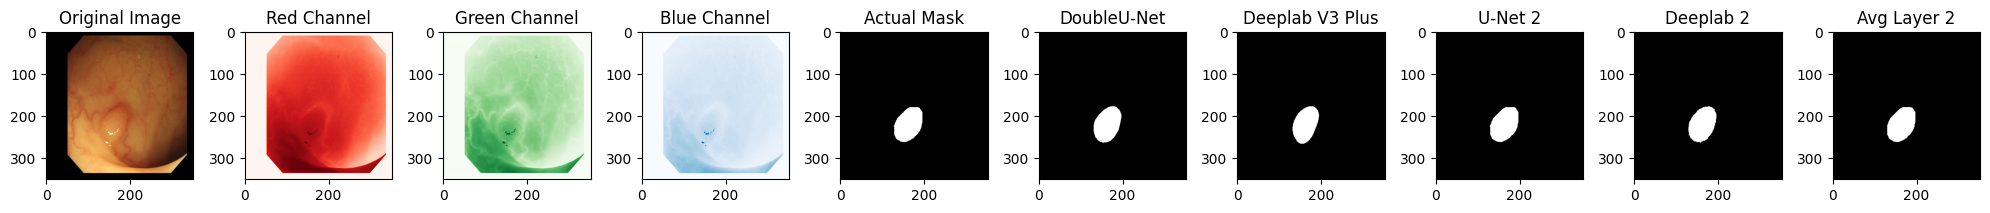

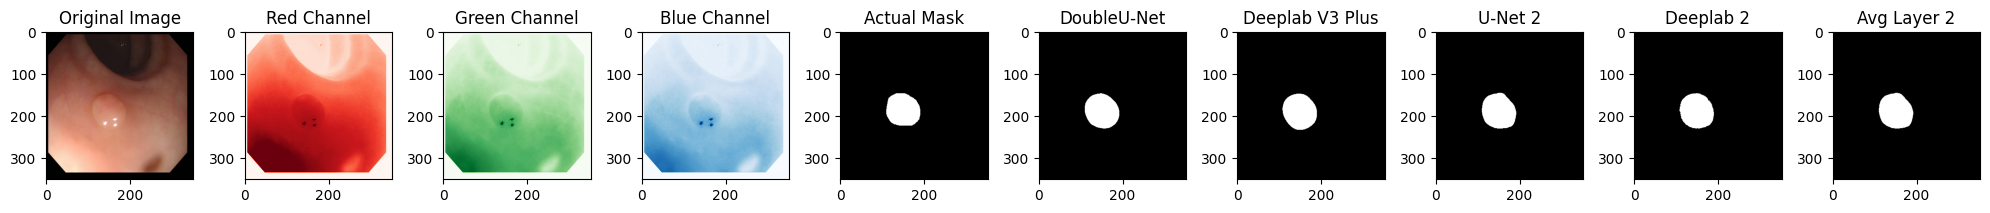

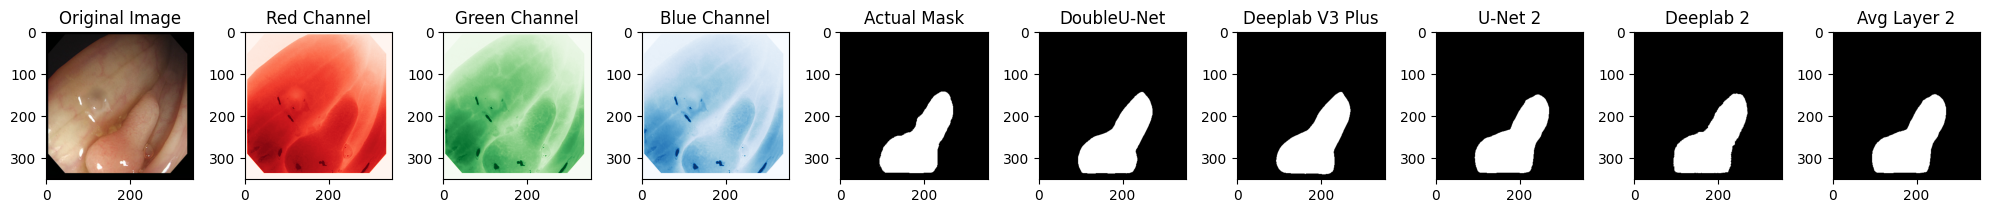

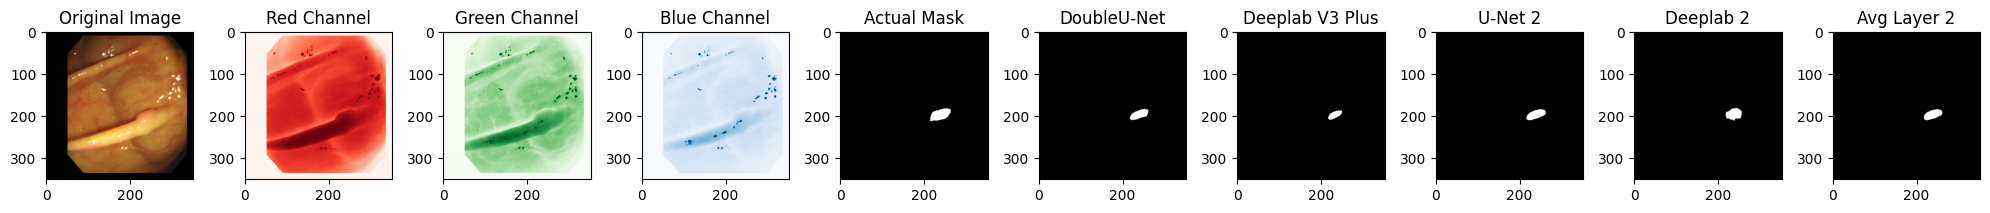

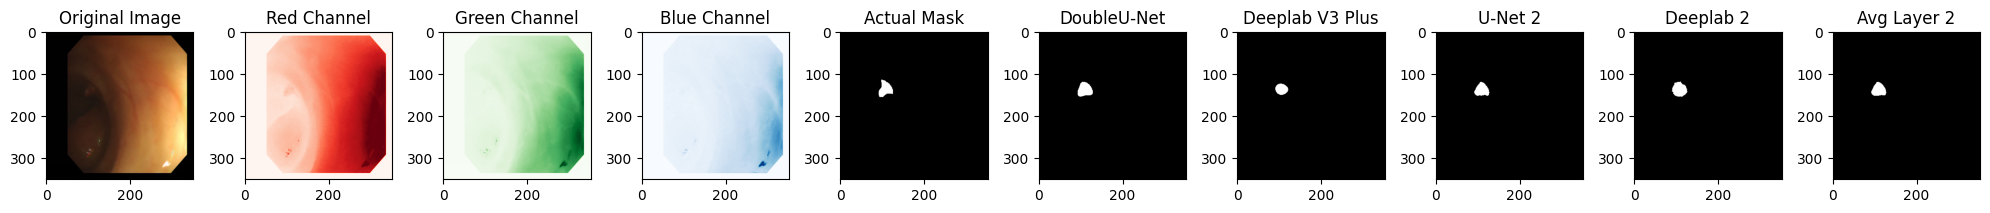

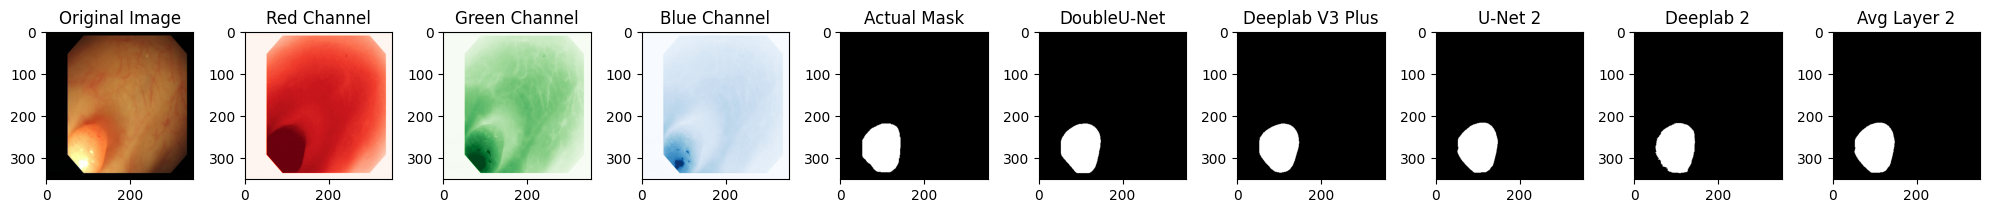

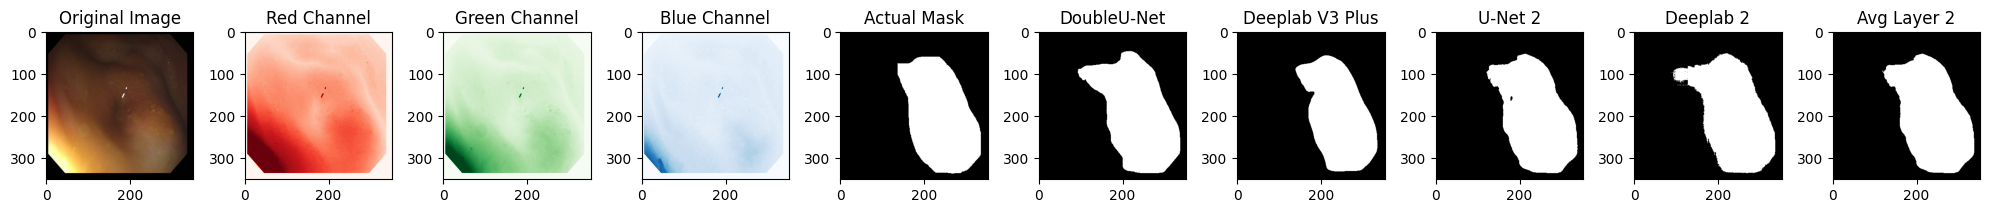

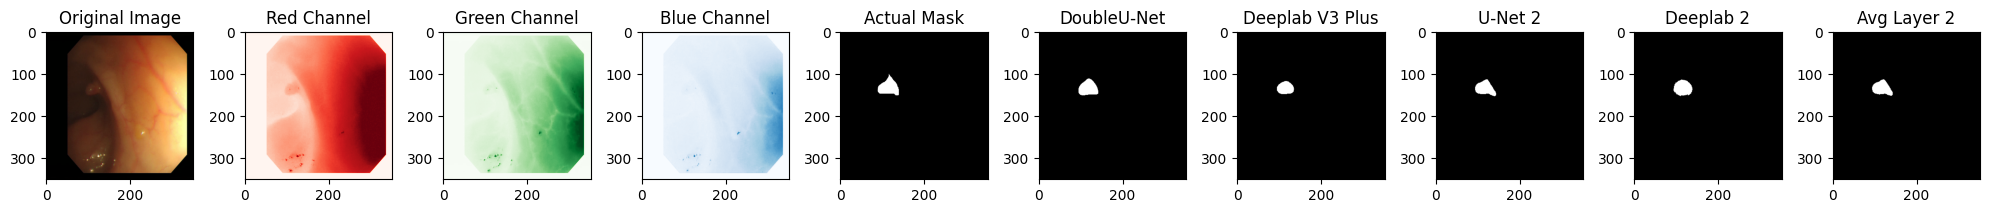

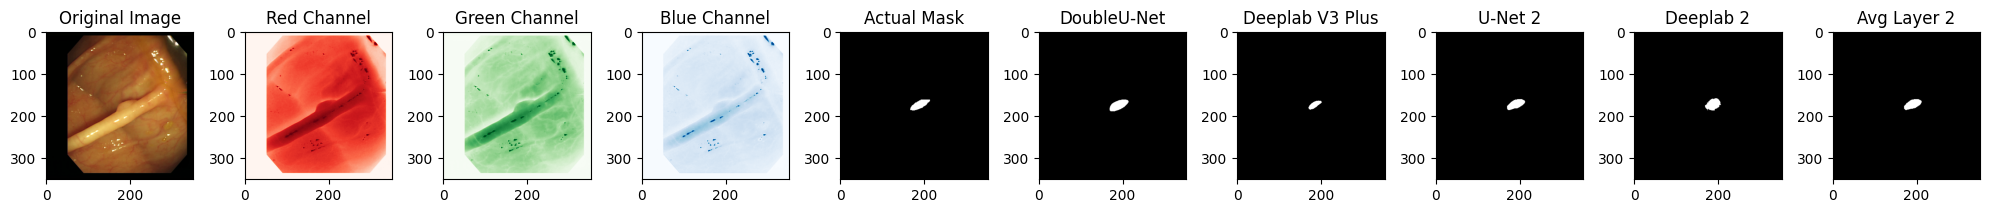

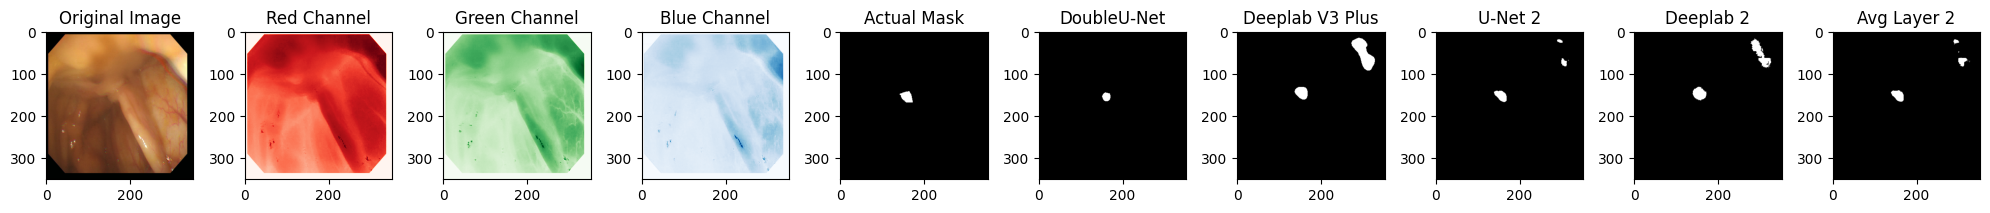

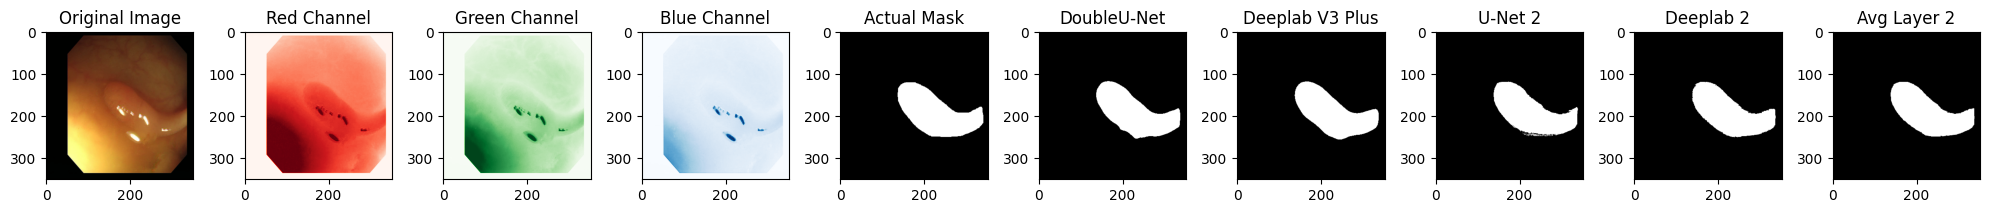

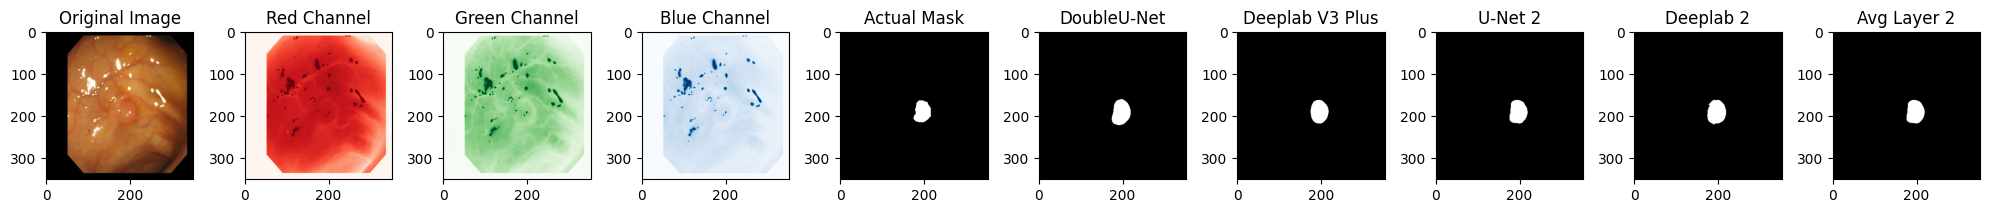

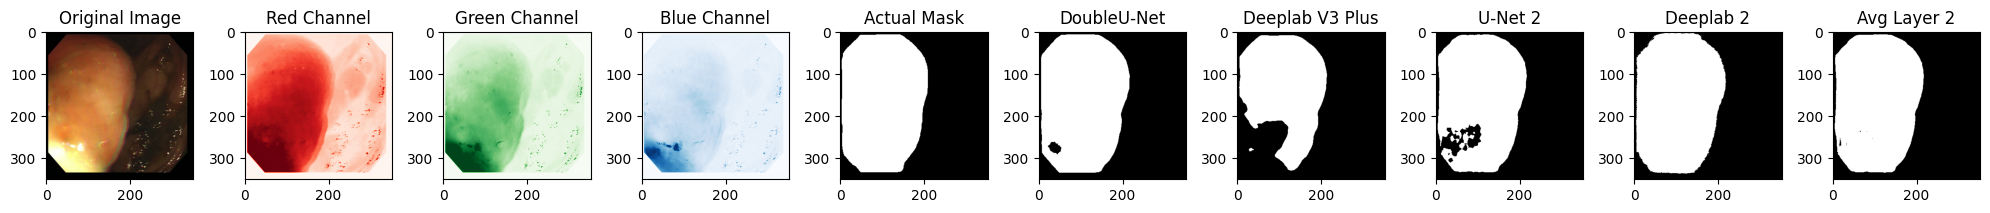

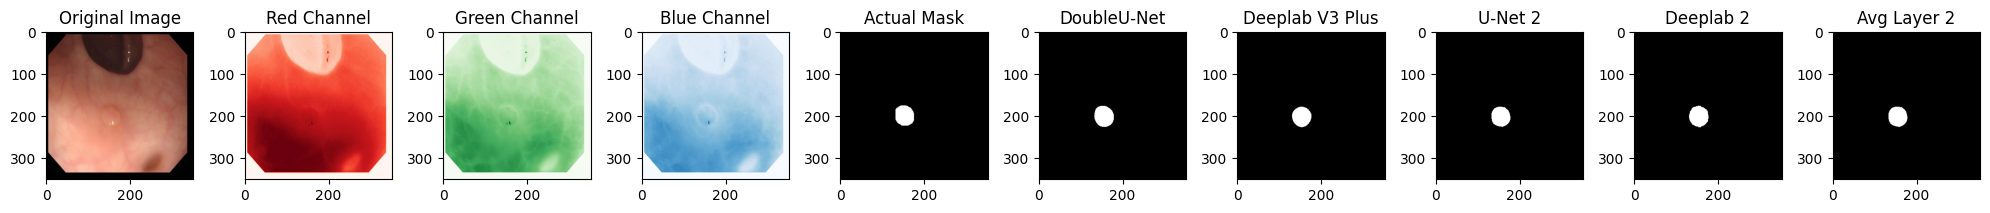

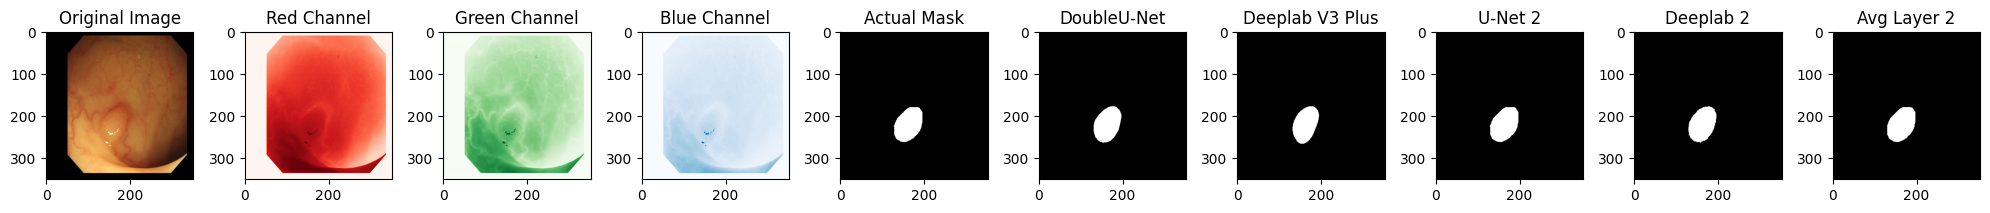

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

num_samples_to_visualize = 20
random_indices = np.random.choice(range(len(X_test)), num_samples_to_visualize, replace=False)

# Visualize each selected sample
for sample_index in random_indices:
    # Load the original image and corresponding mask
    original_image = X_test[sample_index]
    actual_mask = y_test[sample_index]

    # Get predictions for the chosen sample
    doubleunet_prediction = np.round(doubleunet_preds_t[sample_index, ..., 0])
    deeplabv3p_prediction = np.round(deeplabv3p_preds_t[sample_index, ..., 0])
    unet2_prediction = np.round(unet2_preds_t[sample_index, ..., 0])
    deeplab2_prediction = np.round(deeplab2_preds_t[sample_index, ..., 0])
    avg_prediction = np.round(average_preds_test[sample_index])
    # Plot the images and predictions
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 10, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 10, 2)
    plt.imshow(original_image[:, :, 0], cmap='Reds')
    plt.title("Red Channel")

    plt.subplot(1, 10, 3)
    plt.imshow(original_image[:, :, 1], cmap='Greens')
    plt.title("Green Channel")

    plt.subplot(1, 10, 4)
    plt.imshow(original_image[:, :, 2], cmap='Blues')
    plt.title("Blue Channel")

    plt.subplot(1, 10, 5)
    plt.imshow(actual_mask, cmap='gray')
    plt.title("Actual Mask")

    plt.subplot(1, 10, 6)
    plt.imshow(doubleunet_prediction, cmap='gray')
    plt.title("DoubleU-Net")

    plt.subplot(1, 10, 7)
    plt.imshow(deeplabv3p_prediction, cmap='gray')
    plt.title("Deeplab V3 Plus")
    
    plt.subplot(1, 10, 8)
    plt.imshow(unet2_prediction, cmap='gray')
    plt.title("U-Net 2")

    plt.subplot(1, 10, 9)
    plt.imshow(deeplab2_prediction, cmap='gray')
    plt.title("Deeplab 2")

    plt.subplot(1, 10, 10)
    plt.imshow(avg_prediction, cmap='gray')
    plt.title("Avg Layer 2")


    plt.tight_layout()
    plt.show()